We present our code for our two approaches:
- Multiple Instance Learning 
- Training on Glued images


# 1. Multiple Instance Learning

We install the required modules and import the necessary packages

In [3]:
!pip install warmup_scheduler
!pip install efficientnet_pytorch
import time
import os
import skimage.io
import numpy as np
import pandas as pd
import cv2
import PIL.Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
#from efficientnet_pytorch import model as enet
import albumentations as A
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchvision
import torchvision.models as models
import random
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import confusion_matrix
from torchvision import datasets, transforms
import torch.utils.data as data_utils
import PIL
from sklearn.model_selection import train_test_split

  Created wheel for warmup-scheduler: filename=warmup_scheduler-0.3-py3-none-any.whl size=2983 sha256=e9796b9dd559a7230c7073fac765716e6599f2ecd68623dffdf8a38dfda9dc62
  Stored in directory: /root/.cache/pip/wheels/b0/32/98/174058864084d31dbef4c4faa502a1fe9c12cc47e9cb6611e4
Successfully built warmup-scheduler
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=350d73b4f8d17f8f79720d30569cb342aabc4dec900d19fc16e9766a80f15221
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [ ]:
data_dir = '/content/drive/MyDrive/DLMI/'
df_train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
df_test = pd.read_csv(os.path.join(data_dir, 'test.csv'))

image_folder = os.path.join('/content/drive/MyDrive/DLMI/', 'train_128x128x64')

batch_size = 20
num_workers = 4
init_lr = 1e-4
n_epochs =30

device = torch.device('cuda')


Adding a fold column in the training dataset to perform cross validation later for more model stability.

In [ ]:
# For cross validation
skf = StratifiedKFold(5, shuffle=True, random_state=42)
df_train['fold'] = -1
for i, (train_index, valid_index) in enumerate(skf.split(df_train, df_train['isup_grade'])):
    df_train.loc[valid_index, 'fold'] = i
df_train.head()


,image_id,data_provider,isup_grade,gleason_score,fold
0,995df9b93db1e396b57692c6c7f1d673,radboud,0,negative,4
1,86d4621be3deca4f8d461e3abce7d585,radboud,4,4+4,4
2,e2578d331ae6cb3bc649027498c8ff8d,radboud,1,3+3,0
3,c65fcde885b4f231d03cefb0fc75f4fa,radboud,4,4+4,3
4,c4bbe05f5d77f1a42bc95191285ab1bb,radboud,3,4+3,4


Retrieving the computed values of the mean and std from the pre-processing notebook.

In [ ]:
mean = np.array([1.0-0.59142062, 1.0-0.39595404, 1.0-0.63195556])
std = np.array([0.41682076 , 0.46003966, 0.47146402])


class MIL_DataSet(data_utils.Dataset):
    def __init__(self, img_path, df, n_patches, transform=None):

        self.img_path = img_path
        self.df = df
        self.n_patches = n_patches
        self.img_list = list(self.df['image_id'])
        self.transform = transform

    def __getitem__(self, idx):
        img_id = self.img_list[idx]
        row = self.df.iloc[idx]
        # Selecting n_patches tile from the generated 64. (The idea here is to select for each epoch a different number of batches)
        rg = random.sample(list(np.arange(64)), self.n_patches)
        # the selected patches at the end of this operation
        tiles = ['/'+img_id + '_' + str(i) + '.png' for i in rg]
        image_tiles = [] # initialization of the list where we are going to stack the tiles.

        for tile in tiles:
            # Loading tiles
            image = cv2.cvtColor(cv2.imread(self.img_path+tile), cv2.COLOR_BGR2RGB)
            if self.transform is not None:
              image = self.transform(image=image)['image']

            image = 255 - image # to avoid a lot of black holes in the patches
            image = image.astype(np.float32) # converting to float32 for memory constraints
            image = (image/255.0 - mean)/std # standardization of each tile.
            image_tiles.append(image) # adding the image in the defined list
        
        # Converting to pytorch tensor.
        L_image_tiles=[]
        for img in image_tiles:
          img = np.transpose(img,(2,0,1))
          L_image_tiles.append(torch.from_numpy(img.astype(np.float32, copy=False)))
        img = np.transpose(img,(2,0,1))
        image_tiles = torch.stack(L_image_tiles, dim=0) # Stacking the made tiles 
        
        #Labels using encodings.
        label = np.zeros(5).astype(np.float32)
        label[:row.isup_grade] = 1.
        return image_tiles, torch.tensor(label)
    def __len__(self):
        return len(self.img_list)

We perform data augmentation for the training phase.


In [ ]:
transforms_train = A.Compose([
    A.ShiftScaleRotate(scale_limit=0.25, rotate_limit=180,p=0.5),
    A.Transpose(p=0.5),
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.OneOf([
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                             val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, 
                                   contrast_limit=0.2, p=0.5),
    ],p=0.9),
])

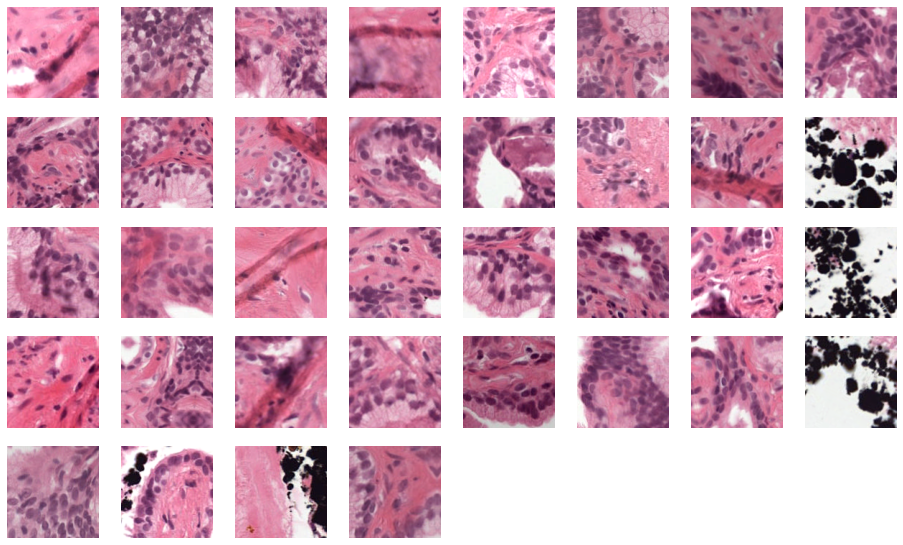

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

img_path = '/content/drive/MyDrive/DLMI/train_128x128x64'
ds = MIL_DataSet(img_path,df_train,36,transform =transforms_train)
x,y = ds[5]
originals = 255 - ((x.permute(0,2,3,1)*std + mean)*255.0).byte()
plt.figure(figsize=(16,32))
for i in range(len(originals)):
    plt.subplot(16,8,i+1)
    plt.imshow(originals[i])
    plt.axis('off')
    plt.subplots_adjust(wspace=None, hspace=None)

Transfer learning:
- model used for MIL with some frozen layers.


In [ ]:
# Inspired from https://github.com/uta-smile/DeepAttnMISL

class MIL_model (nn.Module):
    def __init__(self):
        super(MIL_model, self).__init__()
        self.L = 2048 # e fully connected layer
        self.D = 128 # 128 node attention layer
        self.K = 1

        self.feature_extraction = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(2)
        )
        # Adding a pre_trained resnet18 to help capture some features

        self.model_pretrained = models.resnet18(pretrained=True)
        # Making the first layers trainable since we are dealing with different types of images (medical)
        ct = 0
        for child in self.model_pretrained.children():
          ct += 1
          if 0<ct<3:
            for param in child.parameters():
              param.requires_grad = False
        # Adding those layers to the pre_trained layers attribute
        self.pretrained_layers = nn.Sequential(*list(self.model_pretrained.children())[2:6])
        
        # Defining an attention mechanism
        self.attention = nn.Sequential(
            
            nn.Linear(self.L, 512),
            nn.Tanh(),
            nn.Linear(512,self.D),
            nn.Tanh(),
            nn.Linear(self.D, 1)
        )

        self.classifier = nn.Sequential(
            nn.Linear(self.L * self.K, 5),
            
        )

    def forward(self, x):

        x = x.squeeze(0)  # omitting the first dimension
        H = self.feature_extraction(x) # extracting the features from the first block.
        H= self.pretrained_layers(H) 
        H = H.view(-1, 2048 )
       
        A = self.attention(H) # NxK
        A = torch.transpose(A, 1, 0) # KxN
        A = F.softmax(A, dim=1) # softmax over N
        M = torch.mm(A, H) # matrix multiplication between attention weights and the Features H
        Y_prob = self.classifier(M).float() # Classifier output to assign a class to the image_id

        return Y_prob



In [ ]:
criterion = nn.BCEWithLogitsLoss()

def train(model, device, train_loader, optimizer):
    model.train()
    predictions = []
    labels = []
    train_loss = []
    PREDS = []
    TARGETS = []
    all_targets = []
    all_predictions = []
    evolution = tqdm(train_loader)
    for batch_idx, (data, label) in enumerate(evolution):

        bag_label = label
        data = torch.squeeze(data)
        data, bag_label = data.to(device), bag_label.to(device) # sending to device
        logits= model(data)
        optimizer.zero_grad()
        # Calculate loss
        loss = criterion(logits, bag_label) # computing the loss.
        train_loss.append(loss.detach().cpu().numpy())
        # Calculate prediction
        pred = logits.sigmoid().sum(1).detach().round() # defining the appropriate class
        PREDS.append(pred) # Storing to compute metrics
        TARGETS.append(bag_label.sum(1)) # Storing to compute metrics
        all_targets.extend(bag_label.cpu().detach().numpy().tolist()) # Storing to compute metrics
        all_predictions.extend(torch.sigmoid(logits).cpu().detach().numpy().tolist()) # Storing to compute metrics
        evolution.set_description('loss: %.5f,' % loss.detach().cpu().numpy())

        # Backward pass & Update model weights
        loss.backward()
        optimizer.step()

    # Calculate loss and error for epoch
    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()
    val_roc_auc = roc_auc_score(all_targets, all_predictions,multi_class="ovr")
    print("###TRAIN Results###")
    print("Accuracy", (PREDS == TARGETS).mean() * 100 , " AUC ", val_roc_auc)
    return train_loss

In [ ]:
def test(model, device, test_loader):
    model.eval() # puting the model to the evaluation mode
    # Initializations to store the different values that we are interested in
    val_loss = []
    LOGITS = []
    PREDS = []
    TARGETS = []
    all_targets = []
    all_predictions = []
    # Predicting on the validation set
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(test_loader):
            bag_label = label
            data = torch.squeeze(data)
            data, bag_label = data.to(device), bag_label.to(device)
            logits= model(data)
            loss = criterion(logits, bag_label)
            pred = logits.sigmoid().sum(1).detach().round()
            LOGITS.append(logits)
            PREDS.append(pred)
            TARGETS.append(bag_label.sum(1))
            val_loss.append(loss.detach().cpu().numpy())
            all_targets.extend(bag_label.cpu().detach().numpy().tolist())
            all_predictions.extend(torch.sigmoid(logits).cpu().detach().numpy().tolist())
        val_loss = np.mean(val_loss)

    LOGITS = torch.cat(LOGITS).cpu().numpy()
    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()
    # Computing accuracy
    acc = (PREDS == TARGETS).mean() * 100.
    # Computing AUC
    val_roc_auc = roc_auc_score(all_targets, all_predictions,multi_class="ovr")
    
    return val_loss, acc, val_roc_auc,TARGETS,PREDS

    

When we were splitting the images into slides, we had a problem with the image that has 84 as index, it consumed all of the memory, for that reason, we had to drop it to avoid any complication. We tried to handle it locally but we failed to do so.

In [ ]:
# Cleaning the train dataframe by removing the index.
df_clean = df_train
df_clean = df_clean.drop(df_clean.index[84])
df_clean = df_clean.reset_index()
df_train = df_clean

In [ ]:
#Hyperparamters

n_tiles = 36
validation_folds=[]
batch_size = 1
num_workers = 4
lr = 1e-4
n_epochs =30

device = torch.device('cuda') # trainign on gpu


In [ ]:
# Training for all folds
img_path = '/content/drive/MyDrive/DLMI/train_128x128x64'
batch_size = 1
for fold in range(5):
    print("Training on FOLD ",fold)

    # Selecting samples for both train and validation and preparing datasets

    train_samples = np.where((df_train['fold'] != fold))[0]
    valid_samples = np.where((df_train['fold'] == fold))[0]

    df_train_fold  = df_train.loc[train_samples]
    df_valid_fold = df_train.loc[valid_samples]

    df_train_fold = df_train_fold.reset_index()
    df_valid_fold = df_valid_fold.reset_index()

    #Loading datasets
    dataset_train = MIL_DataSet(img_path,df_train_fold , n_tiles, transform=transforms_train)
    dataset_valid = MIL_DataSet(img_path,df_valid_fold, n_tiles, transform=None)
    
    # Preparing train and validation loaders
    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, sampler=RandomSampler(dataset_train),num_workers=4)
    valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, sampler=SequentialSampler(dataset_valid),num_workers=4)

    model = MIL_model ()
    model = model.to(device)
    print(len(dataset_train), len(dataset_valid))
    # Optimizer+ Scheduler
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs-1)

    # Start the training 
    best_auc = 0
    for epoch in range(1, n_epochs+1):
        train_loss = train(model, device, train_loader, optimizer)
        scheduler.step() # Schedular
        val_loss, val_acc, val_roc_auc,TARGETS,PREDS = test(model, device, valid_loader)
        print(f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_loss):.5f}, val loss: {np.mean(val_loss):.5f}, acc: {(val_acc):.5f},     val_roc_auc: {(val_roc_auc):.5f},')
        # If we obtain an AUC higher than the current best , we save the model.
        if val_roc_auc > best_auc :
          best_auc = val_roc_auc
          torch.save(model.state_dict(), os.path.join(f'/content/drive/MyDrive/DLMI/models/Attention_128_36_with_std_all_data{fold}.pth'))
          # Computing the confusion matrix whenever we have a better AUC
          conf_matrix = confusion_matrix(TARGETS, PREDS).astype("uint")
          print(conf_matrix)
    
    validation_folds.append(best_auc)


print(f"Validation folds results {validation_folds}")
print(f"The AUC for all the folds {np.mean(validation_folds)}")

Training on FOLD  0
271 68
Mon Apr  4 09:03:53 2022 Epoch: 1


loss: 0.64583,: 100%|██████████| 271/271 [06:36<00:00,  1.46s/it]

###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.4793851605244419


Epoch 1, lr: 0.0001000, train loss: 0.61098, val loss: 0.66090, acc: 10.29412,     val_roc_auc: 0.47987,
[[ 0  0 17  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  0  7  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 09:12:13 2022 Epoch: 2


loss: 0.48287,: 100%|██████████| 271/271 [05:00<00:00,  1.11s/it]

###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.5006028166367424



/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Epoch 2, lr: 0.0001000, train loss: 0.59747, val loss: 0.74436, acc: 10.29412,     val_roc_auc: 0.39267,
Mon Apr  4 09:18:28 2022 Epoch: 3


loss: 0.67581,: 100%|██████████| 271/271 [03:45<00:00,  1.20it/s]

###TRAIN Results###
Accuracy 11.439114391143912  AUC  0.48153592797106637


Epoch 3, lr: 0.0000997, train loss: 0.59683, val loss: 0.65400, acc: 10.29412,     val_roc_auc: 0.40164,
Mon Apr  4 09:23:13 2022 Epoch: 4


loss: 0.50419,: 100%|██████████| 271/271 [02:58<00:00,  1.51it/s]

###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.526099163924466


Epoch 4, lr: 0.0000988, train loss: 0.58211, val loss: 0.65930, acc: 10.29412,     val_roc_auc: 0.43649,
Mon Apr  4 09:27:00 2022 Epoch: 5


loss: 0.98601,: 100%|██████████| 271/271 [02:14<00:00,  2.01it/s]

###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.4397364363088186


Epoch 5, lr: 0.0000974, train loss: 0.59724, val loss: 0.63118, acc: 10.29412,     val_roc_auc: 0.45287,
Mon Apr  4 09:29:48 2022 Epoch: 6


loss: 0.42078,: 100%|██████████| 271/271 [01:48<00:00,  2.50it/s]

###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.4777294683018837


Epoch 6, lr: 0.0000954, train loss: 0.58940, val loss: 0.64655, acc: 10.29412,     val_roc_auc: 0.47769,
Mon Apr  4 09:32:05 2022 Epoch: 7


loss: 0.75452,: 100%|██████████| 271/271 [01:22<00:00,  3.29it/s]

###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.48569093761500204


Epoch 7, lr: 0.0000928, train loss: 0.58811, val loss: 0.63310, acc: 10.29412,     val_roc_auc: 0.42470,
Mon Apr  4 09:33:46 2022 Epoch: 8


loss: 0.59146,: 100%|██████████| 271/271 [01:11<00:00,  3.77it/s]

###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.5152031153885643


Epoch 8, lr: 0.0000898, train loss: 0.58502, val loss: 0.61829, acc: 10.29412,     val_roc_auc: 0.48198,
[[ 0  0 17  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  0  7  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 09:35:17 2022 Epoch: 9


loss: 0.50822,: 100%|██████████| 271/271 [00:56<00:00,  4.77it/s]

###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.5170153923662464


Epoch 9, lr: 0.0000863, train loss: 0.58171, val loss: 0.66476, acc: 10.29412,     val_roc_auc: 0.45638,
Mon Apr  4 09:36:26 2022 Epoch: 10


loss: 0.91076,: 100%|██████████| 271/271 [00:48<00:00,  5.64it/s]


###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.4938211465227882
Epoch 10, lr: 0.0000824, train loss: 0.58725, val loss: 0.61294, acc: 10.29412,     val_roc_auc: 0.44923,
Mon Apr  4 09:37:25 2022 Epoch: 11


loss: 0.63930,: 100%|██████████| 271/271 [00:34<00:00,  7.89it/s]

###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.4808435790127774


Epoch 11, lr: 0.0000781, train loss: 0.58656, val loss: 0.63424, acc: 10.29412,     val_roc_auc: 0.42659,
Mon Apr  4 09:38:08 2022 Epoch: 12


loss: 0.69344,: 100%|██████████| 271/271 [00:33<00:00,  8.06it/s]

###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.4787159024050869


Epoch 12, lr: 0.0000734, train loss: 0.58734, val loss: 0.62236, acc: 10.29412,     val_roc_auc: 0.47366,
Mon Apr  4 09:38:48 2022 Epoch: 13


loss: 0.37990,: 100%|██████████| 271/271 [00:27<00:00,  9.68it/s]

###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.5288922142033113


Epoch 13, lr: 0.0000685, train loss: 0.57846, val loss: 0.62369, acc: 10.29412,     val_roc_auc: 0.46061,
Mon Apr  4 09:39:21 2022 Epoch: 14


loss: 0.38835,: 100%|██████████| 271/271 [00:22<00:00, 11.97it/s]

###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.5005965196686948


Epoch 14, lr: 0.0000634, train loss: 0.58193, val loss: 0.61319, acc: 11.76471,     val_roc_auc: 0.48210,
[[ 0  0 17  0  0  0]
 [ 0  1 16  0  0  0]
 [ 0  0  7  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  1  8  0  0  0]]
Mon Apr  4 09:39:50 2022 Epoch: 15


loss: 0.55714,: 100%|██████████| 271/271 [00:18<00:00, 14.49it/s]

###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.514387847718144


Epoch 15, lr: 0.0000581, train loss: 0.58169, val loss: 0.61139, acc: 10.29412,     val_roc_auc: 0.48375,
[[ 0  0 17  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  0  7  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  1  8  0  0  0]]
Mon Apr  4 09:40:14 2022 Epoch: 16


loss: 0.54847,: 100%|██████████| 271/271 [00:16<00:00, 15.99it/s]


###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.5284164248600117
Epoch 16, lr: 0.0000527, train loss: 0.57799, val loss: 0.63021, acc: 10.29412,     val_roc_auc: 0.40820,
Mon Apr  4 09:40:36 2022 Epoch: 17


loss: 0.48691,: 100%|██████████| 271/271 [00:17<00:00, 15.29it/s]

###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.5693314117686705


Epoch 17, lr: 0.0000473, train loss: 0.57082, val loss: 0.62290, acc: 8.82353,     val_roc_auc: 0.43956,
Mon Apr  4 09:40:57 2022 Epoch: 18


loss: 0.37682,: 100%|██████████| 271/271 [00:15<00:00, 17.95it/s]

###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.537740483343876


Epoch 18, lr: 0.0000419, train loss: 0.57709, val loss: 0.62761, acc: 10.29412,     val_roc_auc: 0.42389,
Mon Apr  4 09:41:15 2022 Epoch: 19


loss: 0.35673,: 100%|██████████| 271/271 [00:13<00:00, 19.37it/s]


###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.5925236981539266
Epoch 19, lr: 0.0000366, train loss: 0.57019, val loss: 0.60813, acc: 11.76471,     val_roc_auc: 0.49916,
[[ 0  0 17  0  0  0]
 [ 0  1 16  0  0  0]
 [ 0  0  7  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 09:41:32 2022 Epoch: 20


loss: 1.04620,: 100%|██████████| 271/271 [00:14<00:00, 18.57it/s]


###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.586235946990664
Epoch 20, lr: 0.0000315, train loss: 0.56938, val loss: 0.62251, acc: 10.29412,     val_roc_auc: 0.43136,
Mon Apr  4 09:41:50 2022 Epoch: 21


loss: 0.68869,: 100%|██████████| 271/271 [00:13<00:00, 19.75it/s]


###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.5723339404401906
Epoch 21, lr: 0.0000266, train loss: 0.57298, val loss: 0.61446, acc: 10.29412,     val_roc_auc: 0.41449,
Mon Apr  4 09:42:07 2022 Epoch: 22


loss: 0.61005,: 100%|██████████| 271/271 [00:13<00:00, 20.33it/s]

###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.5505721226012941


Epoch 22, lr: 0.0000219, train loss: 0.57408, val loss: 0.60629, acc: 10.29412,     val_roc_auc: 0.50699,
[[ 0  0 17  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  0  7  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 09:42:22 2022 Epoch: 23


loss: 0.57495,: 100%|██████████| 271/271 [00:13<00:00, 20.71it/s]

###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.5857956588589219


Epoch 23, lr: 0.0000176, train loss: 0.56896, val loss: 0.59841, acc: 10.29412,     val_roc_auc: 0.51831,
[[ 0  0 17  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  0  7  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 09:42:38 2022 Epoch: 24


loss: 0.42182,: 100%|██████████| 271/271 [00:11<00:00, 23.66it/s]

###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.6130213706118588


Epoch 24, lr: 0.0000137, train loss: 0.56467, val loss: 0.58192, acc: 10.29412,     val_roc_auc: 0.56641,
[[ 0  0 17  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  0  7  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 09:42:52 2022 Epoch: 25


loss: 0.63544,: 100%|██████████| 271/271 [00:11<00:00, 23.00it/s]

###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.6115033518513069


Epoch 25, lr: 0.0000102, train loss: 0.56294, val loss: 0.60193, acc: 13.23529,     val_roc_auc: 0.49332,
Mon Apr  4 09:43:06 2022 Epoch: 26


loss: 0.60355,: 100%|██████████| 271/271 [00:11<00:00, 23.37it/s]

###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.5946183836763955


Epoch 26, lr: 0.0000072, train loss: 0.56504, val loss: 0.59820, acc: 10.29412,     val_roc_auc: 0.46390,
Mon Apr  4 09:43:20 2022 Epoch: 27


loss: 0.58659,: 100%|██████████| 271/271 [00:11<00:00, 22.82it/s]

###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.6021668016241211


Epoch 27, lr: 0.0000046, train loss: 0.56532, val loss: 0.59808, acc: 10.29412,     val_roc_auc: 0.52547,
Mon Apr  4 09:43:34 2022 Epoch: 28


loss: 0.66181,: 100%|██████████| 271/271 [00:11<00:00, 23.77it/s]


###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.6049685609118743
Epoch 28, lr: 0.0000026, train loss: 0.56556, val loss: 0.59231, acc: 10.29412,     val_roc_auc: 0.54475,
Mon Apr  4 09:43:48 2022 Epoch: 29


loss: 0.40741,: 100%|██████████| 271/271 [00:11<00:00, 23.76it/s]

###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.5972928482085804


Epoch 29, lr: 0.0000012, train loss: 0.56659, val loss: 0.61327, acc: 10.29412,     val_roc_auc: 0.54566,
Mon Apr  4 09:44:02 2022 Epoch: 30


loss: 0.74125,: 100%|██████████| 271/271 [00:11<00:00, 23.97it/s]


###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.652403182723722
Epoch 30, lr: 0.0000003, train loss: 0.55803, val loss: 0.59626, acc: 10.29412,     val_roc_auc: 0.48675,
Training on FOLD  1
272 67
Mon Apr  4 09:44:16 2022 Epoch: 1


loss: 0.45879,: 100%|██████████| 272/272 [00:11<00:00, 24.01it/s]

###TRAIN Results###
Accuracy 11.397058823529411  AUC  0.5024336967419482


Epoch 1, lr: 0.0001000, train loss: 0.61176, val loss: 0.64012, acc: 8.95522,     val_roc_auc: 0.44549,
[[ 0  0 16  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  0  6  1  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 09:44:30 2022 Epoch: 2


loss: 0.45341,: 100%|██████████| 272/272 [00:11<00:00, 24.18it/s]


###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.4603872434207596


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Epoch 2, lr: 0.0001000, train loss: 0.59971, val loss: 0.62451, acc: 13.43284,     val_roc_auc: 0.45660,
[[ 0  0 16  0  0  0]
 [ 0  2 14  1  0  0]
 [ 0  0  7  0  0  0]
 [ 0  1  8  0  0  0]
 [ 0  1  8  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 09:44:43 2022 Epoch: 3


loss: 0.41660,: 100%|██████████| 272/272 [00:11<00:00, 24.45it/s]


###TRAIN Results###
Accuracy 11.397058823529411  AUC  0.475569026869318
Epoch 3, lr: 0.0000997, train loss: 0.59978, val loss: 0.71504, acc: 10.44776,     val_roc_auc: 0.36921,
Mon Apr  4 09:44:56 2022 Epoch: 4


loss: 0.46269,: 100%|██████████| 272/272 [00:11<00:00, 23.89it/s]

###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.504142021766499


Epoch 4, lr: 0.0000988, train loss: 0.59126, val loss: 0.62637, acc: 10.44776,     val_roc_auc: 0.41028,
Mon Apr  4 09:45:10 2022 Epoch: 5


loss: 0.65079,: 100%|██████████| 272/272 [00:11<00:00, 24.41it/s]

###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.5012338919821919


Epoch 5, lr: 0.0000974, train loss: 0.58802, val loss: 0.63080, acc: 10.44776,     val_roc_auc: 0.48962,
[[ 0  0 16  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  0  7  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 09:45:24 2022 Epoch: 6


loss: 0.43910,: 100%|██████████| 272/272 [00:11<00:00, 24.30it/s]


###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.4757302916297393
Epoch 6, lr: 0.0000954, train loss: 0.59272, val loss: 0.61907, acc: 10.44776,     val_roc_auc: 0.42399,
Mon Apr  4 09:45:37 2022 Epoch: 7


loss: 0.45301,: 100%|██████████| 272/272 [00:11<00:00, 24.13it/s]

###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.49847492337023364


Epoch 7, lr: 0.0000928, train loss: 0.58467, val loss: 0.61656, acc: 10.44776,     val_roc_auc: 0.40698,
Mon Apr  4 09:45:50 2022 Epoch: 8


loss: 1.16739,: 100%|██████████| 272/272 [00:11<00:00, 24.01it/s]


###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.49302965227365075
Epoch 8, lr: 0.0000898, train loss: 0.58689, val loss: 0.62172, acc: 10.44776,     val_roc_auc: 0.45853,
Mon Apr  4 09:46:04 2022 Epoch: 9


loss: 0.52030,: 100%|██████████| 272/272 [00:11<00:00, 24.43it/s]


###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.491761465979698
Epoch 9, lr: 0.0000863, train loss: 0.58691, val loss: 0.69919, acc: 10.44776,     val_roc_auc: 0.42145,
Mon Apr  4 09:46:17 2022 Epoch: 10


loss: 0.43736,: 100%|██████████| 272/272 [00:11<00:00, 23.82it/s]

###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.5075672857350777


Epoch 10, lr: 0.0000824, train loss: 0.58328, val loss: 0.59528, acc: 10.44776,     val_roc_auc: 0.42756,
Mon Apr  4 09:46:31 2022 Epoch: 11


loss: 0.37197,: 100%|██████████| 272/272 [00:11<00:00, 24.34it/s]


###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.509059113281754
Epoch 11, lr: 0.0000781, train loss: 0.58421, val loss: 0.63009, acc: 10.44776,     val_roc_auc: 0.40469,
Mon Apr  4 09:46:44 2022 Epoch: 12


loss: 0.41523,: 100%|██████████| 272/272 [00:11<00:00, 24.35it/s]

###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.4924203381121986


Epoch 12, lr: 0.0000734, train loss: 0.58362, val loss: 0.58526, acc: 10.44776,     val_roc_auc: 0.57121,
[[ 0  0 16  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  0  7  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 09:46:58 2022 Epoch: 13


loss: 0.39178,: 100%|██████████| 272/272 [00:11<00:00, 24.14it/s]

###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.49858018766625084


Epoch 13, lr: 0.0000685, train loss: 0.58385, val loss: 0.64159, acc: 10.44776,     val_roc_auc: 0.47828,
Mon Apr  4 09:47:11 2022 Epoch: 14


loss: 1.25786,: 100%|██████████| 272/272 [00:11<00:00, 24.18it/s]


###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.5239588835363346
Epoch 14, lr: 0.0000634, train loss: 0.58076, val loss: 0.62990, acc: 8.95522,     val_roc_auc: 0.49190,
Mon Apr  4 09:47:24 2022 Epoch: 15


loss: 0.51675,: 100%|██████████| 272/272 [00:11<00:00, 24.31it/s]

###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.5233142926434209


Epoch 15, lr: 0.0000581, train loss: 0.58018, val loss: 0.67981, acc: 10.44776,     val_roc_auc: 0.46379,
Mon Apr  4 09:47:38 2022 Epoch: 16


loss: 0.35813,: 100%|██████████| 272/272 [00:11<00:00, 24.21it/s]

###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.501025531857874


Epoch 16, lr: 0.0000527, train loss: 0.58216, val loss: 0.64668, acc: 10.44776,     val_roc_auc: 0.47471,
Mon Apr  4 09:47:51 2022 Epoch: 17


loss: 0.53643,: 100%|██████████| 272/272 [00:11<00:00, 24.38it/s]

###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.5520162316762236


Epoch 17, lr: 0.0000473, train loss: 0.57546, val loss: 0.58590, acc: 10.44776,     val_roc_auc: 0.49823,
Mon Apr  4 09:48:04 2022 Epoch: 18


loss: 0.58048,: 100%|██████████| 272/272 [00:11<00:00, 24.22it/s]


###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.5278316001830077
Epoch 18, lr: 0.0000419, train loss: 0.57913, val loss: 0.63031, acc: 10.44776,     val_roc_auc: 0.44191,
Mon Apr  4 09:48:18 2022 Epoch: 19


loss: 0.37441,: 100%|██████████| 272/272 [00:11<00:00, 24.22it/s]

###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.5437210521173655


Epoch 19, lr: 0.0000366, train loss: 0.57682, val loss: 0.58657, acc: 8.95522,     val_roc_auc: 0.57282,
[[ 0  0 16  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  1  6  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 09:48:31 2022 Epoch: 20


loss: 0.60870,: 100%|██████████| 272/272 [00:11<00:00, 24.18it/s]

###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.5357649066805712


Epoch 20, lr: 0.0000315, train loss: 0.57666, val loss: 0.59962, acc: 8.95522,     val_roc_auc: 0.51640,
Mon Apr  4 09:48:45 2022 Epoch: 21


loss: 0.58499,: 100%|██████████| 272/272 [00:11<00:00, 24.38it/s]


###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.49182166077836653
Epoch 21, lr: 0.0000266, train loss: 0.58402, val loss: 0.58274, acc: 10.44776,     val_roc_auc: 0.57302,
[[ 0  2 14  0  0  0]
 [ 0  1 16  0  0  0]
 [ 0  1  6  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 09:48:58 2022 Epoch: 22


loss: 0.58385,: 100%|██████████| 272/272 [00:11<00:00, 23.76it/s]

###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.5565205019002579


Epoch 22, lr: 0.0000219, train loss: 0.57511, val loss: 0.58369, acc: 8.95522,     val_roc_auc: 0.54799,
Mon Apr  4 09:49:12 2022 Epoch: 23


loss: 0.69916,: 100%|██████████| 272/272 [00:11<00:00, 23.88it/s]

###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.5716134635204951


Epoch 23, lr: 0.0000176, train loss: 0.57196, val loss: 0.60477, acc: 11.94030,     val_roc_auc: 0.53046,
Mon Apr  4 09:49:25 2022 Epoch: 24


loss: 0.68597,: 100%|██████████| 272/272 [00:11<00:00, 24.39it/s]

###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.5732675090994249


Epoch 24, lr: 0.0000137, train loss: 0.57358, val loss: 0.57063, acc: 10.44776,     val_roc_auc: 0.61806,
[[ 0  3 13  0  0  0]
 [ 0  1 16  0  0  0]
 [ 0  1  6  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 09:49:39 2022 Epoch: 25


loss: 0.56830,: 100%|██████████| 272/272 [00:11<00:00, 24.01it/s]


###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.5655414927396085
Epoch 25, lr: 0.0000102, train loss: 0.57258, val loss: 0.56687, acc: 10.44776,     val_roc_auc: 0.61068,
Mon Apr  4 09:49:52 2022 Epoch: 26


loss: 1.21076,: 100%|██████████| 272/272 [00:11<00:00, 24.33it/s]


###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.5790540592090985
Epoch 26, lr: 0.0000072, train loss: 0.57003, val loss: 0.57615, acc: 10.44776,     val_roc_auc: 0.62116,
[[ 0  4 12  0  0  0]
 [ 0  1 16  0  0  0]
 [ 0  1  6  0  0  0]
 [ 0  1  8  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  1  8  0  0  0]]
Mon Apr  4 09:50:06 2022 Epoch: 27


loss: 0.64908,: 100%|██████████| 272/272 [00:11<00:00, 24.01it/s]

###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.5890679616761205


Epoch 27, lr: 0.0000046, train loss: 0.57003, val loss: 0.58492, acc: 10.44776,     val_roc_auc: 0.53322,
Mon Apr  4 09:50:19 2022 Epoch: 28


loss: 0.96665,: 100%|██████████| 272/272 [00:11<00:00, 24.18it/s]

###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.5903342326413237


Epoch 28, lr: 0.0000026, train loss: 0.56890, val loss: 0.58654, acc: 13.43284,     val_roc_auc: 0.58194,
Mon Apr  4 09:50:33 2022 Epoch: 29


loss: 0.46543,: 100%|██████████| 272/272 [00:11<00:00, 24.35it/s]

###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.5849488101846546


Epoch 29, lr: 0.0000012, train loss: 0.57011, val loss: 0.58568, acc: 10.44776,     val_roc_auc: 0.55644,
Mon Apr  4 09:50:46 2022 Epoch: 30


loss: 0.58314,: 100%|██████████| 272/272 [00:11<00:00, 24.15it/s]


###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.5792712606034132
Epoch 30, lr: 0.0000003, train loss: 0.56947, val loss: 0.57268, acc: 8.95522,     val_roc_auc: 0.59452,
Training on FOLD  2
271 68
Mon Apr  4 09:51:00 2022 Epoch: 1


loss: 0.60337,: 100%|██████████| 271/271 [00:11<00:00, 24.03it/s]


###TRAIN Results###
Accuracy 10.33210332103321  AUC  0.48689375254665024
Epoch 1, lr: 0.0001000, train loss: 0.61892, val loss: 0.58382, acc: 11.76471,     val_roc_auc: 0.53320,
[[ 0  2 15  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 09:51:13 2022 Epoch: 2


loss: 0.46575,: 100%|██████████| 271/271 [00:11<00:00, 23.95it/s]


###TRAIN Results###
Accuracy 10.33210332103321  AUC  0.5071536508797759


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Epoch 2, lr: 0.0001000, train loss: 0.59291, val loss: 0.59076, acc: 11.76471,     val_roc_auc: 0.52966,
Mon Apr  4 09:51:27 2022 Epoch: 3


loss: 0.31315,: 100%|██████████| 271/271 [00:11<00:00, 24.21it/s]


###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.5060787146858216
Epoch 3, lr: 0.0000997, train loss: 0.59370, val loss: 0.62577, acc: 10.29412,     val_roc_auc: 0.54835,
[[ 0  1 16  0  0  0]
 [ 0  1 16  0  0  0]
 [ 0  2  6  0  0  0]
 [ 0  1  8  0  0  0]
 [ 0  1  7  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 09:51:41 2022 Epoch: 4


loss: 0.52938,: 100%|██████████| 271/271 [00:11<00:00, 23.84it/s]


###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.5110431971064562
Epoch 4, lr: 0.0000988, train loss: 0.58905, val loss: 0.58270, acc: 11.76471,     val_roc_auc: 0.57015,
[[ 0  0 17  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  1  8  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 09:51:54 2022 Epoch: 5


loss: 0.54989,: 100%|██████████| 271/271 [00:11<00:00, 23.90it/s]


###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.48961454248074887
Epoch 5, lr: 0.0000974, train loss: 0.59156, val loss: 0.59914, acc: 11.76471,     val_roc_auc: 0.53785,
Mon Apr  4 09:52:08 2022 Epoch: 6


loss: 0.62594,: 100%|██████████| 271/271 [00:11<00:00, 24.06it/s]

###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.5186303832982972


Epoch 6, lr: 0.0000954, train loss: 0.58581, val loss: 0.58434, acc: 11.76471,     val_roc_auc: 0.57131,
[[ 0  0 17  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 09:52:21 2022 Epoch: 7


loss: 0.59024,: 100%|██████████| 271/271 [00:11<00:00, 23.85it/s]


###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.49224001806990786
Epoch 7, lr: 0.0000928, train loss: 0.58883, val loss: 0.57551, acc: 11.76471,     val_roc_auc: 0.56505,
Mon Apr  4 09:52:35 2022 Epoch: 8


loss: 0.65337,: 100%|██████████| 271/271 [00:11<00:00, 24.18it/s]

###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.5329318059782204


Epoch 8, lr: 0.0000898, train loss: 0.58392, val loss: 0.58501, acc: 11.76471,     val_roc_auc: 0.56698,
Mon Apr  4 09:52:48 2022 Epoch: 9


loss: 0.50300,: 100%|██████████| 271/271 [00:11<00:00, 24.19it/s]


###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.48836426336480815
Epoch 9, lr: 0.0000863, train loss: 0.58815, val loss: 0.58239, acc: 11.76471,     val_roc_auc: 0.61149,
[[ 0  0 17  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 09:53:02 2022 Epoch: 10


loss: 0.65784,: 100%|██████████| 271/271 [00:11<00:00, 23.91it/s]


###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.5143108563718999
Epoch 10, lr: 0.0000824, train loss: 0.58298, val loss: 0.58599, acc: 11.76471,     val_roc_auc: 0.51661,
Mon Apr  4 09:53:15 2022 Epoch: 11


loss: 0.42023,: 100%|██████████| 271/271 [00:11<00:00, 24.04it/s]


###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.5310658731083517
Epoch 11, lr: 0.0000781, train loss: 0.58112, val loss: 0.59227, acc: 11.76471,     val_roc_auc: 0.54205,
Mon Apr  4 09:53:29 2022 Epoch: 12


loss: 0.40174,: 100%|██████████| 271/271 [00:11<00:00, 24.06it/s]


###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.5479538614689733
Epoch 12, lr: 0.0000734, train loss: 0.57737, val loss: 0.58211, acc: 11.76471,     val_roc_auc: 0.56591,
Mon Apr  4 09:53:42 2022 Epoch: 13


loss: 0.46779,: 100%|██████████| 271/271 [00:11<00:00, 23.48it/s]


###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.5185631217734363
Epoch 13, lr: 0.0000685, train loss: 0.58154, val loss: 0.56861, acc: 11.76471,     val_roc_auc: 0.59803,
Mon Apr  4 09:53:56 2022 Epoch: 14


loss: 0.49443,: 100%|██████████| 271/271 [00:11<00:00, 23.98it/s]


###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.5722066819759581
Epoch 14, lr: 0.0000634, train loss: 0.57459, val loss: 0.57750, acc: 10.29412,     val_roc_auc: 0.59656,
Mon Apr  4 09:54:10 2022 Epoch: 15


loss: 0.43130,: 100%|██████████| 271/271 [00:11<00:00, 23.64it/s]


###TRAIN Results###
Accuracy 11.439114391143912  AUC  0.5764602924203561
Epoch 15, lr: 0.0000581, train loss: 0.57220, val loss: 0.57034, acc: 10.29412,     val_roc_auc: 0.62237,
[[ 0  0 17  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  1  7  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  1  7  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 09:54:24 2022 Epoch: 16


loss: 0.41836,: 100%|██████████| 271/271 [00:11<00:00, 23.76it/s]


###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.5288423427417683
Epoch 16, lr: 0.0000527, train loss: 0.58055, val loss: 0.56096, acc: 13.23529,     val_roc_auc: 0.62628,
[[ 0  0 17  0  0  0]
 [ 0  1 16  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 09:54:37 2022 Epoch: 17


loss: 0.58938,: 100%|██████████| 271/271 [00:11<00:00, 24.11it/s]

###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.5599754160544742


Epoch 17, lr: 0.0000473, train loss: 0.57716, val loss: 0.57792, acc: 10.29412,     val_roc_auc: 0.57741,
Mon Apr  4 09:54:51 2022 Epoch: 18


loss: 0.42146,: 100%|██████████| 271/271 [00:11<00:00, 23.89it/s]


###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.5808116266857043
Epoch 18, lr: 0.0000419, train loss: 0.57054, val loss: 0.56558, acc: 13.23529,     val_roc_auc: 0.63460,
[[ 0  0 17  0  0  0]
 [ 0  1 16  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  1  7  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 09:55:05 2022 Epoch: 19


loss: 0.64576,: 100%|██████████| 271/271 [00:11<00:00, 23.76it/s]


###TRAIN Results###
Accuracy 11.808118081180812  AUC  0.6185065908095762
Epoch 19, lr: 0.0000366, train loss: 0.56376, val loss: 0.56977, acc: 14.70588,     val_roc_auc: 0.62222,
Mon Apr  4 09:55:18 2022 Epoch: 20


loss: 0.47448,: 100%|██████████| 271/271 [00:11<00:00, 24.36it/s]


###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.613159063179376
Epoch 20, lr: 0.0000315, train loss: 0.56376, val loss: 0.56540, acc: 14.70588,     val_roc_auc: 0.61470,
Mon Apr  4 09:55:31 2022 Epoch: 21


loss: 0.58252,: 100%|██████████| 271/271 [00:11<00:00, 24.23it/s]

###TRAIN Results###
Accuracy 12.177121771217712  AUC  0.6261665144145386


Epoch 21, lr: 0.0000266, train loss: 0.56124, val loss: 0.57187, acc: 14.70588,     val_roc_auc: 0.64309,
[[ 0  6 11  0  0  0]
 [ 0  4 13  0  0  0]
 [ 0  2  6  0  0  0]
 [ 0  1  8  0  0  0]
 [ 0  2  6  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 09:55:45 2022 Epoch: 22


loss: 0.38125,: 100%|██████████| 271/271 [00:11<00:00, 23.84it/s]


###TRAIN Results###
Accuracy 11.439114391143912  AUC  0.6432344986387516
Epoch 22, lr: 0.0000219, train loss: 0.55628, val loss: 0.56561, acc: 17.64706,     val_roc_auc: 0.64816,
[[ 0  6 11  0  0  0]
 [ 0  4 13  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  2  7  0  0  0]
 [ 0  2  6  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 09:55:59 2022 Epoch: 23


loss: 0.37386,: 100%|██████████| 271/271 [00:11<00:00, 23.69it/s]

###TRAIN Results###
Accuracy 12.546125461254611  AUC  0.660921446877475


Epoch 23, lr: 0.0000176, train loss: 0.55053, val loss: 0.55408, acc: 17.64706,     val_roc_auc: 0.69088,
[[ 0  2 15  0  0  0]
 [ 0  5 12  0  0  0]
 [ 0  1  7  0  0  0]
 [ 0  1  8  0  0  0]
 [ 0  1  7  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 09:56:13 2022 Epoch: 24


loss: 0.57973,: 100%|██████████| 271/271 [00:11<00:00, 23.86it/s]

###TRAIN Results###
Accuracy 11.808118081180812  AUC  0.6301938094484276


Epoch 24, lr: 0.0000137, train loss: 0.55747, val loss: 0.53278, acc: 22.05882,     val_roc_auc: 0.73918,
[[ 0  7 10  0  0  0]
 [ 0  6 11  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  2  6  1  0  0]
 [ 0  1  7  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 09:56:26 2022 Epoch: 25


loss: 0.45829,: 100%|██████████| 271/271 [00:11<00:00, 23.68it/s]


###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.6669456407975666
Epoch 25, lr: 0.0000102, train loss: 0.54970, val loss: 0.55703, acc: 16.17647,     val_roc_auc: 0.65078,
Mon Apr  4 09:56:40 2022 Epoch: 26


loss: 0.52486,: 100%|██████████| 271/271 [00:11<00:00, 24.17it/s]

###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.6631200443074534


Epoch 26, lr: 0.0000072, train loss: 0.55075, val loss: 0.54527, acc: 14.70588,     val_roc_auc: 0.69258,
Mon Apr  4 09:56:53 2022 Epoch: 27


loss: 0.45790,: 100%|██████████| 271/271 [00:11<00:00, 24.41it/s]

###TRAIN Results###
Accuracy 11.439114391143912  AUC  0.6866504137374788


Epoch 27, lr: 0.0000046, train loss: 0.54251, val loss: 0.55016, acc: 14.70588,     val_roc_auc: 0.68663,
Mon Apr  4 09:57:07 2022 Epoch: 28


loss: 1.26930,: 100%|██████████| 271/271 [00:11<00:00, 24.26it/s]


###TRAIN Results###
Accuracy 11.439114391143912  AUC  0.6624821815715803
Epoch 28, lr: 0.0000026, train loss: 0.54877, val loss: 0.57348, acc: 17.64706,     val_roc_auc: 0.60955,
Mon Apr  4 09:57:20 2022 Epoch: 29


loss: 0.71164,: 100%|██████████| 271/271 [00:11<00:00, 23.87it/s]


###TRAIN Results###
Accuracy 13.284132841328415  AUC  0.6592052269330705
Epoch 29, lr: 0.0000012, train loss: 0.54924, val loss: 0.55643, acc: 16.17647,     val_roc_auc: 0.64550,
Mon Apr  4 09:57:33 2022 Epoch: 30


loss: 0.38352,: 100%|██████████| 271/271 [00:11<00:00, 24.08it/s]

###TRAIN Results###
Accuracy 13.653136531365314  AUC  0.6630180749437622


Epoch 30, lr: 0.0000003, train loss: 0.54583, val loss: 0.55450, acc: 16.17647,     val_roc_auc: 0.68944,
Training on FOLD  3
271 68
Mon Apr  4 09:57:47 2022 Epoch: 1


loss: 0.42042,: 100%|██████████| 271/271 [00:11<00:00, 24.09it/s]


###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.4764825696140248
Epoch 1, lr: 0.0001000, train loss: 0.61180, val loss: 0.62047, acc: 11.76471,     val_roc_auc: 0.56819,
[[ 0  0 17  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  1  8  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 09:58:01 2022 Epoch: 2


loss: 0.43343,: 100%|██████████| 271/271 [00:11<00:00, 24.07it/s]


###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.449749911160095


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Epoch 2, lr: 0.0001000, train loss: 0.60142, val loss: 0.67127, acc: 10.29412,     val_roc_auc: 0.48279,
Mon Apr  4 09:58:14 2022 Epoch: 3


loss: 0.41420,: 100%|██████████| 271/271 [00:11<00:00, 24.10it/s]

###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.5022562301908858


Epoch 3, lr: 0.0000997, train loss: 0.58905, val loss: 0.63640, acc: 11.76471,     val_roc_auc: 0.46810,
Mon Apr  4 09:58:27 2022 Epoch: 4


loss: 0.57602,: 100%|██████████| 271/271 [00:11<00:00, 23.52it/s]

###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.4953458382336107


Epoch 4, lr: 0.0000988, train loss: 0.59089, val loss: 0.61451, acc: 11.76471,     val_roc_auc: 0.50299,
Mon Apr  4 09:58:41 2022 Epoch: 5


loss: 0.49339,: 100%|██████████| 271/271 [00:11<00:00, 23.02it/s]


###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.47406725286012746
Epoch 5, lr: 0.0000974, train loss: 0.59546, val loss: 0.60616, acc: 11.76471,     val_roc_auc: 0.47291,
Mon Apr  4 09:58:55 2022 Epoch: 6


loss: 0.40787,: 100%|██████████| 271/271 [00:12<00:00, 22.19it/s]


###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.5065841322882848
Epoch 6, lr: 0.0000954, train loss: 0.58657, val loss: 0.59857, acc: 11.76471,     val_roc_auc: 0.50096,
Mon Apr  4 09:59:10 2022 Epoch: 7


loss: 0.59852,: 100%|██████████| 271/271 [00:12<00:00, 21.49it/s]


###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.5217540704171828
Epoch 7, lr: 0.0000928, train loss: 0.58302, val loss: 0.62110, acc: 11.76471,     val_roc_auc: 0.46129,
Mon Apr  4 09:59:25 2022 Epoch: 8


loss: 0.38171,: 100%|██████████| 271/271 [00:11<00:00, 23.24it/s]

###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.5079564284854564


Epoch 8, lr: 0.0000898, train loss: 0.58627, val loss: 0.60948, acc: 13.23529,     val_roc_auc: 0.52586,
Mon Apr  4 09:59:39 2022 Epoch: 9


loss: 0.64057,: 100%|██████████| 271/271 [00:11<00:00, 23.57it/s]


###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.46394420501796063
Epoch 9, lr: 0.0000863, train loss: 0.59094, val loss: 0.59524, acc: 11.76471,     val_roc_auc: 0.48395,
Mon Apr  4 09:59:53 2022 Epoch: 10


loss: 0.66091,: 100%|██████████| 271/271 [00:11<00:00, 23.42it/s]

###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.5151888220518486


Epoch 10, lr: 0.0000824, train loss: 0.58378, val loss: 0.58049, acc: 11.76471,     val_roc_auc: 0.54149,
Mon Apr  4 10:00:06 2022 Epoch: 11


loss: 0.72062,: 100%|██████████| 271/271 [00:11<00:00, 23.47it/s]


###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.5325742472903561
Epoch 11, lr: 0.0000781, train loss: 0.58317, val loss: 0.57961, acc: 13.23529,     val_roc_auc: 0.57071,
[[ 0  0 17  0  0  0]
 [ 0  1 16  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 10:00:20 2022 Epoch: 12


loss: 0.39874,: 100%|██████████| 271/271 [00:11<00:00, 22.88it/s]

###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.4961992882619839


Epoch 12, lr: 0.0000734, train loss: 0.58680, val loss: 0.57982, acc: 11.76471,     val_roc_auc: 0.53966,
Mon Apr  4 10:00:34 2022 Epoch: 13


loss: 0.55292,: 100%|██████████| 271/271 [00:11<00:00, 23.79it/s]

###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.5520381040073182


Epoch 13, lr: 0.0000685, train loss: 0.57800, val loss: 0.58701, acc: 11.76471,     val_roc_auc: 0.49522,
Mon Apr  4 10:00:48 2022 Epoch: 14


loss: 0.56081,: 100%|██████████| 271/271 [00:11<00:00, 23.86it/s]

###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.5324284129434061


Epoch 14, lr: 0.0000634, train loss: 0.58058, val loss: 0.61319, acc: 10.29412,     val_roc_auc: 0.47637,
Mon Apr  4 10:01:02 2022 Epoch: 15


loss: 0.41406,: 100%|██████████| 271/271 [00:11<00:00, 23.56it/s]


###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.553260018436365
Epoch 15, lr: 0.0000581, train loss: 0.57612, val loss: 0.58679, acc: 13.23529,     val_roc_auc: 0.53604,
Mon Apr  4 10:01:15 2022 Epoch: 16


loss: 0.49551,: 100%|██████████| 271/271 [00:11<00:00, 23.70it/s]

###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.5776460559163386


Epoch 16, lr: 0.0000527, train loss: 0.57078, val loss: 0.58994, acc: 14.70588,     val_roc_auc: 0.50696,
Mon Apr  4 10:01:29 2022 Epoch: 17


loss: 0.34356,: 100%|██████████| 271/271 [00:11<00:00, 23.66it/s]

###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.6179336285568275


Epoch 17, lr: 0.0000473, train loss: 0.56391, val loss: 0.61383, acc: 14.70588,     val_roc_auc: 0.56237,
Mon Apr  4 10:01:43 2022 Epoch: 18


loss: 1.22911,: 100%|██████████| 271/271 [00:11<00:00, 23.75it/s]

###TRAIN Results###
Accuracy 11.808118081180812  AUC  0.5927287871361699


Epoch 18, lr: 0.0000419, train loss: 0.56734, val loss: 0.60946, acc: 13.23529,     val_roc_auc: 0.50833,
Mon Apr  4 10:01:56 2022 Epoch: 19


loss: 0.37699,: 100%|██████████| 271/271 [00:11<00:00, 23.44it/s]

###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.6135636952272858


Epoch 19, lr: 0.0000366, train loss: 0.56171, val loss: 0.58331, acc: 13.23529,     val_roc_auc: 0.59315,
[[ 0  1 16  0  0  0]
 [ 0  2 15  0  0  0]
 [ 0  1  7  0  0  0]
 [ 0  2  7  0  0  0]
 [ 0  0  6  2  0  0]
 [ 0  1  8  0  0  0]]
Mon Apr  4 10:02:10 2022 Epoch: 20


loss: 0.34459,: 100%|██████████| 271/271 [00:11<00:00, 23.80it/s]

###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.6072876636855977


Epoch 20, lr: 0.0000315, train loss: 0.56322, val loss: 0.59928, acc: 17.64706,     val_roc_auc: 0.58994,
Mon Apr  4 10:02:24 2022 Epoch: 21


loss: 0.57862,: 100%|██████████| 271/271 [00:11<00:00, 23.68it/s]


###TRAIN Results###
Accuracy 11.439114391143912  AUC  0.6116075228181563
Epoch 21, lr: 0.0000266, train loss: 0.56406, val loss: 0.70871, acc: 17.64706,     val_roc_auc: 0.46103,
Mon Apr  4 10:02:37 2022 Epoch: 22


loss: 0.63864,: 100%|██████████| 271/271 [00:11<00:00, 24.12it/s]


###TRAIN Results###
Accuracy 11.808118081180812  AUC  0.6105349988190889
Epoch 22, lr: 0.0000219, train loss: 0.56113, val loss: 0.69529, acc: 19.11765,     val_roc_auc: 0.50291,
Mon Apr  4 10:02:51 2022 Epoch: 23


loss: 0.40377,: 100%|██████████| 271/271 [00:11<00:00, 23.71it/s]

###TRAIN Results###
Accuracy 9.59409594095941  AUC  0.6540950550992577


Epoch 23, lr: 0.0000176, train loss: 0.55132, val loss: 0.60054, acc: 13.23529,     val_roc_auc: 0.55526,
Mon Apr  4 10:03:04 2022 Epoch: 24


loss: 0.49300,: 100%|██████████| 271/271 [00:11<00:00, 23.53it/s]

###TRAIN Results###
Accuracy 12.915129151291513  AUC  0.6650973030136145


Epoch 24, lr: 0.0000137, train loss: 0.54691, val loss: 0.67924, acc: 19.11765,     val_roc_auc: 0.51131,
Mon Apr  4 10:03:18 2022 Epoch: 25


loss: 0.47642,: 100%|██████████| 271/271 [00:11<00:00, 23.54it/s]


###TRAIN Results###
Accuracy 12.915129151291513  AUC  0.6644235039064088
Epoch 25, lr: 0.0000102, train loss: 0.54590, val loss: 0.80792, acc: 19.11765,     val_roc_auc: 0.45217,
Mon Apr  4 10:03:32 2022 Epoch: 26


loss: 0.50941,: 100%|██████████| 271/271 [00:11<00:00, 23.45it/s]


###TRAIN Results###
Accuracy 12.177121771217712  AUC  0.6592685681094843
Epoch 26, lr: 0.0000072, train loss: 0.54719, val loss: 0.83645, acc: 19.11765,     val_roc_auc: 0.49726,
Mon Apr  4 10:03:46 2022 Epoch: 27


loss: 0.30023,: 100%|██████████| 271/271 [00:11<00:00, 23.17it/s]


###TRAIN Results###
Accuracy 13.284132841328415  AUC  0.6954960937476296
Epoch 27, lr: 0.0000046, train loss: 0.53789, val loss: 0.74652, acc: 17.64706,     val_roc_auc: 0.49840,
Mon Apr  4 10:04:00 2022 Epoch: 28


loss: 0.33022,: 100%|██████████| 271/271 [00:11<00:00, 23.03it/s]


###TRAIN Results###
Accuracy 13.653136531365314  AUC  0.6325050422061976
Epoch 28, lr: 0.0000026, train loss: 0.55476, val loss: 0.79337, acc: 19.11765,     val_roc_auc: 0.52470,
Mon Apr  4 10:04:14 2022 Epoch: 29


loss: 0.34798,: 100%|██████████| 271/271 [00:11<00:00, 23.41it/s]

###TRAIN Results###
Accuracy 12.546125461254611  AUC  0.6480838751298046


Epoch 29, lr: 0.0000012, train loss: 0.54982, val loss: 0.71269, acc: 17.64706,     val_roc_auc: 0.53332,
Mon Apr  4 10:04:27 2022 Epoch: 30


loss: 0.61339,: 100%|██████████| 271/271 [00:11<00:00, 22.78it/s]


###TRAIN Results###
Accuracy 13.284132841328415  AUC  0.6488216979344416
Epoch 30, lr: 0.0000003, train loss: 0.54938, val loss: 0.70484, acc: 20.58824,     val_roc_auc: 0.54948,
Training on FOLD  4
271 68
Mon Apr  4 10:04:42 2022 Epoch: 1


loss: 0.39935,: 100%|██████████| 271/271 [00:11<00:00, 23.24it/s]

###TRAIN Results###
Accuracy 12.546125461254611  AUC  0.5148445324124407


Epoch 1, lr: 0.0001000, train loss: 0.60540, val loss: 0.72220, acc: 7.35294,     val_roc_auc: 0.44731,
[[ 0  1 16  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  2  5  0  0  0]
 [ 0  1  8  0  0  0]
 [ 0  1  7  0  0  0]
 [ 0  2  8  0  0  0]]
Mon Apr  4 10:04:56 2022 Epoch: 2


loss: 0.37567,: 100%|██████████| 271/271 [00:11<00:00, 23.49it/s]
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.5251439485988991
Epoch 2, lr: 0.0001000, train loss: 0.59011, val loss: 0.72802, acc: 8.82353,     val_roc_auc: 0.48289,
[[ 0  1 16  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  1  6  0  0  0]
 [ 0  1  8  0  0  0]
 [ 0  2  6  0  0  0]
 [ 0  0 10  0  0  0]]
Mon Apr  4 10:05:10 2022 Epoch: 3


loss: 0.36388,: 100%|██████████| 271/271 [00:11<00:00, 23.66it/s]

###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.48030187095965254


Epoch 3, lr: 0.0000997, train loss: 0.59539, val loss: 0.65790, acc: 10.29412,     val_roc_auc: 0.46242,
Mon Apr  4 10:05:23 2022 Epoch: 4


loss: 0.51879,: 100%|██████████| 271/271 [00:11<00:00, 23.34it/s]

###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.49164809971181916


Epoch 4, lr: 0.0000988, train loss: 0.58772, val loss: 0.66870, acc: 10.29412,     val_roc_auc: 0.42214,
Mon Apr  4 10:05:37 2022 Epoch: 5


loss: 0.49238,: 100%|██████████| 271/271 [00:11<00:00, 23.83it/s]


###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.5036604150251349
Epoch 5, lr: 0.0000974, train loss: 0.58710, val loss: 0.63632, acc: 10.29412,     val_roc_auc: 0.42786,
Mon Apr  4 10:05:51 2022 Epoch: 6


loss: 0.42165,: 100%|██████████| 271/271 [00:11<00:00, 23.64it/s]

###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.48554645084516623


Epoch 6, lr: 0.0000954, train loss: 0.58891, val loss: 0.61162, acc: 10.29412,     val_roc_auc: 0.44253,
Mon Apr  4 10:06:04 2022 Epoch: 7


loss: 0.36162,: 100%|██████████| 271/271 [00:11<00:00, 23.85it/s]

###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.5351880184566001


Epoch 7, lr: 0.0000928, train loss: 0.57818, val loss: 0.61847, acc: 10.29412,     val_roc_auc: 0.45379,
Mon Apr  4 10:06:18 2022 Epoch: 8


loss: 0.66023,: 100%|██████████| 271/271 [00:11<00:00, 23.82it/s]


###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.5091528985187103
Epoch 8, lr: 0.0000898, train loss: 0.58328, val loss: 0.60700, acc: 10.29412,     val_roc_auc: 0.48963,
[[ 0  2 15  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  0  7  0  0  0]
 [ 0  1  8  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0 10  0  0  0]]
Mon Apr  4 10:06:32 2022 Epoch: 9


loss: 0.65150,: 100%|██████████| 271/271 [00:11<00:00, 23.58it/s]

###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.5281160844167652


Epoch 9, lr: 0.0000863, train loss: 0.58022, val loss: 0.62162, acc: 10.29412,     val_roc_auc: 0.49670,
[[ 0  1 16  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  0  7  0  0  0]
 [ 0  1  8  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0 10  0  0  0]]
Mon Apr  4 10:06:46 2022 Epoch: 10


loss: 0.46017,: 100%|██████████| 271/271 [00:11<00:00, 23.56it/s]


###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.5352368297270366
Epoch 10, lr: 0.0000824, train loss: 0.57691, val loss: 0.68184, acc: 10.29412,     val_roc_auc: 0.48578,
Mon Apr  4 10:06:59 2022 Epoch: 11


loss: 0.35988,: 100%|██████████| 271/271 [00:11<00:00, 23.62it/s]


###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.49104923132721534
Epoch 11, lr: 0.0000781, train loss: 0.58390, val loss: 0.62639, acc: 10.29412,     val_roc_auc: 0.47220,
Mon Apr  4 10:07:13 2022 Epoch: 12


loss: 0.65973,: 100%|██████████| 271/271 [00:11<00:00, 23.67it/s]

###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.49864580220078986


Epoch 12, lr: 0.0000734, train loss: 0.58325, val loss: 0.68047, acc: 10.29412,     val_roc_auc: 0.48155,
Mon Apr  4 10:07:27 2022 Epoch: 13


loss: 0.67355,: 100%|██████████| 271/271 [00:11<00:00, 23.87it/s]


###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.512871643435288
Epoch 13, lr: 0.0000685, train loss: 0.58089, val loss: 0.64287, acc: 10.29412,     val_roc_auc: 0.45148,
Mon Apr  4 10:07:40 2022 Epoch: 14


loss: 0.54047,: 100%|██████████| 271/271 [00:11<00:00, 23.55it/s]


###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.5283556103455009
Epoch 14, lr: 0.0000634, train loss: 0.57734, val loss: 0.61739, acc: 10.29412,     val_roc_auc: 0.49821,
[[ 0  3 14  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  0  7  0  0  0]
 [ 0  1  8  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0 10  0  0  0]]
Mon Apr  4 10:07:54 2022 Epoch: 15


loss: 0.70883,: 100%|██████████| 271/271 [00:11<00:00, 23.75it/s]

###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.5595154195653834


Epoch 15, lr: 0.0000581, train loss: 0.57144, val loss: 0.60473, acc: 10.29412,     val_roc_auc: 0.52391,
[[ 0  2 15  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  0  7  0  0  0]
 [ 0  2  7  0  0  0]
 [ 0  1  7  0  0  0]
 [ 0  0 10  0  0  0]]
Mon Apr  4 10:08:08 2022 Epoch: 16


loss: 0.39457,: 100%|██████████| 271/271 [00:13<00:00, 20.46it/s]

###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.5800638493571666


Epoch 16, lr: 0.0000527, train loss: 0.56884, val loss: 0.65593, acc: 11.76471,     val_roc_auc: 0.50751,
Mon Apr  4 10:08:24 2022 Epoch: 17


loss: 0.39871,: 100%|██████████| 271/271 [00:13<00:00, 20.51it/s]


###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.5921984366073958
Epoch 17, lr: 0.0000473, train loss: 0.56673, val loss: 0.67002, acc: 10.29412,     val_roc_auc: 0.48462,
Mon Apr  4 10:08:39 2022 Epoch: 18


loss: 0.76984,: 100%|██████████| 271/271 [00:11<00:00, 23.69it/s]

###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.5907490357137234


Epoch 18, lr: 0.0000419, train loss: 0.56629, val loss: 0.60555, acc: 11.76471,     val_roc_auc: 0.52127,
Mon Apr  4 10:08:53 2022 Epoch: 19


loss: 0.49625,: 100%|██████████| 271/271 [00:11<00:00, 23.73it/s]

###TRAIN Results###
Accuracy 11.439114391143912  AUC  0.5828591925734544


Epoch 19, lr: 0.0000366, train loss: 0.56557, val loss: 0.63044, acc: 10.29412,     val_roc_auc: 0.50161,
Mon Apr  4 10:09:07 2022 Epoch: 20


loss: 0.32312,: 100%|██████████| 271/271 [00:11<00:00, 23.75it/s]


###TRAIN Results###
Accuracy 11.808118081180812  AUC  0.6167964877471005
Epoch 20, lr: 0.0000315, train loss: 0.56013, val loss: 0.68256, acc: 14.70588,     val_roc_auc: 0.46478,
Mon Apr  4 10:09:20 2022 Epoch: 21


loss: 0.99005,: 100%|██████████| 271/271 [00:11<00:00, 23.74it/s]


###TRAIN Results###
Accuracy 12.177121771217712  AUC  0.6372945977526727
Epoch 21, lr: 0.0000266, train loss: 0.55630, val loss: 0.62544, acc: 11.76471,     val_roc_auc: 0.49624,
Mon Apr  4 10:09:34 2022 Epoch: 22


loss: 0.61295,: 100%|██████████| 271/271 [00:11<00:00, 23.63it/s]

###TRAIN Results###
Accuracy 12.915129151291513  AUC  0.6447277140828571


Epoch 22, lr: 0.0000219, train loss: 0.55351, val loss: 0.68563, acc: 11.76471,     val_roc_auc: 0.48613,
Mon Apr  4 10:09:48 2022 Epoch: 23


loss: 0.25188,: 100%|██████████| 271/271 [00:11<00:00, 22.61it/s]


###TRAIN Results###
Accuracy 12.177121771217712  AUC  0.6796227243268198
Epoch 23, lr: 0.0000176, train loss: 0.54327, val loss: 0.67557, acc: 13.23529,     val_roc_auc: 0.56370,
[[ 0 10  7  0  0  0]
 [ 0  3 14  0  0  0]
 [ 0  1  6  0  0  0]
 [ 0  4  5  0  0  0]
 [ 0  1  7  0  0  0]
 [ 0  2  8  0  0  0]]
Mon Apr  4 10:10:02 2022 Epoch: 24


loss: 0.31888,: 100%|██████████| 271/271 [00:11<00:00, 23.21it/s]

###TRAIN Results###
Accuracy 11.808118081180812  AUC  0.6671644159548092


Epoch 24, lr: 0.0000137, train loss: 0.54797, val loss: 0.70233, acc: 10.29412,     val_roc_auc: 0.47244,
Mon Apr  4 10:10:16 2022 Epoch: 25


loss: 0.59938,: 100%|██████████| 271/271 [00:11<00:00, 23.32it/s]


###TRAIN Results###
Accuracy 14.022140221402212  AUC  0.6783685377849322
Epoch 25, lr: 0.0000102, train loss: 0.54004, val loss: 0.64957, acc: 11.76471,     val_roc_auc: 0.48775,
Mon Apr  4 10:10:30 2022 Epoch: 26


loss: 0.40782,: 100%|██████████| 271/271 [00:11<00:00, 23.53it/s]


###TRAIN Results###
Accuracy 12.915129151291513  AUC  0.6760924152553791
Epoch 26, lr: 0.0000072, train loss: 0.54329, val loss: 0.64847, acc: 13.23529,     val_roc_auc: 0.54198,
Mon Apr  4 10:10:43 2022 Epoch: 27


loss: 0.49471,: 100%|██████████| 271/271 [00:11<00:00, 23.44it/s]


###TRAIN Results###
Accuracy 14.022140221402212  AUC  0.663483692618543
Epoch 27, lr: 0.0000046, train loss: 0.54275, val loss: 0.63816, acc: 11.76471,     val_roc_auc: 0.51562,
Mon Apr  4 10:10:57 2022 Epoch: 28


loss: 1.28321,: 100%|██████████| 271/271 [00:11<00:00, 23.47it/s]


###TRAIN Results###
Accuracy 13.653136531365314  AUC  0.6798136086572615
Epoch 28, lr: 0.0000026, train loss: 0.53900, val loss: 0.68043, acc: 16.17647,     val_roc_auc: 0.54137,
Mon Apr  4 10:11:11 2022 Epoch: 29


loss: 0.41399,: 100%|██████████| 271/271 [00:11<00:00, 23.51it/s]


###TRAIN Results###
Accuracy 14.391143911439114  AUC  0.708884945930452
Epoch 29, lr: 0.0000012, train loss: 0.53020, val loss: 0.76405, acc: 19.11765,     val_roc_auc: 0.50817,
Mon Apr  4 10:11:25 2022 Epoch: 30


loss: 0.37521,: 100%|██████████| 271/271 [00:11<00:00, 23.61it/s]

###TRAIN Results###
Accuracy 15.498154981549817  AUC  0.6753077321837766


Epoch 30, lr: 0.0000003, train loss: 0.53874, val loss: 0.77282, acc: 16.17647,     val_roc_auc: 0.50914,
Validation folds results [0.566408011843104, 0.621163626021638, 0.7391768886402632, 0.5931459231441638, 0.5637013149823659]
The AUC for all the folds 0.6167191529263071


- Without frozen layers.

In [ ]:
# inspired from https://github.com/uta-smile/DeepAttnMISL

class MIL_model (nn.Module):
    def __init__(self):
        super(MIL_model, self).__init__()
        self.L = 2048 # e fully connected layer
        self.D = 128 # 128 node attention layer
        self.K = 1

        self.feature_extraction = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(2)
        )
        # Adding a pre_trained resnet18 to help capture some features

        self.model_pretrained = models.resnet18(pretrained=True)
        self.pretrained_layers = nn.Sequential(*list(self.model_pretrained.children())[2:6])
        
        # Defining an attention mechanism
        self.attention = nn.Sequential(
            
            nn.Linear(self.L, 512),
            nn.Tanh(),
            nn.Linear(512,self.D),
            nn.Tanh(),
            nn.Linear(self.D, 1)
        )

        self.classifier = nn.Sequential(
            nn.Linear(self.L * self.K, 5),
            
        )

    def forward(self, x):

        x = x.squeeze(0)  # omitting the first dimension
        H = self.feature_extraction(x)
        H= self.pretrained_layers(H)
        H = H.view(-1, 2048 )
       
        A = self.attention(H) # NxK
        A = torch.transpose(A, 1, 0) # KxN
        A = F.softmax(A, dim=1) # softmax over N
        M = torch.mm(A, H) # matrix multiplication between attention weights and the Features H
        Y_prob = self.classifier(M).float() # Classifier output to assign a class to the image_id

        return Y_prob



In [ ]:
# Training for all folds
img_path = '/content/drive/MyDrive/DLMI/train_128x128x64'

batch_size = 1
for fold in range(5):
    print("Training on FOLD ",fold)

    # Selecting samples for both train and validation and preparing datasets

    train_samples = np.where((df_train['fold'] != fold))[0]
    valid_samples = np.where((df_train['fold'] == fold))[0]

    df_train_fold  = df_train.loc[train_samples]
    df_valid_fold = df_train.loc[valid_samples]

    df_train_fold = df_train_fold.reset_index()
    df_valid_fold = df_valid_fold.reset_index()

    dataset_train = MIL_DataSet(img_path,df_train_fold , n_tiles, transform=transforms_train)
    dataset_valid = MIL_DataSet(img_path,df_valid_fold, n_tiles, transform=None)
    
    # Preparing train and validation loaders
    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, sampler=RandomSampler(dataset_train),num_workers=4)
    valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, sampler=SequentialSampler(dataset_valid),num_workers=4)

    # Initialize model for training
    model = MIL_model ()
    model = model.to(device)
    print(len(dataset_train), len(dataset_valid))

    # We use Cosine annealing LR scheduling
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs-1)

    # Start the training 
    best_auc = 0
    for epoch in range(1, n_epochs+1):
        train_loss = train(model, device, train_loader, optimizer)
        scheduler.step()
        val_loss, val_acc, val_roc_auc,TARGETS,PREDS = test(model, device, valid_loader)
        print(f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_loss):.5f}, val loss: {np.mean(val_loss):.5f}, acc: {(val_acc):.5f},     val_roc_auc: {(val_roc_auc):.5f},')
        # If we obtain an AUC higher than the current best , we save the model.
        if val_roc_auc > best_auc :
          best_auc = val_roc_auc
          torch.save(model.state_dict(), os.path.join(f'/content/drive/MyDrive/DLMI/models/Attention_128_36_with_std_all_data{fold}.pth'))
          # Computing the confusion matrix whenever we have a better AUC
          conf_matrix = confusion_matrix(TARGETS, PREDS).astype("uint")
          print(conf_matrix)
    
    validation_folds.append(best_auc)


print(f"Validation folds results {validation_folds}")
print(f"The AUC for all the folds {np.mean(validation_folds)}")

Training on FOLD  0
271 68
Mon Apr  4 12:27:07 2022 Epoch: 1


loss: 0.44963,: 100%|██████████| 271/271 [00:11<00:00, 23.49it/s]


###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.47103365857867496
Epoch 1, lr: 0.0001000, train loss: 0.62252, val loss: 0.61440, acc: 10.29412,     val_roc_auc: 0.44469,
[[ 0  0 17  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  0  7  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 12:27:21 2022 Epoch: 2


loss: 0.38612,: 100%|██████████| 271/271 [00:11<00:00, 23.43it/s]


###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.4496308002768486


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Epoch 2, lr: 0.0001000, train loss: 0.58935, val loss: 0.62612, acc: 10.29412,     val_roc_auc: 0.49179,
[[ 0  0 17  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  0  7  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 12:27:35 2022 Epoch: 3


loss: 0.40738,: 100%|██████████| 271/271 [00:11<00:00, 23.30it/s]


###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.44961562340121813
Epoch 3, lr: 0.0000997, train loss: 0.58692, val loss: 0.61077, acc: 10.29412,     val_roc_auc: 0.42163,
Mon Apr  4 12:27:48 2022 Epoch: 4


loss: 0.68769,: 100%|██████████| 271/271 [00:11<00:00, 23.00it/s]

###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.4464884754094919


Epoch 4, lr: 0.0000988, train loss: 0.58824, val loss: 0.62117, acc: 10.29412,     val_roc_auc: 0.45960,
Mon Apr  4 12:28:03 2022 Epoch: 5


loss: 0.96178,: 100%|██████████| 271/271 [00:11<00:00, 23.36it/s]


###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.4692435825462148
Epoch 5, lr: 0.0000974, train loss: 0.58540, val loss: 0.64685, acc: 10.29412,     val_roc_auc: 0.44292,
Mon Apr  4 12:28:16 2022 Epoch: 6


loss: 1.04158,: 100%|██████████| 271/271 [00:11<00:00, 23.30it/s]

###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.46881579207452617


Epoch 6, lr: 0.0000954, train loss: 0.58576, val loss: 0.61286, acc: 11.76471,     val_roc_auc: 0.49483,
[[ 0  0 17  0  0  0]
 [ 0  1 16  0  0  0]
 [ 0  0  7  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 12:28:31 2022 Epoch: 7


loss: 0.59096,: 100%|██████████| 271/271 [00:12<00:00, 22.55it/s]

###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.45067233393520933


Epoch 7, lr: 0.0000928, train loss: 0.58699, val loss: 0.62174, acc: 10.29412,     val_roc_auc: 0.41996,
Mon Apr  4 12:28:45 2022 Epoch: 8


loss: 0.57069,: 100%|██████████| 271/271 [00:11<00:00, 23.38it/s]


###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.438960477079234
Epoch 8, lr: 0.0000898, train loss: 0.58930, val loss: 0.63864, acc: 10.29412,     val_roc_auc: 0.37331,
Mon Apr  4 12:28:59 2022 Epoch: 9


loss: 0.52533,: 100%|██████████| 271/271 [00:11<00:00, 23.47it/s]


###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.46093690501728
Epoch 9, lr: 0.0000863, train loss: 0.58505, val loss: 0.62282, acc: 10.29412,     val_roc_auc: 0.41369,
Mon Apr  4 12:29:13 2022 Epoch: 10


loss: 0.33390,: 100%|██████████| 271/271 [00:11<00:00, 23.38it/s]


###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.4786138113981969
Epoch 10, lr: 0.0000824, train loss: 0.58447, val loss: 0.64960, acc: 10.29412,     val_roc_auc: 0.40094,
Mon Apr  4 12:29:26 2022 Epoch: 11


loss: 0.56923,: 100%|██████████| 271/271 [00:11<00:00, 23.10it/s]

###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.4994738244380432


Epoch 11, lr: 0.0000781, train loss: 0.58283, val loss: 0.60348, acc: 10.29412,     val_roc_auc: 0.47953,
Mon Apr  4 12:29:40 2022 Epoch: 12


loss: 0.71284,: 100%|██████████| 271/271 [00:11<00:00, 23.58it/s]


###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.5179219752260487
Epoch 12, lr: 0.0000734, train loss: 0.58001, val loss: 0.60467, acc: 10.29412,     val_roc_auc: 0.43965,
Mon Apr  4 12:29:54 2022 Epoch: 13


loss: 0.57532,: 100%|██████████| 271/271 [00:11<00:00, 23.45it/s]

###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.5296249209952061


Epoch 13, lr: 0.0000685, train loss: 0.57947, val loss: 0.61837, acc: 10.29412,     val_roc_auc: 0.45629,
Mon Apr  4 12:30:08 2022 Epoch: 14


loss: 1.04582,: 100%|██████████| 271/271 [00:11<00:00, 23.27it/s]

###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.4899103062091118


Epoch 14, lr: 0.0000634, train loss: 0.58328, val loss: 0.63229, acc: 10.29412,     val_roc_auc: 0.43913,
Mon Apr  4 12:30:22 2022 Epoch: 15


loss: 0.45783,: 100%|██████████| 271/271 [00:11<00:00, 23.01it/s]

###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.5090293314296495


Epoch 15, lr: 0.0000581, train loss: 0.58109, val loss: 0.60300, acc: 10.29412,     val_roc_auc: 0.45908,
Mon Apr  4 12:30:36 2022 Epoch: 16


loss: 1.00565,: 100%|██████████| 271/271 [00:11<00:00, 23.43it/s]


###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.5125872329027199
Epoch 16, lr: 0.0000527, train loss: 0.57928, val loss: 0.61123, acc: 10.29412,     val_roc_auc: 0.46685,
Mon Apr  4 12:30:50 2022 Epoch: 17


loss: 0.75244,: 100%|██████████| 271/271 [00:11<00:00, 23.34it/s]


###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.49965927030581564
Epoch 17, lr: 0.0000473, train loss: 0.58149, val loss: 0.60273, acc: 10.29412,     val_roc_auc: 0.49789,
[[ 0  0 17  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  0  7  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 12:31:04 2022 Epoch: 18


loss: 0.36915,: 100%|██████████| 271/271 [00:11<00:00, 22.82it/s]


###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.49777917603799293
Epoch 18, lr: 0.0000419, train loss: 0.58135, val loss: 0.60013, acc: 10.29412,     val_roc_auc: 0.46008,
Mon Apr  4 12:31:18 2022 Epoch: 19


loss: 0.43812,: 100%|██████████| 271/271 [00:11<00:00, 23.51it/s]

###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.4886411042526138


Epoch 19, lr: 0.0000366, train loss: 0.58235, val loss: 0.61778, acc: 10.29412,     val_roc_auc: 0.40768,
Mon Apr  4 12:31:32 2022 Epoch: 20


loss: 0.63529,: 100%|██████████| 271/271 [00:11<00:00, 23.48it/s]

###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.5407063294713833


Epoch 20, lr: 0.0000315, train loss: 0.57569, val loss: 0.59552, acc: 10.29412,     val_roc_auc: 0.47021,
Mon Apr  4 12:31:46 2022 Epoch: 21


loss: 0.36422,: 100%|██████████| 271/271 [00:11<00:00, 23.74it/s]

###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.532617727943237


Epoch 21, lr: 0.0000266, train loss: 0.57645, val loss: 0.61742, acc: 10.29412,     val_roc_auc: 0.44233,
Mon Apr  4 12:31:59 2022 Epoch: 22


loss: 0.64355,: 100%|██████████| 271/271 [00:11<00:00, 23.48it/s]


###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.5316109327864094
Epoch 22, lr: 0.0000219, train loss: 0.57827, val loss: 0.61594, acc: 10.29412,     val_roc_auc: 0.44365,
Mon Apr  4 12:32:13 2022 Epoch: 23


loss: 1.21782,: 100%|██████████| 271/271 [00:11<00:00, 23.54it/s]

###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.5420246170386147


Epoch 23, lr: 0.0000176, train loss: 0.57615, val loss: 0.61009, acc: 10.29412,     val_roc_auc: 0.42708,
Mon Apr  4 12:32:27 2022 Epoch: 24


loss: 0.57722,: 100%|██████████| 271/271 [00:11<00:00, 23.29it/s]

###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.5241817908192749


Epoch 24, lr: 0.0000137, train loss: 0.57766, val loss: 0.61881, acc: 10.29412,     val_roc_auc: 0.44643,
Mon Apr  4 12:32:41 2022 Epoch: 25


loss: 0.65191,: 100%|██████████| 271/271 [00:11<00:00, 23.53it/s]


###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.5614735984164645
Epoch 25, lr: 0.0000102, train loss: 0.57384, val loss: 0.59821, acc: 10.29412,     val_roc_auc: 0.49876,
[[ 0  0 17  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  0  7  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 12:32:55 2022 Epoch: 26


loss: 0.35417,: 100%|██████████| 271/271 [00:11<00:00, 22.87it/s]


###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.5294570755066556
Epoch 26, lr: 0.0000072, train loss: 0.57734, val loss: 0.60699, acc: 10.29412,     val_roc_auc: 0.42914,
Mon Apr  4 12:33:09 2022 Epoch: 27


loss: 0.57703,: 100%|██████████| 271/271 [00:11<00:00, 23.41it/s]

###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.5644795157588571


Epoch 27, lr: 0.0000046, train loss: 0.57408, val loss: 0.60261, acc: 10.29412,     val_roc_auc: 0.46536,
Mon Apr  4 12:33:23 2022 Epoch: 28


loss: 0.69731,: 100%|██████████| 271/271 [00:11<00:00, 23.29it/s]

###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.5609517485533354


Epoch 28, lr: 0.0000026, train loss: 0.57428, val loss: 0.59186, acc: 10.29412,     val_roc_auc: 0.44151,
Mon Apr  4 12:33:37 2022 Epoch: 29


loss: 0.76053,: 100%|██████████| 271/271 [00:11<00:00, 23.49it/s]


###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.5543079563271887
Epoch 29, lr: 0.0000012, train loss: 0.57454, val loss: 0.58787, acc: 10.29412,     val_roc_auc: 0.47150,
Mon Apr  4 12:33:50 2022 Epoch: 30


loss: 0.60465,: 100%|██████████| 271/271 [00:11<00:00, 23.29it/s]


###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.5550727233782544
Epoch 30, lr: 0.0000003, train loss: 0.57530, val loss: 0.61055, acc: 10.29412,     val_roc_auc: 0.41447,
Training on FOLD  1
272 67
Mon Apr  4 12:34:05 2022 Epoch: 1


loss: 0.44104,: 100%|██████████| 272/272 [00:11<00:00, 23.54it/s]

###TRAIN Results###
Accuracy 11.397058823529411  AUC  0.4794732636857203


Epoch 1, lr: 0.0001000, train loss: 0.62490, val loss: 0.62918, acc: 10.44776,     val_roc_auc: 0.50563,
[[ 0  0 16  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  0  7  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 12:34:18 2022 Epoch: 2


loss: 0.76646,: 100%|██████████| 272/272 [00:11<00:00, 23.27it/s]

###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.5010088824475731



/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Epoch 2, lr: 0.0001000, train loss: 0.58442, val loss: 0.62880, acc: 10.44776,     val_roc_auc: 0.50414,
Mon Apr  4 12:34:32 2022 Epoch: 3


loss: 0.47822,: 100%|██████████| 272/272 [00:11<00:00, 22.90it/s]

###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.4766093344029495


Epoch 3, lr: 0.0000997, train loss: 0.58743, val loss: 0.59540, acc: 10.44776,     val_roc_auc: 0.51648,
[[ 0  0 16  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  0  7  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 12:34:47 2022 Epoch: 4


loss: 0.47980,: 100%|██████████| 272/272 [00:11<00:00, 22.81it/s]

###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.49693069740849766


Epoch 4, lr: 0.0000988, train loss: 0.58317, val loss: 0.62679, acc: 10.44776,     val_roc_auc: 0.51777,
[[ 0  0 16  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  0  7  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 12:35:01 2022 Epoch: 5


loss: 0.38654,: 100%|██████████| 272/272 [00:11<00:00, 23.06it/s]

###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.48084211969107127


Epoch 5, lr: 0.0000974, train loss: 0.58438, val loss: 0.61854, acc: 10.44776,     val_roc_auc: 0.55003,
[[ 0  0 16  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  0  7  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 12:35:15 2022 Epoch: 6


loss: 0.41459,: 100%|██████████| 272/272 [00:11<00:00, 22.91it/s]


###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.48536880760909334
Epoch 6, lr: 0.0000954, train loss: 0.58341, val loss: 0.66421, acc: 10.44776,     val_roc_auc: 0.54663,
Mon Apr  4 12:35:29 2022 Epoch: 7


loss: 0.47931,: 100%|██████████| 272/272 [00:11<00:00, 23.59it/s]


###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.46495767829864565
Epoch 7, lr: 0.0000928, train loss: 0.58620, val loss: 0.69189, acc: 10.44776,     val_roc_auc: 0.55469,
[[ 0  0 16  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  0  7  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 12:35:43 2022 Epoch: 8


loss: 1.06071,: 100%|██████████| 272/272 [00:11<00:00, 22.88it/s]

###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.48230527700852177


Epoch 8, lr: 0.0000898, train loss: 0.58829, val loss: 0.62392, acc: 10.44776,     val_roc_auc: 0.50141,
Mon Apr  4 12:35:57 2022 Epoch: 9


loss: 0.42467,: 100%|██████████| 272/272 [00:11<00:00, 22.84it/s]

###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.47116134781462593


Epoch 9, lr: 0.0000863, train loss: 0.58674, val loss: 0.64464, acc: 10.44776,     val_roc_auc: 0.48207,
Mon Apr  4 12:36:12 2022 Epoch: 10


loss: 0.59561,: 100%|██████████| 272/272 [00:12<00:00, 22.65it/s]


###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.46589977820930484
Epoch 10, lr: 0.0000824, train loss: 0.58844, val loss: 0.59917, acc: 10.44776,     val_roc_auc: 0.50704,
Mon Apr  4 12:36:26 2022 Epoch: 11


loss: 0.76220,: 100%|██████████| 272/272 [00:12<00:00, 22.66it/s]


###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.5027652393868753
Epoch 11, lr: 0.0000781, train loss: 0.58170, val loss: 0.58002, acc: 10.44776,     val_roc_auc: 0.53554,
Mon Apr  4 12:36:40 2022 Epoch: 12


loss: 0.65661,: 100%|██████████| 272/272 [00:11<00:00, 23.17it/s]

###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.45461566424366096


Epoch 12, lr: 0.0000734, train loss: 0.58612, val loss: 0.65875, acc: 10.44776,     val_roc_auc: 0.41112,
Mon Apr  4 12:36:54 2022 Epoch: 13


loss: 0.36217,: 100%|██████████| 272/272 [00:11<00:00, 23.51it/s]

###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.48106102773246917


Epoch 13, lr: 0.0000685, train loss: 0.58307, val loss: 0.61405, acc: 10.44776,     val_roc_auc: 0.46789,
Mon Apr  4 12:37:08 2022 Epoch: 14


loss: 0.69542,: 100%|██████████| 272/272 [00:11<00:00, 23.08it/s]

###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.5128185383137691


Epoch 14, lr: 0.0000634, train loss: 0.57875, val loss: 0.61304, acc: 10.44776,     val_roc_auc: 0.47131,
Mon Apr  4 12:37:22 2022 Epoch: 15


loss: 1.06578,: 100%|██████████| 272/272 [00:11<00:00, 22.71it/s]

###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.5033498464592713


Epoch 15, lr: 0.0000581, train loss: 0.58079, val loss: 0.61434, acc: 10.44776,     val_roc_auc: 0.51184,
Mon Apr  4 12:37:36 2022 Epoch: 16


loss: 0.37004,: 100%|██████████| 272/272 [00:12<00:00, 21.83it/s]

###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.4776180278508483


Epoch 16, lr: 0.0000527, train loss: 0.58428, val loss: 0.64843, acc: 10.44776,     val_roc_auc: 0.49800,
Mon Apr  4 12:37:51 2022 Epoch: 17


loss: 0.51246,: 100%|██████████| 272/272 [00:12<00:00, 22.52it/s]

###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.5399254762442249


Epoch 17, lr: 0.0000473, train loss: 0.57641, val loss: 0.60375, acc: 10.44776,     val_roc_auc: 0.50706,
Mon Apr  4 12:38:06 2022 Epoch: 18


loss: 1.20417,: 100%|██████████| 272/272 [00:11<00:00, 23.15it/s]


###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.4931452030693045
Epoch 18, lr: 0.0000419, train loss: 0.58154, val loss: 0.60955, acc: 10.44776,     val_roc_auc: 0.51183,
Mon Apr  4 12:38:20 2022 Epoch: 19


loss: 0.98016,: 100%|██████████| 272/272 [00:11<00:00, 23.09it/s]


###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.5360453937635362
Epoch 19, lr: 0.0000366, train loss: 0.57703, val loss: 0.60245, acc: 10.44776,     val_roc_auc: 0.48811,
Mon Apr  4 12:38:34 2022 Epoch: 20


loss: 0.41266,: 100%|██████████| 272/272 [00:11<00:00, 22.77it/s]

###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.5670912826907918


Epoch 20, lr: 0.0000315, train loss: 0.57359, val loss: 0.61657, acc: 10.44776,     val_roc_auc: 0.46204,
Mon Apr  4 12:38:48 2022 Epoch: 21


loss: 0.66705,: 100%|██████████| 272/272 [00:11<00:00, 23.05it/s]


###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.5627654568616078
Epoch 21, lr: 0.0000266, train loss: 0.57379, val loss: 0.60145, acc: 10.44776,     val_roc_auc: 0.50437,
Mon Apr  4 12:39:02 2022 Epoch: 22


loss: 0.37781,: 100%|██████████| 272/272 [00:11<00:00, 22.87it/s]


###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.5402756671282566
Epoch 22, lr: 0.0000219, train loss: 0.57609, val loss: 0.62141, acc: 10.44776,     val_roc_auc: 0.48253,
Mon Apr  4 12:39:16 2022 Epoch: 23


loss: 0.99529,: 100%|██████████| 272/272 [00:11<00:00, 22.93it/s]

###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.5651726668850041


Epoch 23, lr: 0.0000176, train loss: 0.57466, val loss: 0.59599, acc: 10.44776,     val_roc_auc: 0.52484,
Mon Apr  4 12:39:30 2022 Epoch: 24


loss: 0.66690,: 100%|██████████| 272/272 [00:11<00:00, 22.84it/s]

###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.6115196561609025


Epoch 24, lr: 0.0000137, train loss: 0.56777, val loss: 0.59151, acc: 10.44776,     val_roc_auc: 0.52500,
Mon Apr  4 12:39:44 2022 Epoch: 25


loss: 0.59085,: 100%|██████████| 272/272 [00:12<00:00, 22.55it/s]

###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.6133675856315344


Epoch 25, lr: 0.0000102, train loss: 0.56855, val loss: 0.59000, acc: 10.44776,     val_roc_auc: 0.54191,
Mon Apr  4 12:39:59 2022 Epoch: 26


loss: 0.40466,: 100%|██████████| 272/272 [00:11<00:00, 22.68it/s]

###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.5813160984525749


Epoch 26, lr: 0.0000072, train loss: 0.57052, val loss: 0.59644, acc: 10.44776,     val_roc_auc: 0.51806,
Mon Apr  4 12:40:13 2022 Epoch: 27


loss: 0.49167,: 100%|██████████| 272/272 [00:11<00:00, 22.93it/s]


###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.5885959986443459
Epoch 27, lr: 0.0000046, train loss: 0.57109, val loss: 0.59068, acc: 10.44776,     val_roc_auc: 0.52200,
Mon Apr  4 12:40:27 2022 Epoch: 28


loss: 0.51079,: 100%|██████████| 272/272 [00:11<00:00, 23.37it/s]

###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.5949020010492745


Epoch 28, lr: 0.0000026, train loss: 0.56923, val loss: 0.58725, acc: 10.44776,     val_roc_auc: 0.55271,
Mon Apr  4 12:40:41 2022 Epoch: 29


loss: 0.39196,: 100%|██████████| 272/272 [00:11<00:00, 22.99it/s]

###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.5981110880983959


Epoch 29, lr: 0.0000012, train loss: 0.56924, val loss: 0.61261, acc: 10.44776,     val_roc_auc: 0.47473,
Mon Apr  4 12:40:55 2022 Epoch: 30


loss: 0.41718,: 100%|██████████| 272/272 [00:11<00:00, 22.86it/s]

###TRAIN Results###
Accuracy 11.029411764705882  AUC  0.5760902252941982


Epoch 30, lr: 0.0000003, train loss: 0.57157, val loss: 0.59550, acc: 10.44776,     val_roc_auc: 0.53179,
Training on FOLD  2
271 68
Mon Apr  4 12:41:09 2022 Epoch: 1


loss: 0.48134,: 100%|██████████| 271/271 [00:11<00:00, 23.16it/s]


###TRAIN Results###
Accuracy 11.439114391143912  AUC  0.4746665508433937
Epoch 1, lr: 0.0001000, train loss: 0.62100, val loss: 0.59041, acc: 11.76471,     val_roc_auc: 0.51563,
[[ 0  0 17  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 12:41:24 2022 Epoch: 2


loss: 0.66111,: 100%|██████████| 271/271 [00:12<00:00, 22.41it/s]


###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.5104657841411046


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Epoch 2, lr: 0.0001000, train loss: 0.58380, val loss: 0.57935, acc: 11.76471,     val_roc_auc: 0.51364,
Mon Apr  4 12:41:38 2022 Epoch: 3


loss: 0.63523,: 100%|██████████| 271/271 [00:11<00:00, 22.77it/s]


###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.5192280814231964
Epoch 3, lr: 0.0000997, train loss: 0.58135, val loss: 0.58357, acc: 11.76471,     val_roc_auc: 0.53498,
[[ 0  0 17  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 12:41:52 2022 Epoch: 4


loss: 0.49898,: 100%|██████████| 271/271 [00:11<00:00, 22.90it/s]

###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.48473997819348746


Epoch 4, lr: 0.0000988, train loss: 0.58462, val loss: 0.60228, acc: 11.76471,     val_roc_auc: 0.45976,
Mon Apr  4 12:42:06 2022 Epoch: 5


loss: 0.39673,: 100%|██████████| 271/271 [00:11<00:00, 23.07it/s]


###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.5150222462685764
Epoch 5, lr: 0.0000974, train loss: 0.58256, val loss: 0.62137, acc: 11.76471,     val_roc_auc: 0.45421,
Mon Apr  4 12:42:20 2022 Epoch: 6


loss: 0.63316,: 100%|██████████| 271/271 [00:11<00:00, 23.15it/s]


###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.4749236730453344
Epoch 6, lr: 0.0000954, train loss: 0.58759, val loss: 0.58705, acc: 11.76471,     val_roc_auc: 0.53640,
[[ 0  0 17  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 12:42:35 2022 Epoch: 7


loss: 0.44379,: 100%|██████████| 271/271 [00:11<00:00, 22.90it/s]


###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.4934082397771543
Epoch 7, lr: 0.0000928, train loss: 0.58499, val loss: 0.62642, acc: 11.76471,     val_roc_auc: 0.45641,
Mon Apr  4 12:42:49 2022 Epoch: 8


loss: 0.64004,: 100%|██████████| 271/271 [00:11<00:00, 22.86it/s]

###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.52154060845888


Epoch 8, lr: 0.0000898, train loss: 0.57895, val loss: 0.58076, acc: 11.76471,     val_roc_auc: 0.55249,
[[ 0  0 17  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 12:43:03 2022 Epoch: 9


loss: 0.37000,: 100%|██████████| 271/271 [00:11<00:00, 22.71it/s]


###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.5294144608209256
Epoch 9, lr: 0.0000863, train loss: 0.57932, val loss: 0.57963, acc: 11.76471,     val_roc_auc: 0.55407,
[[ 0  0 17  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 12:43:18 2022 Epoch: 10


loss: 0.72252,: 100%|██████████| 271/271 [00:11<00:00, 22.70it/s]


###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.5369409998287198
Epoch 10, lr: 0.0000824, train loss: 0.57781, val loss: 0.58933, acc: 10.29412,     val_roc_auc: 0.56911,
[[ 0  0 17  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  1  7  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  1  7  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 12:43:32 2022 Epoch: 11


loss: 1.07340,: 100%|██████████| 271/271 [00:11<00:00, 22.83it/s]


###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.5072084677883748
Epoch 11, lr: 0.0000781, train loss: 0.58353, val loss: 0.56316, acc: 11.76471,     val_roc_auc: 0.65118,
[[ 0  0 17  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  1  8  0  0  0]]
Mon Apr  4 12:43:46 2022 Epoch: 12


loss: 0.45458,: 100%|██████████| 271/271 [00:11<00:00, 22.92it/s]

###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.5162902328222974


Epoch 12, lr: 0.0000734, train loss: 0.58039, val loss: 0.56706, acc: 11.76471,     val_roc_auc: 0.60948,
Mon Apr  4 12:44:00 2022 Epoch: 13


loss: 0.71427,: 100%|██████████| 271/271 [00:11<00:00, 23.00it/s]

###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.5433613264622369


Epoch 13, lr: 0.0000685, train loss: 0.57600, val loss: 0.57283, acc: 13.23529,     val_roc_auc: 0.58725,
Mon Apr  4 12:44:14 2022 Epoch: 14


loss: 0.36275,: 100%|██████████| 271/271 [00:11<00:00, 22.89it/s]


###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.5283131174825394
Epoch 14, lr: 0.0000634, train loss: 0.57802, val loss: 0.56352, acc: 11.76471,     val_roc_auc: 0.65325,
[[ 0  0 17  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 12:44:29 2022 Epoch: 15


loss: 0.66697,: 100%|██████████| 271/271 [00:11<00:00, 22.68it/s]

###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.5666399930472001


Epoch 15, lr: 0.0000581, train loss: 0.57489, val loss: 0.55837, acc: 11.76471,     val_roc_auc: 0.63162,
Mon Apr  4 12:44:43 2022 Epoch: 16


loss: 0.43750,: 100%|██████████| 271/271 [00:11<00:00, 22.88it/s]

###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.6009845953421541


Epoch 16, lr: 0.0000527, train loss: 0.56820, val loss: 0.54699, acc: 13.23529,     val_roc_auc: 0.67400,
[[ 0  2 15  0  0  0]
 [ 0  1 16  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  1  8  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 12:44:57 2022 Epoch: 17


loss: 0.56510,: 100%|██████████| 271/271 [00:11<00:00, 22.61it/s]


###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.5987207927907149
Epoch 17, lr: 0.0000473, train loss: 0.56833, val loss: 0.56284, acc: 11.76471,     val_roc_auc: 0.61785,
Mon Apr  4 12:45:12 2022 Epoch: 18


loss: 0.71330,: 100%|██████████| 271/271 [00:11<00:00, 22.98it/s]


###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.6237061504079955
Epoch 18, lr: 0.0000419, train loss: 0.56304, val loss: 0.54883, acc: 13.23529,     val_roc_auc: 0.67803,
[[ 0  0 17  0  0  0]
 [ 0  1 16  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  1  8  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 12:45:26 2022 Epoch: 19


loss: 0.26572,: 100%|██████████| 271/271 [00:11<00:00, 22.72it/s]


###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.6435133193869534
Epoch 19, lr: 0.0000366, train loss: 0.55771, val loss: 0.54032, acc: 14.70588,     val_roc_auc: 0.69514,
[[ 0  6 11  0  0  0]
 [ 0  2 15  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  1  8  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 12:45:40 2022 Epoch: 20


loss: 1.00400,: 100%|██████████| 271/271 [00:11<00:00, 22.85it/s]


###TRAIN Results###
Accuracy 11.439114391143912  AUC  0.6400918638263589
Epoch 20, lr: 0.0000315, train loss: 0.55877, val loss: 0.54265, acc: 16.17647,     val_roc_auc: 0.67236,
Mon Apr  4 12:45:54 2022 Epoch: 21


loss: 0.47157,: 100%|██████████| 271/271 [00:11<00:00, 22.95it/s]


###TRAIN Results###
Accuracy 10.33210332103321  AUC  0.6318757306652746
Epoch 21, lr: 0.0000266, train loss: 0.55785, val loss: 0.54128, acc: 17.64706,     val_roc_auc: 0.68791,
Mon Apr  4 12:46:09 2022 Epoch: 22


loss: 0.63792,: 100%|██████████| 271/271 [00:11<00:00, 23.19it/s]


###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.6453210651227497
Epoch 22, lr: 0.0000219, train loss: 0.55402, val loss: 0.53887, acc: 11.76471,     val_roc_auc: 0.69235,
Mon Apr  4 12:46:23 2022 Epoch: 23


loss: 0.42169,: 100%|██████████| 271/271 [00:11<00:00, 22.94it/s]

###TRAIN Results###
Accuracy 11.808118081180812  AUC  0.6543395053089356


Epoch 23, lr: 0.0000176, train loss: 0.55422, val loss: 0.54109, acc: 20.58824,     val_roc_auc: 0.70181,
[[ 0  9  8  0  0  0]
 [ 0  7 10  0  0  0]
 [ 0  1  7  0  0  0]
 [ 0  2  7  0  0  0]
 [ 0  1  6  1  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 12:46:37 2022 Epoch: 24


loss: 0.56014,: 100%|██████████| 271/271 [00:11<00:00, 22.75it/s]


###TRAIN Results###
Accuracy 10.33210332103321  AUC  0.6395139743859531
Epoch 24, lr: 0.0000137, train loss: 0.55465, val loss: 0.53557, acc: 17.64706,     val_roc_auc: 0.69770,
Mon Apr  4 12:46:51 2022 Epoch: 25


loss: 0.44627,: 100%|██████████| 271/271 [00:11<00:00, 22.97it/s]


###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.6854199101678005
Epoch 25, lr: 0.0000102, train loss: 0.54700, val loss: 0.53920, acc: 16.17647,     val_roc_auc: 0.69522,
Mon Apr  4 12:47:05 2022 Epoch: 26


loss: 0.31277,: 100%|██████████| 271/271 [00:11<00:00, 22.72it/s]


###TRAIN Results###
Accuracy 12.546125461254611  AUC  0.6805211418582353
Epoch 26, lr: 0.0000072, train loss: 0.54513, val loss: 0.53805, acc: 19.11765,     val_roc_auc: 0.71193,
[[ 0 12  5  0  0  0]
 [ 0  8  9  0  0  0]
 [ 0  3  5  0  0  0]
 [ 0  2  7  0  0  0]
 [ 0  1  7  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 12:47:19 2022 Epoch: 27


loss: 0.75922,: 100%|██████████| 271/271 [00:11<00:00, 22.60it/s]


###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.6915758567336481
Epoch 27, lr: 0.0000046, train loss: 0.54158, val loss: 0.53738, acc: 17.64706,     val_roc_auc: 0.69418,
Mon Apr  4 12:47:34 2022 Epoch: 28


loss: 0.37076,: 100%|██████████| 271/271 [00:11<00:00, 23.21it/s]

###TRAIN Results###
Accuracy 12.177121771217712  AUC  0.6772383365952283


Epoch 28, lr: 0.0000026, train loss: 0.54813, val loss: 0.54644, acc: 14.70588,     val_roc_auc: 0.65962,
Mon Apr  4 12:47:48 2022 Epoch: 29


loss: 0.55874,: 100%|██████████| 271/271 [00:11<00:00, 23.17it/s]

###TRAIN Results###
Accuracy 11.439114391143912  AUC  0.6753638751266527


Epoch 29, lr: 0.0000012, train loss: 0.54552, val loss: 0.53408, acc: 19.11765,     val_roc_auc: 0.69771,
Mon Apr  4 12:48:02 2022 Epoch: 30


loss: 0.35360,: 100%|██████████| 271/271 [00:11<00:00, 22.93it/s]


###TRAIN Results###
Accuracy 11.808118081180812  AUC  0.693113923041437
Epoch 30, lr: 0.0000003, train loss: 0.54336, val loss: 0.55113, acc: 17.64706,     val_roc_auc: 0.65856,
Training on FOLD  3
271 68
Mon Apr  4 12:48:16 2022 Epoch: 1


loss: 0.44997,: 100%|██████████| 271/271 [00:11<00:00, 22.94it/s]

###TRAIN Results###
Accuracy 11.439114391143912  AUC  0.5591298092673468


Epoch 1, lr: 0.0001000, train loss: 0.61442, val loss: 0.60674, acc: 11.76471,     val_roc_auc: 0.43143,
[[ 0  0 17  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 12:48:30 2022 Epoch: 2


loss: 0.57026,: 100%|██████████| 271/271 [00:12<00:00, 22.47it/s]


###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.5125365500299172


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Epoch 2, lr: 0.0001000, train loss: 0.58380, val loss: 0.61608, acc: 11.76471,     val_roc_auc: 0.43540,
[[ 0  2 15  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 12:48:45 2022 Epoch: 3


loss: 0.58442,: 100%|██████████| 271/271 [00:11<00:00, 22.60it/s]


###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.4984270008299096
Epoch 3, lr: 0.0000997, train loss: 0.58443, val loss: 0.60114, acc: 11.76471,     val_roc_auc: 0.46631,
[[ 0  0 17  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 12:48:59 2022 Epoch: 4


loss: 0.33576,: 100%|██████████| 271/271 [00:11<00:00, 22.97it/s]


###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.4739063700550588
Epoch 4, lr: 0.0000988, train loss: 0.58595, val loss: 0.60621, acc: 11.76471,     val_roc_auc: 0.46722,
[[ 0  0 17  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 12:49:13 2022 Epoch: 5


loss: 0.44230,: 100%|██████████| 271/271 [00:11<00:00, 22.66it/s]


###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.5010711975643476
Epoch 5, lr: 0.0000974, train loss: 0.58373, val loss: 0.59655, acc: 11.76471,     val_roc_auc: 0.42584,
Mon Apr  4 12:49:27 2022 Epoch: 6


loss: 0.63328,: 100%|██████████| 271/271 [00:11<00:00, 22.73it/s]

###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.5297031249161692


Epoch 6, lr: 0.0000954, train loss: 0.57876, val loss: 0.58877, acc: 11.76471,     val_roc_auc: 0.47375,
[[ 0  0 17  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 12:49:42 2022 Epoch: 7


loss: 0.40471,: 100%|██████████| 271/271 [00:11<00:00, 22.82it/s]


###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.47240624698544187
Epoch 7, lr: 0.0000928, train loss: 0.58796, val loss: 0.58835, acc: 11.76471,     val_roc_auc: 0.50144,
[[ 0  0 17  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 12:49:56 2022 Epoch: 8


loss: 0.51493,: 100%|██████████| 271/271 [00:11<00:00, 22.94it/s]

###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.49070172242245746


Epoch 8, lr: 0.0000898, train loss: 0.58604, val loss: 0.61664, acc: 11.76471,     val_roc_auc: 0.49262,
Mon Apr  4 12:50:10 2022 Epoch: 9


loss: 0.37389,: 100%|██████████| 271/271 [00:12<00:00, 22.41it/s]


###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.4936239045045254
Epoch 9, lr: 0.0000863, train loss: 0.58386, val loss: 0.59142, acc: 11.76471,     val_roc_auc: 0.47019,
Mon Apr  4 12:50:24 2022 Epoch: 10


loss: 0.33087,: 100%|██████████| 271/271 [00:11<00:00, 22.86it/s]


###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.5222187554977937
Epoch 10, lr: 0.0000824, train loss: 0.58086, val loss: 0.61076, acc: 11.76471,     val_roc_auc: 0.41441,
Mon Apr  4 12:50:39 2022 Epoch: 11


loss: 0.65869,: 100%|██████████| 271/271 [00:11<00:00, 22.94it/s]

###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.49372183339718917


Epoch 11, lr: 0.0000781, train loss: 0.58402, val loss: 0.59590, acc: 11.76471,     val_roc_auc: 0.50367,
[[ 0  0 17  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 12:50:53 2022 Epoch: 12


loss: 0.38671,: 100%|██████████| 271/271 [00:11<00:00, 22.59it/s]

###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.5216947114713318


Epoch 12, lr: 0.0000734, train loss: 0.57972, val loss: 0.58215, acc: 11.76471,     val_roc_auc: 0.52989,
[[ 0  0 17  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 12:51:08 2022 Epoch: 13


loss: 0.41115,: 100%|██████████| 271/271 [00:11<00:00, 22.61it/s]

###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.48452890709318225


Epoch 13, lr: 0.0000685, train loss: 0.58518, val loss: 0.64702, acc: 11.76471,     val_roc_auc: 0.44312,
Mon Apr  4 12:51:22 2022 Epoch: 14


loss: 0.40374,: 100%|██████████| 271/271 [00:12<00:00, 22.47it/s]

###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.522453740686457


Epoch 14, lr: 0.0000634, train loss: 0.57953, val loss: 0.58063, acc: 11.76471,     val_roc_auc: 0.49748,
Mon Apr  4 12:51:36 2022 Epoch: 15


loss: 0.38164,: 100%|██████████| 271/271 [00:11<00:00, 23.02it/s]


###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.542843028115749
Epoch 15, lr: 0.0000581, train loss: 0.57726, val loss: 0.60503, acc: 13.23529,     val_roc_auc: 0.48704,
Mon Apr  4 12:51:50 2022 Epoch: 16


loss: 0.37354,: 100%|██████████| 271/271 [00:12<00:00, 22.57it/s]

###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.5369219919251297


Epoch 16, lr: 0.0000527, train loss: 0.57918, val loss: 0.58864, acc: 11.76471,     val_roc_auc: 0.48170,
Mon Apr  4 12:52:05 2022 Epoch: 17


loss: 0.42084,: 100%|██████████| 271/271 [00:11<00:00, 22.74it/s]


###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.5459964856328241
Epoch 17, lr: 0.0000473, train loss: 0.57654, val loss: 0.58274, acc: 11.76471,     val_roc_auc: 0.51042,
Mon Apr  4 12:52:19 2022 Epoch: 18


loss: 0.61624,: 100%|██████████| 271/271 [00:11<00:00, 22.88it/s]

###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.579755696749553


Epoch 18, lr: 0.0000419, train loss: 0.57297, val loss: 0.61456, acc: 11.76471,     val_roc_auc: 0.45974,
Mon Apr  4 12:52:33 2022 Epoch: 19


loss: 0.35594,: 100%|██████████| 271/271 [00:11<00:00, 22.62it/s]


###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.597959725506432
Epoch 19, lr: 0.0000366, train loss: 0.57109, val loss: 0.58382, acc: 11.76471,     val_roc_auc: 0.49819,
Mon Apr  4 12:52:47 2022 Epoch: 20


loss: 0.44926,: 100%|██████████| 271/271 [00:11<00:00, 22.91it/s]


###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.5886755603909001
Epoch 20, lr: 0.0000315, train loss: 0.57032, val loss: 0.58871, acc: 11.76471,     val_roc_auc: 0.49070,
Mon Apr  4 12:53:01 2022 Epoch: 21


loss: 0.49190,: 100%|██████████| 271/271 [00:11<00:00, 23.03it/s]

###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.6338563659880572


Epoch 21, lr: 0.0000266, train loss: 0.56684, val loss: 0.56727, acc: 11.76471,     val_roc_auc: 0.56997,
[[ 0  1 16  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 12:53:16 2022 Epoch: 22


loss: 0.49844,: 100%|██████████| 271/271 [00:12<00:00, 22.14it/s]


###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.6055847654358565
Epoch 22, lr: 0.0000219, train loss: 0.56719, val loss: 0.57360, acc: 11.76471,     val_roc_auc: 0.53320,
Mon Apr  4 12:53:30 2022 Epoch: 23


loss: 0.39660,: 100%|██████████| 271/271 [00:11<00:00, 22.75it/s]

###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.5887699159448087


Epoch 23, lr: 0.0000176, train loss: 0.57048, val loss: 0.58759, acc: 13.23529,     val_roc_auc: 0.55625,
Mon Apr  4 12:53:44 2022 Epoch: 24


loss: 0.37124,: 100%|██████████| 271/271 [00:11<00:00, 22.86it/s]


###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.6437128972138328
Epoch 24, lr: 0.0000137, train loss: 0.56375, val loss: 0.57963, acc: 11.76471,     val_roc_auc: 0.52561,
Mon Apr  4 12:53:58 2022 Epoch: 25


loss: 0.31685,: 100%|██████████| 271/271 [00:11<00:00, 22.60it/s]

###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.6146321145787936


Epoch 25, lr: 0.0000102, train loss: 0.56753, val loss: 0.56394, acc: 11.76471,     val_roc_auc: 0.58919,
[[ 0  2 15  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 12:54:13 2022 Epoch: 26


loss: 0.53690,: 100%|██████████| 271/271 [00:11<00:00, 22.89it/s]

###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.6210047839993434


Epoch 26, lr: 0.0000072, train loss: 0.56616, val loss: 0.56030, acc: 13.23529,     val_roc_auc: 0.61291,
[[ 0  2 15  0  0  0]
 [ 0  1 16  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  9  0  0  0]]
Mon Apr  4 12:54:27 2022 Epoch: 27


loss: 0.40838,: 100%|██████████| 271/271 [00:12<00:00, 22.54it/s]

###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.6305812086821369


Epoch 27, lr: 0.0000046, train loss: 0.56374, val loss: 0.57514, acc: 13.23529,     val_roc_auc: 0.53683,
Mon Apr  4 12:54:41 2022 Epoch: 28


loss: 0.67780,: 100%|██████████| 271/271 [00:11<00:00, 23.33it/s]

###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.6521799620444124


Epoch 28, lr: 0.0000026, train loss: 0.56118, val loss: 0.57574, acc: 13.23529,     val_roc_auc: 0.55215,
Mon Apr  4 12:54:55 2022 Epoch: 29


loss: 0.51640,: 100%|██████████| 271/271 [00:11<00:00, 22.66it/s]


###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.63291979086066
Epoch 29, lr: 0.0000012, train loss: 0.56437, val loss: 0.58054, acc: 14.70588,     val_roc_auc: 0.52776,
Mon Apr  4 12:55:10 2022 Epoch: 30


loss: 0.60238,: 100%|██████████| 271/271 [00:12<00:00, 22.54it/s]


###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.6386843305930039
Epoch 30, lr: 0.0000003, train loss: 0.56268, val loss: 0.57342, acc: 11.76471,     val_roc_auc: 0.54832,
Training on FOLD  4
271 68
Mon Apr  4 12:55:24 2022 Epoch: 1


loss: 0.76214,: 100%|██████████| 271/271 [00:12<00:00, 22.49it/s]


###TRAIN Results###
Accuracy 11.439114391143912  AUC  0.47095546758386364
Epoch 1, lr: 0.0001000, train loss: 0.62538, val loss: 0.61121, acc: 10.29412,     val_roc_auc: 0.53043,
[[ 0  0 17  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  0  7  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0 10  0  0  0]]
Mon Apr  4 12:55:39 2022 Epoch: 2


loss: 1.08126,: 100%|██████████| 271/271 [00:11<00:00, 22.97it/s]


###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.4895602242877324


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Epoch 2, lr: 0.0001000, train loss: 0.58417, val loss: 0.59863, acc: 10.29412,     val_roc_auc: 0.49997,
Mon Apr  4 12:55:53 2022 Epoch: 3


loss: 0.39272,: 100%|██████████| 271/271 [00:11<00:00, 22.73it/s]


###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.4762997832708633
Epoch 3, lr: 0.0000997, train loss: 0.58479, val loss: 0.59514, acc: 11.76471,     val_roc_auc: 0.55609,
[[ 0  0 17  0  0  0]
 [ 0  1 16  0  0  0]
 [ 0  0  7  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0 10  0  0  0]]
Mon Apr  4 12:56:07 2022 Epoch: 4


loss: 0.43704,: 100%|██████████| 271/271 [00:11<00:00, 22.66it/s]


###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.4968642097515894
Epoch 4, lr: 0.0000988, train loss: 0.58345, val loss: 0.59345, acc: 10.29412,     val_roc_auc: 0.50354,
Mon Apr  4 12:56:21 2022 Epoch: 5


loss: 0.58108,: 100%|██████████| 271/271 [00:11<00:00, 22.93it/s]


###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.5091349536190455
Epoch 5, lr: 0.0000974, train loss: 0.57988, val loss: 0.59884, acc: 8.82353,     val_roc_auc: 0.53998,
Mon Apr  4 12:56:35 2022 Epoch: 6


loss: 0.62764,: 100%|██████████| 271/271 [00:11<00:00, 22.89it/s]

###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.5311312290978846


Epoch 6, lr: 0.0000954, train loss: 0.57833, val loss: 0.60105, acc: 10.29412,     val_roc_auc: 0.55901,
[[ 0  0 17  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  0  7  0  0  0]
 [ 0  1  8  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0 10  0  0  0]]
Mon Apr  4 12:56:50 2022 Epoch: 7


loss: 0.50567,: 100%|██████████| 271/271 [00:11<00:00, 22.61it/s]

###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.5324150738389672


Epoch 7, lr: 0.0000928, train loss: 0.57640, val loss: 0.58321, acc: 8.82353,     val_roc_auc: 0.56035,
[[ 0  1 16  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  1  6  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0 10  0  0  0]]
Mon Apr  4 12:57:04 2022 Epoch: 8


loss: 0.67129,: 100%|██████████| 271/271 [00:12<00:00, 22.33it/s]

###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.5306070081709847


Epoch 8, lr: 0.0000898, train loss: 0.57676, val loss: 0.62305, acc: 8.82353,     val_roc_auc: 0.53463,
Mon Apr  4 12:57:18 2022 Epoch: 9


loss: 0.31739,: 100%|██████████| 271/271 [00:11<00:00, 23.34it/s]


###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.5209716655327352
Epoch 9, lr: 0.0000863, train loss: 0.57596, val loss: 0.61882, acc: 8.82353,     val_roc_auc: 0.48045,
Mon Apr  4 12:57:32 2022 Epoch: 10


loss: 0.44452,: 100%|██████████| 271/271 [00:11<00:00, 22.59it/s]

###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.5320244982303652


Epoch 10, lr: 0.0000824, train loss: 0.57617, val loss: 0.60035, acc: 10.29412,     val_roc_auc: 0.53370,
Mon Apr  4 12:57:47 2022 Epoch: 11


loss: 0.41283,: 100%|██████████| 271/271 [00:11<00:00, 22.93it/s]

###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.6017549767204662


Epoch 11, lr: 0.0000781, train loss: 0.56413, val loss: 0.60304, acc: 11.76471,     val_roc_auc: 0.53817,
Mon Apr  4 12:58:01 2022 Epoch: 12


loss: 0.55991,: 100%|██████████| 271/271 [00:11<00:00, 22.65it/s]

###TRAIN Results###
Accuracy 10.70110701107011  AUC  0.6376839763096327


Epoch 12, lr: 0.0000734, train loss: 0.56107, val loss: 0.56977, acc: 11.76471,     val_roc_auc: 0.61680,
[[ 0  4 13  0  0  0]
 [ 0  1 15  1  0  0]
 [ 0  0  7  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0 10  0  0  0]]
Mon Apr  4 12:58:15 2022 Epoch: 13


loss: 0.54410,: 100%|██████████| 271/271 [00:11<00:00, 22.81it/s]


###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.613512950361068
Epoch 13, lr: 0.0000685, train loss: 0.56145, val loss: 0.57125, acc: 10.29412,     val_roc_auc: 0.60634,
Mon Apr  4 12:58:29 2022 Epoch: 14


loss: 0.47481,: 100%|██████████| 271/271 [00:11<00:00, 22.92it/s]

###TRAIN Results###
Accuracy 11.808118081180812  AUC  0.6488035855312061


Epoch 14, lr: 0.0000634, train loss: 0.55580, val loss: 0.57257, acc: 8.82353,     val_roc_auc: 0.62127,
[[ 0  6 11  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  1  6  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  1  7  0  0  0]
 [ 0  0 10  0  0  0]]
Mon Apr  4 12:58:43 2022 Epoch: 15


loss: 0.67205,: 100%|██████████| 271/271 [00:12<00:00, 22.53it/s]


###TRAIN Results###
Accuracy 11.07011070110701  AUC  0.6560915753419522
Epoch 15, lr: 0.0000581, train loss: 0.55309, val loss: 0.58711, acc: 11.76471,     val_roc_auc: 0.57112,
Mon Apr  4 12:58:58 2022 Epoch: 16


loss: 0.41913,: 100%|██████████| 271/271 [00:12<00:00, 22.56it/s]

###TRAIN Results###
Accuracy 12.915129151291513  AUC  0.6823245755988177


Epoch 16, lr: 0.0000527, train loss: 0.54404, val loss: 0.56814, acc: 14.70588,     val_roc_auc: 0.63948,
[[ 0  7 10  0  0  0]
 [ 0  3 14  0  0  0]
 [ 0  0  7  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  1  7  0  0  0]
 [ 0  0 10  0  0  0]]
Mon Apr  4 12:59:12 2022 Epoch: 17


loss: 0.38530,: 100%|██████████| 271/271 [00:11<00:00, 22.72it/s]


###TRAIN Results###
Accuracy 13.284132841328415  AUC  0.712645242725449
Epoch 17, lr: 0.0000473, train loss: 0.53410, val loss: 0.54594, acc: 11.76471,     val_roc_auc: 0.66106,
[[ 0  6 11  0  0  0]
 [ 0  1 16  0  0  0]
 [ 0  0  7  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0 10  0  0  0]]
Mon Apr  4 12:59:26 2022 Epoch: 18


loss: 0.40881,: 100%|██████████| 271/271 [00:12<00:00, 22.41it/s]


###TRAIN Results###
Accuracy 14.391143911439114  AUC  0.7072130203157106
Epoch 18, lr: 0.0000419, train loss: 0.53099, val loss: 0.56123, acc: 13.23529,     val_roc_auc: 0.61281,
Mon Apr  4 12:59:41 2022 Epoch: 19


loss: 0.36237,: 100%|██████████| 271/271 [00:11<00:00, 23.12it/s]

###TRAIN Results###
Accuracy 14.022140221402212  AUC  0.7116381414666444


Epoch 19, lr: 0.0000366, train loss: 0.52836, val loss: 0.56565, acc: 13.23529,     val_roc_auc: 0.61550,
Mon Apr  4 12:59:55 2022 Epoch: 20


loss: 0.71868,: 100%|██████████| 271/271 [00:12<00:00, 22.45it/s]

###TRAIN Results###
Accuracy 17.343173431734318  AUC  0.7524969181412271


Epoch 20, lr: 0.0000315, train loss: 0.51230, val loss: 0.57545, acc: 17.64706,     val_roc_auc: 0.61621,
Mon Apr  4 13:00:09 2022 Epoch: 21


loss: 0.37793,: 100%|██████████| 271/271 [00:11<00:00, 23.00it/s]

###TRAIN Results###
Accuracy 18.81918819188192  AUC  0.7618183377218979


Epoch 21, lr: 0.0000266, train loss: 0.51061, val loss: 0.58754, acc: 17.64706,     val_roc_auc: 0.63800,
Mon Apr  4 13:00:23 2022 Epoch: 22


loss: 0.46470,: 100%|██████████| 271/271 [00:12<00:00, 22.24it/s]

###TRAIN Results###
Accuracy 18.45018450184502  AUC  0.7341835823948938


Epoch 22, lr: 0.0000219, train loss: 0.51457, val loss: 0.58331, acc: 14.70588,     val_roc_auc: 0.60339,
Mon Apr  4 13:00:38 2022 Epoch: 23


loss: 1.14652,: 100%|██████████| 271/271 [00:12<00:00, 22.43it/s]

###TRAIN Results###
Accuracy 19.92619926199262  AUC  0.7447037352709767


Epoch 23, lr: 0.0000176, train loss: 0.50988, val loss: 0.56436, acc: 14.70588,     val_roc_auc: 0.65923,
Mon Apr  4 13:00:52 2022 Epoch: 24


loss: 0.38791,: 100%|██████████| 271/271 [00:12<00:00, 22.41it/s]

###TRAIN Results###
Accuracy 18.81918819188192  AUC  0.7197414519471412


Epoch 24, lr: 0.0000137, train loss: 0.51747, val loss: 0.55684, acc: 16.17647,     val_roc_auc: 0.67588,
[[ 0  9  8  0  0  0]
 [ 0  5 12  0  0  0]
 [ 0  1  6  0  0  0]
 [ 0  1  8  0  0  0]
 [ 0  1  7  0  0  0]
 [ 0  2  8  0  0  0]]
Mon Apr  4 13:01:07 2022 Epoch: 25


loss: 0.27298,: 100%|██████████| 271/271 [00:12<00:00, 22.29it/s]


###TRAIN Results###
Accuracy 21.033210332103323  AUC  0.734055924299241
Epoch 25, lr: 0.0000102, train loss: 0.50901, val loss: 0.59612, acc: 16.17647,     val_roc_auc: 0.66124,
Mon Apr  4 13:01:21 2022 Epoch: 26


loss: 0.36439,: 100%|██████████| 271/271 [00:11<00:00, 22.74it/s]


###TRAIN Results###
Accuracy 19.557195571955717  AUC  0.7469579558891899
Epoch 26, lr: 0.0000072, train loss: 0.50642, val loss: 0.54884, acc: 20.58824,     val_roc_auc: 0.68136,
[[0 9 8 0 0 0]
 [0 8 9 0 0 0]
 [0 1 6 0 0 0]
 [0 1 8 0 0 0]
 [0 2 6 0 0 0]
 [0 2 8 0 0 0]]
Mon Apr  4 13:01:35 2022 Epoch: 27


loss: 0.62693,: 100%|██████████| 271/271 [00:11<00:00, 23.07it/s]

###TRAIN Results###
Accuracy 20.66420664206642  AUC  0.7687145264828084


Epoch 27, lr: 0.0000046, train loss: 0.49631, val loss: 0.56895, acc: 16.17647,     val_roc_auc: 0.65254,
Mon Apr  4 13:01:49 2022 Epoch: 28


loss: 0.37397,: 100%|██████████| 271/271 [00:12<00:00, 22.46it/s]


###TRAIN Results###
Accuracy 18.81918819188192  AUC  0.7339382517779408
Epoch 28, lr: 0.0000026, train loss: 0.51153, val loss: 0.53808, acc: 11.76471,     val_roc_auc: 0.69842,
[[ 0 10  7  0  0  0]
 [ 0  4 13  0  0  0]
 [ 0  3  4  0  0  0]
 [ 0  1  8  0  0  0]
 [ 0  2  5  1  0  0]
 [ 0  0 10  0  0  0]]
Mon Apr  4 13:02:04 2022 Epoch: 29


loss: 0.41504,: 100%|██████████| 271/271 [00:12<00:00, 22.45it/s]


###TRAIN Results###
Accuracy 19.92619926199262  AUC  0.7602090032574896
Epoch 29, lr: 0.0000012, train loss: 0.50013, val loss: 0.55612, acc: 14.70588,     val_roc_auc: 0.65168,
Mon Apr  4 13:02:18 2022 Epoch: 30


loss: 0.34519,: 100%|██████████| 271/271 [00:11<00:00, 22.83it/s]


###TRAIN Results###
Accuracy 19.557195571955717  AUC  0.7332925762821059
Epoch 30, lr: 0.0000003, train loss: 0.51113, val loss: 0.55730, acc: 19.11765,     val_roc_auc: 0.65606,
Validation folds results [0.566408011843104, 0.621163626021638, 0.7391768886402632, 0.5931459231441638, 0.5637013149823659, 0.49876084727379044, 0.5546881072178087, 0.7119311067730515, 0.612910206391527, 0.6984239194625171]
The AUC for all the folds 0.6160309951750229


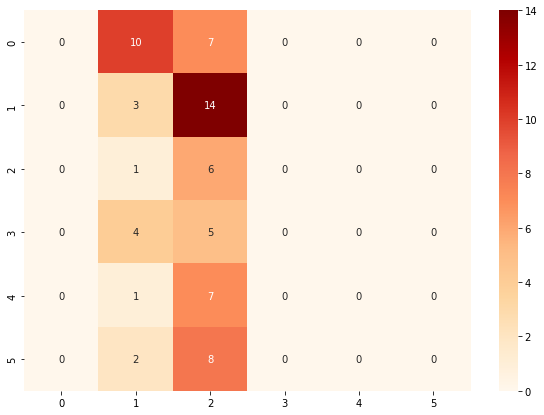

In [ ]:
import seaborn as sns
cmat_df = pd.DataFrame(cmat)
plt.figure(figsize = (10,7))
sns.heatmap(cmat_df, annot=True,cmap="OrRd")

# Training on glued images

In [8]:
!pip install pytorchcv --quiet
from pytorchcv.model_provider import get_model
from torch.nn.parameter import Parameter

# the gem implementation is kindly taken from here https://amaarora.github.io/2020/08/30/gempool.html#introduction

class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = Parameter(torch.ones(1)*p)
        self.eps = eps
    def gem(x, p=3, eps=1e-6):
      return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
    def forward(self, x):
        return gem(x, p=self.p, eps=self.eps)       
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'
# The Classifier class to predict classes.
class Classifier(torch.nn.Module):
  def __init__(self, inp, out, dropout):
    super(Classifier, self).__init__()
    self.features = nn.Flatten()
    self.drop = nn.Dropout(0.5)
    self.dropout = dropout
    self.out = nn.Linear(inp, out)

  def forward(self, x):
    x = self.features(x)
    if self.dropout:
      x = self.drop(x)
    out = self.out(x)
    return out

class FCN(torch.nn.Module):
  def __init__(self, base, inp, num_classes, dropout=True):
    super(FCN, self).__init__()
    self.base = base
    self.classifier = Classifier(inp, num_classes, dropout)
  
  def forward(self, x):
    
    x = self.base(x)
    x = self.classifier(x)
    return x

def create_model(name):
    model = get_model(name, pretrained=True) # we used the get model library since we can easly import from it any pytprch pre-trained model
    try:
      features = list(model.children())[-1].in_features
    except:
      features = list(model.children())[-1][-1].in_features
    model = nn.Sequential(*list(model.children())[:-1])
    model[0].final_pool = nn.Sequential(GeM())
    model = FCN(model, features, 5, dropout=True)
    return model



In [ ]:
# Creating a dataset for glued images.
# Loading statistics ( computed in the Pre-processing notebook)
mean = np.array([1.0-0.69026962 , 1.0-0.51690255 , 1.0-0.79142021])
std = np.array([0.33372767 , 0.40041865 , 0.3762294])

path_load = '/content/drive/MyDrive/DLMI/purple_36_128/train'
class GluedImagesDataset(Dataset):
    def __init__(self,df,path_load,standard=True,transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.path_load = path_load
        self.standard = standard

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.image_id
        
        images = cv2.cvtColor(cv2.imread(os.path.join(self.path_load,str(img_id)+'.png')), cv2.COLOR_BGR2RGB)
        images = 255-images # Making sure we don't have many black pixels.

        if self.transform is not None:   # Applying data augmentation
            images = self.transform(image=images)['image']

        images = images.astype(np.float32)      
        if self.standard ==True :          # Standardization of images
          images = (images/255.0 - mean)/std
        else:
          images/= 255
        images = images.transpose(2, 0, 1) # Transposing to it matches the tensor form.

        # Binning labels 
        label = np.zeros(5).astype(np.float32)
        label[:row.isup_grade] = 1.
        return torch.tensor(images), torch.tensor(label)



In [ ]:
# Data augmentation

transforms_train = A.Compose([
    A.ShiftScaleRotate(scale_limit=0.25, rotate_limit=180,p=0.5),
    A.Transpose(p=0.5),
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.OneOf([
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                             val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, 
                                   contrast_limit=0.2, p=0.5),
    ],p=0.9),    
])
transforms_val = A.Compose([])

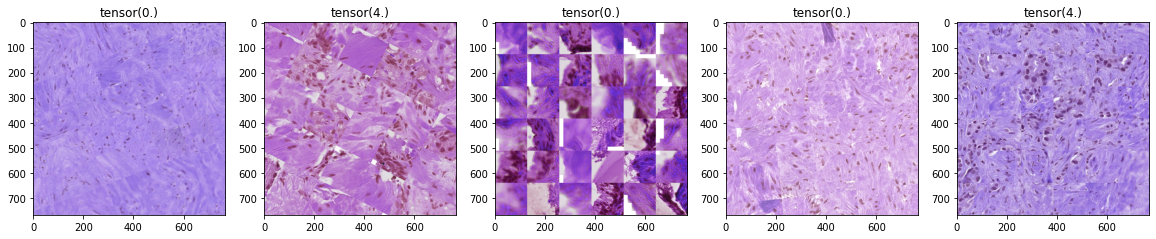

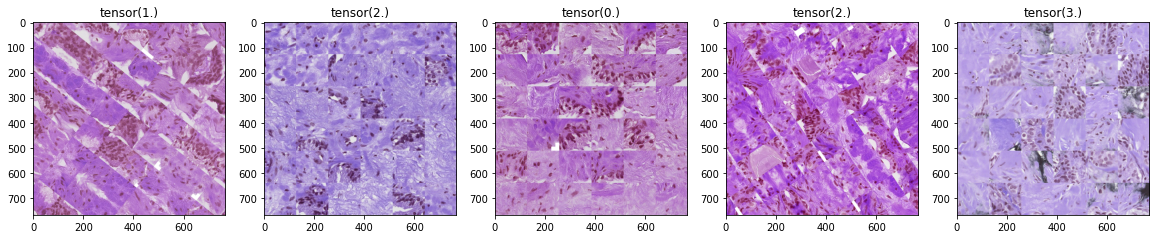

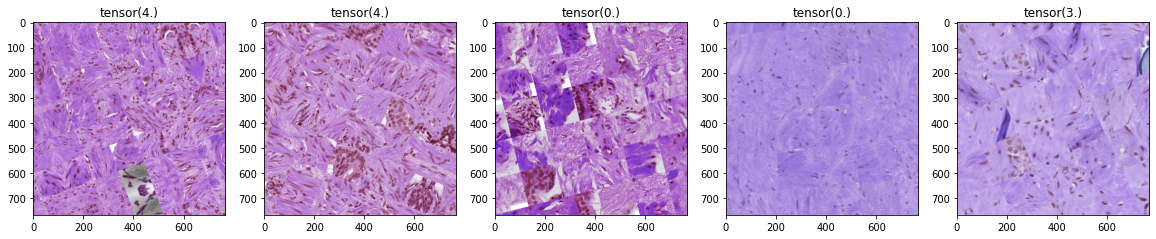

In [ ]:
dataset_show = GluedImagesDataset(df_train,path_load , transform=transforms_train,standard=False)
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
#originals = 255 - ((x.permute(0,2,3,1)*std + mean)*255.0).byte()
for i in range(3):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        axarr[p].imshow(1. - (img.transpose(0, 1)) .transpose(1,2).squeeze())
        axarr[p].set_title(str(sum(label)))

In [ ]:
criterion = nn.BCEWithLogitsLoss()
def train_one_epoch(loader, optimizer):

    model.train() # set the mode to train
    train_loss = []
    PREDS = []
    TARGETS = []
    all_targets = []
    all_predictions = []
    evolution = tqdm(loader)
    for i,(data, target) in enumerate(evolution) :

        data, target = data.to(device,dtype=torch.float), target.to(device)
        optimizer.zero_grad()
        model_out = model(data) # printing outputs probabilities
        loss = criterion(model_out, target)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.detach().cpu().numpy())        
        pred = model_out.sigmoid().sum(1).detach().round() # doing a sigmoid on the array to that values are between 0 and 1 and summing.
        PREDS.append(pred)
        TARGETS.append(target.sum(1))
        all_targets.extend(target.cpu().detach().numpy().tolist())
        all_predictions.extend(torch.sigmoid(model_out).cpu().detach().numpy().tolist())
        evolution.set_description('loss: %.5f' % (loss.detach().cpu().numpy()))
    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()
    val_roc_auc = roc_auc_score(all_targets, all_predictions,multi_class="ovr")
    print("###TRAIN Results###")
    print("Accuracy", (PREDS == TARGETS).mean() * 100 , " AUC ", val_roc_auc)
    return train_loss



In [ ]:
def valid_one_epoch(loader,):

    model.eval() # set the mode to evaluation
    val_loss = []
    LOGITS = []
    PREDS = []
    TARGETS = []
    
    all_targets = []
    all_predictions = []
    with torch.no_grad():
        for i,(data, target) in enumerate(tqdm(loader)):
            data, target = data.to(device,dtype=torch.float), target.to(device)
            model_out = model(data)
            loss = criterion(model_out, target)
            pred = model_out.sigmoid().sum(1).detach().round()
            LOGITS.append(model_out)
            PREDS.append(pred)
            TARGETS.append(target.sum(1))
            val_loss.append(loss.detach().cpu().numpy())
            all_targets.extend(target.cpu().detach().numpy().tolist())
            all_predictions.extend(torch.sigmoid(model_out).cpu().detach().numpy().tolist())
            
        val_loss = np.mean(val_loss)
    
    LOGITS = torch.cat(LOGITS).cpu().numpy()
    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()
    acc = (PREDS == TARGETS).mean() * 100.
    
    val_roc_auc = roc_auc_score(all_targets, all_predictions,multi_class="ovr")
    
    return val_loss, acc, val_roc_auc,TARGETS,PREDS

In [ ]:
batch_size = 4
num_workers = 4
out_dim = 5
lr = 1e-4
"Folds for efficientnetb0 = [0.8452702512050436, 0.8362555468723221, 0.8092795484121507, 0.7045720663191779, 0.7533063779247743]"

'Folds for efficientnetb1= [0.7703625068256625, 0.8317550693474599, 0.8032499177036154, 0.7519346041456181, 0.7763147970842552]'

In [ ]:
# efficientnetb0 model with mean/std pre-processing
 
n_epochs = 50
validation_folds=[]
for fold in range(5):
    print("Training on FOLD ",fold)

    # Selecting samples for both train and validation and preparing datasets

    train_samples = np.where((df_train['fold'] != fold))[0]
    valid_swamples = np.where((df_train['fold'] == fold))[0]

    df_train_fold  = df_train.loc[train_samples]
    df_valid_fold = df_train.loc[valid_samples]

    df_train_fold = df_train_fold.reset_index()
    df_valid_fold = df_valid_fold.reset_index()

    dataset_train = GluedImagesDataset(df_train_fold ,path_load , transform=transforms_train)
    dataset_valid = GluedImagesDataset(df_valid_fold ,path_load , transform=None)
    
    # Preparing train and validation loaders
    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, sampler=RandomSampler(dataset_train),num_workers=4)
    valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, sampler=SequentialSampler(dataset_valid),num_workers=4)

    # Initialize model
    model = create_model("efficientnet_b0")
    #model = create_model("resnet18")
    #model = create_model("seresnet18")
    #model = create_model("efficientnet_b1")
    #model = create_model("mobilenet_w1")
    #model = model.to(device)
    print(len(dataset_train), len(dataset_valid))

    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs-1)

    best_auc = 0
    for epoch in range(1, n_epochs+1):
        torch.cuda.empty_cache() 
        train_loss = train_one_epoch(train_loader, optimizer)
        scheduler.step()
        val_loss, val_acc, val_roc_auc,TARGETS,PREDS = valid_one_epoch(valid_loader)

        print(f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_loss):.5f}, val loss: {np.mean(val_loss):.5f}, acc: {(val_acc):.5f},     val_roc_auc: {(val_roc_auc):.5f},')
        # If we obtain an AUC higher than the current best , we save the model.

        if val_roc_auc > best_auc :
          best_auc = val_roc_auc
          #torch.save(model.state_dict(), os.path.join(f'/content/drive/MyDrive/DLMI/models/Efficientnetb0_128_36_with_std_all_data{fold}.pth'))
          # Computing the confusion matrix whenever we have a better AUC
          conf_matrix = confusion_matrix(TARGETS, PREDS).astype("uint")
          print(conf_matrix)
    
    validation_folds.append(best_auc)
print(f"Validation folds results {validation_folds}")
print(f"The AUC for all the folds {np.mean(validation_folds)}")

Training on FOLD  0
272 68


loss: 0.85572: 100%|██████████| 68/68 [00:17<00:00,  3.90it/s]


###TRAIN Results###
Accuracy 18.014705882352942  AUC  0.568068285739834


100%|██████████| 17/17 [00:02<00:00,  6.77it/s]


Epoch 1, lr: 0.0003000, train loss: 0.66196, val loss: 0.51082, acc: 20.58824,     val_roc_auc: 0.69385,
[[ 0 11  1  5  0  0]
 [ 0  6  8  3  0  0]
 [ 0  1  1  5  0  0]
 [ 0  0  2  7  0  0]
 [ 0  1  4  4  0  0]
 [ 0  0  3  6  0  0]]


loss: 0.37056: 100%|██████████| 68/68 [00:16<00:00,  4.12it/s]
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


###TRAIN Results###
Accuracy 15.441176470588236  AUC  0.6067503622888606


100%|██████████| 17/17 [00:02<00:00,  6.84it/s]


Epoch 2, lr: 0.0003000, train loss: 0.62326, val loss: 0.48057, acc: 25.00000,     val_roc_auc: 0.78477,
[[2 9 1 5 0 0]
 [0 7 5 5 0 0]
 [0 1 2 4 0 0]
 [0 1 2 6 0 0]
 [0 1 2 6 0 0]
 [0 0 1 8 0 0]]


loss: 0.99250: 100%|██████████| 68/68 [00:16<00:00,  4.11it/s]


###TRAIN Results###
Accuracy 19.485294117647058  AUC  0.6593407828974478


100%|██████████| 17/17 [00:02<00:00,  6.80it/s]


Epoch 3, lr: 0.0002997, train loss: 0.58037, val loss: 0.55172, acc: 23.52941,     val_roc_auc: 0.70728,


loss: 0.76852: 100%|██████████| 68/68 [00:16<00:00,  4.14it/s]


###TRAIN Results###
Accuracy 19.11764705882353  AUC  0.6353770032909732


100%|██████████| 17/17 [00:02<00:00,  6.82it/s]


Epoch 4, lr: 0.0002988, train loss: 0.59408, val loss: 0.55998, acc: 17.64706,     val_roc_auc: 0.71357,


loss: 0.78113: 100%|██████████| 68/68 [00:16<00:00,  4.09it/s]


###TRAIN Results###
Accuracy 18.014705882352942  AUC  0.630841625166445


100%|██████████| 17/17 [00:02<00:00,  5.92it/s]


Epoch 5, lr: 0.0002972, train loss: 0.58770, val loss: 0.48856, acc: 22.05882,     val_roc_auc: 0.73205,


loss: 0.38926: 100%|██████████| 68/68 [00:16<00:00,  4.10it/s]


###TRAIN Results###
Accuracy 19.485294117647058  AUC  0.6656464454739321


100%|██████████| 17/17 [00:02<00:00,  5.98it/s]


Epoch 6, lr: 0.0002951, train loss: 0.56000, val loss: 0.51337, acc: 19.11765,     val_roc_auc: 0.71356,


loss: 0.36989: 100%|██████████| 68/68 [00:17<00:00,  3.92it/s]


###TRAIN Results###
Accuracy 20.955882352941178  AUC  0.623186350412347


100%|██████████| 17/17 [00:02<00:00,  6.89it/s]


Epoch 7, lr: 0.0002924, train loss: 0.58619, val loss: 0.50479, acc: 25.00000,     val_roc_auc: 0.72727,


loss: 0.57252: 100%|██████████| 68/68 [00:16<00:00,  4.13it/s]


###TRAIN Results###
Accuracy 23.52941176470588  AUC  0.7187362522481252


100%|██████████| 17/17 [00:02<00:00,  6.90it/s]


Epoch 8, lr: 0.0002890, train loss: 0.53529, val loss: 0.57311, acc: 11.76471,     val_roc_auc: 0.60983,


loss: 0.50952: 100%|██████████| 68/68 [00:16<00:00,  4.09it/s]


###TRAIN Results###
Accuracy 19.485294117647058  AUC  0.6418855562988799


100%|██████████| 17/17 [00:02<00:00,  6.80it/s]


Epoch 9, lr: 0.0002851, train loss: 0.57447, val loss: 0.48185, acc: 29.41176,     val_roc_auc: 0.78083,


loss: 0.41905: 100%|██████████| 68/68 [00:17<00:00,  3.84it/s]


###TRAIN Results###
Accuracy 22.426470588235293  AUC  0.7465900619489829


100%|██████████| 17/17 [00:03<00:00,  4.76it/s]


Epoch 10, lr: 0.0002807, train loss: 0.50653, val loss: 0.44641, acc: 30.88235,     val_roc_auc: 0.81776,
[[7 7 3 0 0 0]
 [3 6 3 5 0 0]
 [0 2 0 3 2 0]
 [1 1 0 4 3 0]
 [0 1 1 3 4 0]
 [0 1 0 4 4 0]]


loss: 0.51462: 100%|██████████| 68/68 [00:20<00:00,  3.34it/s]


###TRAIN Results###
Accuracy 21.323529411764707  AUC  0.756527777364046


100%|██████████| 17/17 [00:02<00:00,  6.58it/s]


Epoch 11, lr: 0.0002757, train loss: 0.50345, val loss: 0.46462, acc: 29.41176,     val_roc_auc: 0.80169,


loss: 0.66059: 100%|██████████| 68/68 [00:16<00:00,  4.12it/s]


###TRAIN Results###
Accuracy 22.794117647058822  AUC  0.7337965555832687


100%|██████████| 17/17 [00:02<00:00,  6.59it/s]


Epoch 12, lr: 0.0002702, train loss: 0.51259, val loss: 0.45532, acc: 22.05882,     val_roc_auc: 0.78540,


loss: 0.51600: 100%|██████████| 68/68 [00:16<00:00,  4.09it/s]


###TRAIN Results###
Accuracy 26.47058823529412  AUC  0.7209149473636074


100%|██████████| 17/17 [00:02<00:00,  6.71it/s]


Epoch 13, lr: 0.0002642, train loss: 0.53126, val loss: 0.52496, acc: 19.11765,     val_roc_auc: 0.69284,


loss: 0.45795: 100%|██████████| 68/68 [00:16<00:00,  4.13it/s]


###TRAIN Results###
Accuracy 21.691176470588236  AUC  0.7745238226774169


100%|██████████| 17/17 [00:02<00:00,  6.72it/s]


Epoch 14, lr: 0.0002578, train loss: 0.48291, val loss: 0.46096, acc: 25.00000,     val_roc_auc: 0.79516,


loss: 0.44287: 100%|██████████| 68/68 [00:16<00:00,  4.09it/s]


###TRAIN Results###
Accuracy 24.264705882352942  AUC  0.7779103643707417


100%|██████████| 17/17 [00:02<00:00,  6.14it/s]


Epoch 15, lr: 0.0002508, train loss: 0.47656, val loss: 0.47014, acc: 23.52941,     val_roc_auc: 0.80084,


loss: 0.47233: 100%|██████████| 68/68 [00:18<00:00,  3.62it/s]


###TRAIN Results###
Accuracy 21.691176470588236  AUC  0.7501291095409618


100%|██████████| 17/17 [00:02<00:00,  5.67it/s]


Epoch 16, lr: 0.0002435, train loss: 0.50612, val loss: 0.46057, acc: 23.52941,     val_roc_auc: 0.78938,


loss: 0.28905: 100%|██████████| 68/68 [00:17<00:00,  3.93it/s]


###TRAIN Results###
Accuracy 26.10294117647059  AUC  0.8038768796936807


100%|██████████| 17/17 [00:02<00:00,  6.60it/s]


Epoch 17, lr: 0.0002358, train loss: 0.46249, val loss: 0.43197, acc: 26.47059,     val_roc_auc: 0.83757,
[[ 1 14  2  0  0  0]
 [ 1  9  6  1  0  0]
 [ 1  0  4  1  1  0]
 [ 0  2  2  3  2  0]
 [ 0  1  4  3  1  0]
 [ 0  1  0  5  3  0]]


loss: 1.24064: 100%|██████████| 68/68 [00:16<00:00,  4.05it/s]


###TRAIN Results###
Accuracy 28.676470588235293  AUC  0.8087008034238018


100%|██████████| 17/17 [00:03<00:00,  5.08it/s]


Epoch 18, lr: 0.0002278, train loss: 0.45431, val loss: 0.50928, acc: 33.82353,     val_roc_auc: 0.79272,


loss: 0.44670: 100%|██████████| 68/68 [00:18<00:00,  3.62it/s]


###TRAIN Results###
Accuracy 30.14705882352941  AUC  0.7969302302238587


100%|██████████| 17/17 [00:03<00:00,  5.36it/s]


Epoch 19, lr: 0.0002194, train loss: 0.46760, val loss: 0.53466, acc: 25.00000,     val_roc_auc: 0.74080,


loss: 0.31248: 100%|██████████| 68/68 [00:17<00:00,  3.84it/s]


###TRAIN Results###
Accuracy 25.0  AUC  0.812684039150323


100%|██████████| 17/17 [00:02<00:00,  6.66it/s]


Epoch 20, lr: 0.0002107, train loss: 0.44480, val loss: 0.51996, acc: 23.52941,     val_roc_auc: 0.75296,


loss: 0.47296: 100%|██████████| 68/68 [00:16<00:00,  4.05it/s]


###TRAIN Results###
Accuracy 29.044117647058826  AUC  0.8335520593143404


100%|██████████| 17/17 [00:02<00:00,  6.61it/s]


Epoch 21, lr: 0.0002018, train loss: 0.43103, val loss: 0.54993, acc: 19.11765,     val_roc_auc: 0.73067,


loss: 0.25750: 100%|██████████| 68/68 [00:16<00:00,  4.05it/s]


###TRAIN Results###
Accuracy 25.36764705882353  AUC  0.8466583144565842


100%|██████████| 17/17 [00:02<00:00,  6.53it/s]


Epoch 22, lr: 0.0001927, train loss: 0.41529, val loss: 0.46792, acc: 14.70588,     val_roc_auc: 0.82496,


loss: 0.64918: 100%|██████████| 68/68 [00:16<00:00,  4.04it/s]


###TRAIN Results###
Accuracy 27.573529411764707  AUC  0.8209585266822197


100%|██████████| 17/17 [00:02<00:00,  6.52it/s]


Epoch 23, lr: 0.0001834, train loss: 0.44369, val loss: 0.46933, acc: 20.58824,     val_roc_auc: 0.81194,


loss: 0.37827: 100%|██████████| 68/68 [00:17<00:00,  3.97it/s]


###TRAIN Results###
Accuracy 31.25  AUC  0.844432968047134


100%|██████████| 17/17 [00:02<00:00,  6.71it/s]


Epoch 24, lr: 0.0001739, train loss: 0.41699, val loss: 0.47516, acc: 32.35294,     val_roc_auc: 0.80402,


loss: 0.45322: 100%|██████████| 68/68 [00:16<00:00,  4.05it/s]


###TRAIN Results###
Accuracy 27.573529411764707  AUC  0.8120928903364923


100%|██████████| 17/17 [00:02<00:00,  6.61it/s]


Epoch 25, lr: 0.0001644, train loss: 0.44681, val loss: 0.61930, acc: 20.58824,     val_roc_auc: 0.69308,


loss: 0.24278: 100%|██████████| 68/68 [00:16<00:00,  4.04it/s]


###TRAIN Results###
Accuracy 32.720588235294116  AUC  0.8601498434911996


100%|██████████| 17/17 [00:02<00:00,  6.73it/s]


Epoch 26, lr: 0.0001548, train loss: 0.39537, val loss: 0.56994, acc: 17.64706,     val_roc_auc: 0.74909,


loss: 0.32185: 100%|██████████| 68/68 [00:16<00:00,  4.08it/s]


###TRAIN Results###
Accuracy 32.35294117647059  AUC  0.861157993562139


100%|██████████| 17/17 [00:02<00:00,  6.87it/s]


Epoch 27, lr: 0.0001452, train loss: 0.39948, val loss: 0.53828, acc: 25.00000,     val_roc_auc: 0.78421,


loss: 0.43689: 100%|██████████| 68/68 [00:16<00:00,  4.08it/s]


###TRAIN Results###
Accuracy 35.661764705882355  AUC  0.8706946501998919


100%|██████████| 17/17 [00:02<00:00,  6.58it/s]


Epoch 28, lr: 0.0001356, train loss: 0.38927, val loss: 0.57455, acc: 23.52941,     val_roc_auc: 0.74299,


loss: 0.42441: 100%|██████████| 68/68 [00:16<00:00,  4.01it/s]


###TRAIN Results###
Accuracy 33.088235294117645  AUC  0.8946675178060088


100%|██████████| 17/17 [00:02<00:00,  6.77it/s]


Epoch 29, lr: 0.0001261, train loss: 0.35376, val loss: 0.54101, acc: 23.52941,     val_roc_auc: 0.78536,


loss: 0.22256: 100%|██████████| 68/68 [00:16<00:00,  4.03it/s]


###TRAIN Results###
Accuracy 45.955882352941174  AUC  0.8980348918412439


100%|██████████| 17/17 [00:03<00:00,  5.03it/s]


Epoch 30, lr: 0.0001166, train loss: 0.34583, val loss: 0.51599, acc: 20.58824,     val_roc_auc: 0.77136,


loss: 0.13939: 100%|██████████| 68/68 [00:19<00:00,  3.51it/s]


###TRAIN Results###
Accuracy 38.970588235294116  AUC  0.9068004319293573


100%|██████████| 17/17 [00:02<00:00,  6.49it/s]


Epoch 31, lr: 0.0001073, train loss: 0.32851, val loss: 0.56219, acc: 19.11765,     val_roc_auc: 0.76119,


loss: 0.29611: 100%|██████████| 68/68 [00:16<00:00,  4.10it/s]


###TRAIN Results###
Accuracy 49.63235294117647  AUC  0.936399572371244


100%|██████████| 17/17 [00:02<00:00,  6.75it/s]


Epoch 32, lr: 0.0000982, train loss: 0.27136, val loss: 0.59315, acc: 20.58824,     val_roc_auc: 0.78864,


loss: 0.73836: 100%|██████████| 68/68 [00:16<00:00,  4.07it/s]


###TRAIN Results###
Accuracy 44.85294117647059  AUC  0.924971623857266


100%|██████████| 17/17 [00:02<00:00,  6.92it/s]


Epoch 33, lr: 0.0000893, train loss: 0.29935, val loss: 0.46707, acc: 26.47059,     val_roc_auc: 0.81653,


loss: 0.16648: 100%|██████████| 68/68 [00:18<00:00,  3.75it/s]


###TRAIN Results###
Accuracy 50.73529411764706  AUC  0.917350326271411


100%|██████████| 17/17 [00:02<00:00,  6.64it/s]


Epoch 34, lr: 0.0000806, train loss: 0.30854, val loss: 0.65549, acc: 22.05882,     val_roc_auc: 0.76104,


loss: 0.32946: 100%|██████████| 68/68 [00:16<00:00,  4.03it/s]


###TRAIN Results###
Accuracy 46.32352941176471  AUC  0.9205724956285349


100%|██████████| 17/17 [00:02<00:00,  6.67it/s]


Epoch 35, lr: 0.0000722, train loss: 0.30408, val loss: 0.52385, acc: 26.47059,     val_roc_auc: 0.78481,


loss: 0.14832: 100%|██████████| 68/68 [00:16<00:00,  4.04it/s]


###TRAIN Results###
Accuracy 44.11764705882353  AUC  0.9349698949364631


100%|██████████| 17/17 [00:02<00:00,  6.76it/s]


Epoch 36, lr: 0.0000642, train loss: 0.27261, val loss: 0.48707, acc: 26.47059,     val_roc_auc: 0.83258,


loss: 0.28380: 100%|██████████| 68/68 [00:16<00:00,  4.08it/s]


###TRAIN Results###
Accuracy 56.61764705882353  AUC  0.9566174406979912


100%|██████████| 17/17 [00:02<00:00,  6.74it/s]


Epoch 37, lr: 0.0000565, train loss: 0.23272, val loss: 0.57247, acc: 26.47059,     val_roc_auc: 0.79111,


loss: 0.30247: 100%|██████████| 68/68 [00:16<00:00,  4.08it/s]


###TRAIN Results###
Accuracy 50.0  AUC  0.9417043010930716


100%|██████████| 17/17 [00:02<00:00,  6.66it/s]


Epoch 38, lr: 0.0000492, train loss: 0.26320, val loss: 0.57800, acc: 20.58824,     val_roc_auc: 0.77330,


loss: 0.19297: 100%|██████████| 68/68 [00:16<00:00,  4.09it/s]


###TRAIN Results###
Accuracy 54.779411764705884  AUC  0.948735270648481


100%|██████████| 17/17 [00:02<00:00,  6.72it/s]


Epoch 39, lr: 0.0000422, train loss: 0.24187, val loss: 0.54168, acc: 20.58824,     val_roc_auc: 0.80271,


loss: 0.14129: 100%|██████████| 68/68 [00:16<00:00,  4.02it/s]


###TRAIN Results###
Accuracy 56.25  AUC  0.9545803722229623


100%|██████████| 17/17 [00:02<00:00,  6.61it/s]


Epoch 40, lr: 0.0000358, train loss: 0.23179, val loss: 0.57755, acc: 25.00000,     val_roc_auc: 0.80340,


loss: 0.34948: 100%|██████████| 68/68 [00:17<00:00,  3.82it/s]


###TRAIN Results###
Accuracy 55.88235294117647  AUC  0.9577997042204058


100%|██████████| 17/17 [00:03<00:00,  5.28it/s]


Epoch 41, lr: 0.0000298, train loss: 0.22279, val loss: 0.57300, acc: 25.00000,     val_roc_auc: 0.81999,


loss: 0.12143: 100%|██████████| 68/68 [00:18<00:00,  3.64it/s]


###TRAIN Results###
Accuracy 56.61764705882353  AUC  0.967670137437608


100%|██████████| 17/17 [00:02<00:00,  5.77it/s]


Epoch 42, lr: 0.0000243, train loss: 0.19611, val loss: 0.54009, acc: 23.52941,     val_roc_auc: 0.81203,


loss: 0.14836: 100%|██████████| 68/68 [00:17<00:00,  3.83it/s]


###TRAIN Results###
Accuracy 58.82352941176471  AUC  0.9660836188828734


100%|██████████| 17/17 [00:02<00:00,  6.58it/s]


Epoch 43, lr: 0.0000193, train loss: 0.19734, val loss: 0.55190, acc: 20.58824,     val_roc_auc: 0.80583,


loss: 0.33139: 100%|██████████| 68/68 [00:16<00:00,  4.05it/s]


###TRAIN Results###
Accuracy 57.720588235294116  AUC  0.9488190105117029


100%|██████████| 17/17 [00:02<00:00,  6.75it/s]


Epoch 44, lr: 0.0000149, train loss: 0.23631, val loss: 0.58234, acc: 27.94118,     val_roc_auc: 0.80114,


loss: 0.16086: 100%|██████████| 68/68 [00:16<00:00,  4.08it/s]


###TRAIN Results###
Accuracy 68.01470588235294  AUC  0.9792425749527778


100%|██████████| 17/17 [00:02<00:00,  6.56it/s]


Epoch 45, lr: 0.0000110, train loss: 0.16037, val loss: 0.55312, acc: 30.88235,     val_roc_auc: 0.81320,


loss: 0.09587: 100%|██████████| 68/68 [00:16<00:00,  4.05it/s]


###TRAIN Results###
Accuracy 68.38235294117648  AUC  0.9805602189564155


100%|██████████| 17/17 [00:02<00:00,  6.61it/s]


Epoch 46, lr: 0.0000076, train loss: 0.16205, val loss: 0.57130, acc: 25.00000,     val_roc_auc: 0.81427,


loss: 0.21207: 100%|██████████| 68/68 [00:16<00:00,  4.06it/s]


###TRAIN Results###
Accuracy 65.44117647058823  AUC  0.9768220880494273


100%|██████████| 17/17 [00:02<00:00,  6.73it/s]


Epoch 47, lr: 0.0000049, train loss: 0.17460, val loss: 0.59443, acc: 26.47059,     val_roc_auc: 0.81588,


loss: 0.19080: 100%|██████████| 68/68 [00:16<00:00,  4.06it/s]


###TRAIN Results###
Accuracy 65.80882352941177  AUC  0.9808846884102188


100%|██████████| 17/17 [00:02<00:00,  6.76it/s]


Epoch 48, lr: 0.0000028, train loss: 0.16134, val loss: 0.60090, acc: 26.47059,     val_roc_auc: 0.81028,


loss: 0.13935: 100%|██████████| 68/68 [00:16<00:00,  4.05it/s]


###TRAIN Results###
Accuracy 66.17647058823529  AUC  0.978098976708704


100%|██████████| 17/17 [00:02<00:00,  6.62it/s]


Epoch 49, lr: 0.0000012, train loss: 0.16217, val loss: 0.60042, acc: 26.47059,     val_roc_auc: 0.81772,


loss: 0.04387: 100%|██████████| 68/68 [00:16<00:00,  4.05it/s]


###TRAIN Results###
Accuracy 64.70588235294117  AUC  0.978260521254756


100%|██████████| 17/17 [00:02<00:00,  6.65it/s]


Epoch 50, lr: 0.0000003, train loss: 0.16113, val loss: 0.58874, acc: 29.41176,     val_roc_auc: 0.81958,
Training on FOLD  1
272 68


loss: 0.78684: 100%|██████████| 68/68 [00:16<00:00,  4.09it/s]


###TRAIN Results###
Accuracy 16.176470588235293  AUC  0.5734940654474793


100%|██████████| 17/17 [00:02<00:00,  6.75it/s]


Epoch 1, lr: 0.0003000, train loss: 0.65217, val loss: 0.55656, acc: 19.11765,     val_roc_auc: 0.63067,
[[ 0  6 11  0  0  0]
 [ 0  6 11  0  0  0]
 [ 0  0  7  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  1  7  1  0  0]
 [ 0  1  5  3  0  0]]


loss: 0.71049: 100%|██████████| 68/68 [00:16<00:00,  4.07it/s]
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


###TRAIN Results###
Accuracy 18.014705882352942  AUC  0.5910276095172358


100%|██████████| 17/17 [00:02<00:00,  6.48it/s]


Epoch 2, lr: 0.0003000, train loss: 0.63857, val loss: 0.49196, acc: 20.58824,     val_roc_auc: 0.79631,
[[ 0 11  5  1  0  0]
 [ 0  5  9  3  0  0]
 [ 0  1  4  2  0  0]
 [ 0  0  4  5  0  0]
 [ 0  0  5  4  0  0]
 [ 0  0  3  6  0  0]]


loss: 0.48349: 100%|██████████| 68/68 [00:16<00:00,  4.07it/s]


###TRAIN Results###
Accuracy 20.22058823529412  AUC  0.6318510207488491


100%|██████████| 17/17 [00:02<00:00,  6.76it/s]


Epoch 3, lr: 0.0002997, train loss: 0.60235, val loss: 0.56117, acc: 25.00000,     val_roc_auc: 0.74972,


loss: 0.58260: 100%|██████████| 68/68 [00:16<00:00,  4.03it/s]


###TRAIN Results###
Accuracy 17.647058823529413  AUC  0.6510973203820516


100%|██████████| 17/17 [00:02<00:00,  6.62it/s]


Epoch 4, lr: 0.0002988, train loss: 0.58649, val loss: 0.46254, acc: 14.70588,     val_roc_auc: 0.84732,
[[ 0  0 16  1  0  0]
 [ 0  0 11  6  0  0]
 [ 0  0  4  2  1  0]
 [ 0  0  1  5  3  0]
 [ 0  0  3  5  1  0]
 [ 0  0  2  2  5  0]]


loss: 0.32921: 100%|██████████| 68/68 [00:16<00:00,  4.06it/s]


###TRAIN Results###
Accuracy 21.323529411764707  AUC  0.7017747813748494


100%|██████████| 17/17 [00:02<00:00,  6.50it/s]


Epoch 5, lr: 0.0002972, train loss: 0.54551, val loss: 0.45980, acc: 22.05882,     val_roc_auc: 0.85173,
[[ 0 12  4  1  0  0]
 [ 0  6  8  3  0  0]
 [ 0  1  4  2  0  0]
 [ 0  0  4  5  0  0]
 [ 0  0  4  5  0  0]
 [ 0  0  3  6  0  0]]


loss: 0.49228: 100%|██████████| 68/68 [00:16<00:00,  4.02it/s]


###TRAIN Results###
Accuracy 15.073529411764705  AUC  0.6871507085674666


100%|██████████| 17/17 [00:02<00:00,  6.64it/s]


Epoch 6, lr: 0.0002951, train loss: 0.55684, val loss: 0.53781, acc: 19.11765,     val_roc_auc: 0.75333,


loss: 0.47811: 100%|██████████| 68/68 [00:16<00:00,  4.05it/s]


###TRAIN Results###
Accuracy 18.38235294117647  AUC  0.701890677315615


100%|██████████| 17/17 [00:02<00:00,  6.61it/s]


Epoch 7, lr: 0.0002924, train loss: 0.53214, val loss: 0.45459, acc: 26.47059,     val_roc_auc: 0.83469,


loss: 0.50670: 100%|██████████| 68/68 [00:16<00:00,  4.05it/s]


###TRAIN Results###
Accuracy 22.426470588235293  AUC  0.7194783949970945


100%|██████████| 17/17 [00:02<00:00,  6.67it/s]


Epoch 8, lr: 0.0002890, train loss: 0.53828, val loss: 0.53054, acc: 27.94118,     val_roc_auc: 0.77565,


loss: 0.37427: 100%|██████████| 68/68 [00:16<00:00,  4.05it/s]


###TRAIN Results###
Accuracy 24.63235294117647  AUC  0.7557174127275748


100%|██████████| 17/17 [00:02<00:00,  6.60it/s]


Epoch 9, lr: 0.0002851, train loss: 0.49949, val loss: 0.40902, acc: 25.00000,     val_roc_auc: 0.84944,


loss: 0.28257: 100%|██████████| 68/68 [00:18<00:00,  3.68it/s]


###TRAIN Results###
Accuracy 21.691176470588236  AUC  0.7304698880060225


100%|██████████| 17/17 [00:02<00:00,  6.59it/s]


Epoch 10, lr: 0.0002807, train loss: 0.52780, val loss: 0.48822, acc: 25.00000,     val_roc_auc: 0.76118,


loss: 0.35538: 100%|██████████| 68/68 [00:16<00:00,  4.04it/s]


###TRAIN Results###
Accuracy 24.264705882352942  AUC  0.7545321015864999


100%|██████████| 17/17 [00:02<00:00,  6.57it/s]


Epoch 11, lr: 0.0002757, train loss: 0.51033, val loss: 0.49179, acc: 20.58824,     val_roc_auc: 0.77904,


loss: 0.49701: 100%|██████████| 68/68 [00:16<00:00,  4.06it/s]


###TRAIN Results###
Accuracy 23.161764705882355  AUC  0.7850965183061988


100%|██████████| 17/17 [00:02<00:00,  6.60it/s]


Epoch 12, lr: 0.0002702, train loss: 0.47064, val loss: 0.46773, acc: 26.47059,     val_roc_auc: 0.81248,


loss: 0.44982: 100%|██████████| 68/68 [00:18<00:00,  3.59it/s]


###TRAIN Results###
Accuracy 24.264705882352942  AUC  0.765128689761178


100%|██████████| 17/17 [00:02<00:00,  6.59it/s]


Epoch 13, lr: 0.0002642, train loss: 0.49485, val loss: 0.48135, acc: 22.05882,     val_roc_auc: 0.79871,


loss: 0.35801: 100%|██████████| 68/68 [00:17<00:00,  3.79it/s]


###TRAIN Results###
Accuracy 25.36764705882353  AUC  0.7915296091556927


100%|██████████| 17/17 [00:03<00:00,  5.65it/s]


Epoch 14, lr: 0.0002578, train loss: 0.47022, val loss: 0.42203, acc: 22.05882,     val_roc_auc: 0.84228,


loss: 0.52994: 100%|██████████| 68/68 [00:17<00:00,  3.85it/s]


###TRAIN Results###
Accuracy 24.264705882352942  AUC  0.7400488786944299


100%|██████████| 17/17 [00:02<00:00,  6.57it/s]


Epoch 15, lr: 0.0002508, train loss: 0.51292, val loss: 0.45792, acc: 27.94118,     val_roc_auc: 0.80891,


loss: 0.42883: 100%|██████████| 68/68 [00:17<00:00,  3.81it/s]


###TRAIN Results###
Accuracy 25.735294117647058  AUC  0.7908445120476537


100%|██████████| 17/17 [00:02<00:00,  6.64it/s]


Epoch 16, lr: 0.0002435, train loss: 0.47435, val loss: 0.40718, acc: 32.35294,     val_roc_auc: 0.86154,
[[7 9 1 0 0 0]
 [4 8 2 3 0 0]
 [1 3 1 0 2 0]
 [1 1 3 3 1 0]
 [0 1 3 2 3 0]
 [0 0 2 3 4 0]]


loss: 0.42921: 100%|██████████| 68/68 [00:16<00:00,  4.04it/s]


###TRAIN Results###
Accuracy 25.36764705882353  AUC  0.7771146942409655


100%|██████████| 17/17 [00:02<00:00,  6.61it/s]


Epoch 17, lr: 0.0002358, train loss: 0.48282, val loss: 0.40223, acc: 33.82353,     val_roc_auc: 0.87290,
[[ 1 13  3  0  0  0]
 [ 1 11  4  0  1  0]
 [ 0  2  3  1  1  0]
 [ 0  1  3  5  0  0]
 [ 0  0  4  2  3  0]
 [ 0  0  2  3  4  0]]


loss: 0.61504: 100%|██████████| 68/68 [00:16<00:00,  4.04it/s]


###TRAIN Results###
Accuracy 27.205882352941174  AUC  0.8136475527587044


100%|██████████| 17/17 [00:02<00:00,  6.57it/s]


Epoch 18, lr: 0.0002278, train loss: 0.44202, val loss: 0.50076, acc: 35.29412,     val_roc_auc: 0.78711,


loss: 0.32040: 100%|██████████| 68/68 [00:16<00:00,  4.02it/s]


###TRAIN Results###
Accuracy 31.25  AUC  0.8426090430397256


100%|██████████| 17/17 [00:02<00:00,  6.46it/s]


Epoch 19, lr: 0.0002194, train loss: 0.42012, val loss: 0.50340, acc: 23.52941,     val_roc_auc: 0.80069,


loss: 0.38955: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]


###TRAIN Results###
Accuracy 28.308823529411764  AUC  0.8131939931619909


100%|██████████| 17/17 [00:02<00:00,  6.55it/s]


Epoch 20, lr: 0.0002107, train loss: 0.44996, val loss: 0.39803, acc: 27.94118,     val_roc_auc: 0.86037,


loss: 0.32644: 100%|██████████| 68/68 [00:16<00:00,  4.01it/s]


###TRAIN Results###
Accuracy 25.36764705882353  AUC  0.8113819726523849


100%|██████████| 17/17 [00:02<00:00,  6.67it/s]


Epoch 21, lr: 0.0002018, train loss: 0.45431, val loss: 0.41667, acc: 25.00000,     val_roc_auc: 0.84046,


loss: 0.56955: 100%|██████████| 68/68 [00:16<00:00,  4.03it/s]


###TRAIN Results###
Accuracy 28.308823529411764  AUC  0.8321678620259723


100%|██████████| 17/17 [00:02<00:00,  6.78it/s]


Epoch 22, lr: 0.0001927, train loss: 0.43276, val loss: 0.46877, acc: 30.88235,     val_roc_auc: 0.78425,


loss: 0.38289: 100%|██████████| 68/68 [00:16<00:00,  4.06it/s]


###TRAIN Results###
Accuracy 31.61764705882353  AUC  0.8416602264503869


100%|██████████| 17/17 [00:02<00:00,  6.54it/s]


Epoch 23, lr: 0.0001834, train loss: 0.42025, val loss: 0.42647, acc: 30.88235,     val_roc_auc: 0.82090,


loss: 0.62710: 100%|██████████| 68/68 [00:16<00:00,  4.04it/s]


###TRAIN Results###
Accuracy 31.985294117647058  AUC  0.8138645044659581


100%|██████████| 17/17 [00:02<00:00,  6.67it/s]


Epoch 24, lr: 0.0001739, train loss: 0.44560, val loss: 0.42631, acc: 32.35294,     val_roc_auc: 0.82830,


loss: 0.56157: 100%|██████████| 68/68 [00:16<00:00,  4.04it/s]


###TRAIN Results###
Accuracy 34.92647058823529  AUC  0.8861523213466862


100%|██████████| 17/17 [00:02<00:00,  6.20it/s]


Epoch 25, lr: 0.0001644, train loss: 0.36649, val loss: 0.42315, acc: 30.88235,     val_roc_auc: 0.86042,


loss: 0.37000: 100%|██████████| 68/68 [00:16<00:00,  4.03it/s]


###TRAIN Results###
Accuracy 29.411764705882355  AUC  0.8841624275326886


100%|██████████| 17/17 [00:02<00:00,  6.53it/s]


Epoch 26, lr: 0.0001548, train loss: 0.36858, val loss: 0.61350, acc: 25.00000,     val_roc_auc: 0.76458,


loss: 0.40491: 100%|██████████| 68/68 [00:16<00:00,  4.01it/s]


###TRAIN Results###
Accuracy 29.77941176470588  AUC  0.8562241369429383


100%|██████████| 17/17 [00:02<00:00,  6.66it/s]


Epoch 27, lr: 0.0001452, train loss: 0.40572, val loss: 0.47935, acc: 23.52941,     val_roc_auc: 0.79403,


loss: 1.13098: 100%|██████████| 68/68 [00:16<00:00,  4.05it/s]


###TRAIN Results###
Accuracy 40.07352941176471  AUC  0.8979182293048119


100%|██████████| 17/17 [00:02<00:00,  6.67it/s]


Epoch 28, lr: 0.0001356, train loss: 0.34091, val loss: 0.41846, acc: 29.41176,     val_roc_auc: 0.83296,


loss: 0.35835: 100%|██████████| 68/68 [00:16<00:00,  4.04it/s]


###TRAIN Results###
Accuracy 37.5  AUC  0.907103519368398


100%|██████████| 17/17 [00:02<00:00,  6.43it/s]


Epoch 29, lr: 0.0001261, train loss: 0.33246, val loss: 0.49017, acc: 30.88235,     val_roc_auc: 0.79942,


loss: 0.10758: 100%|██████████| 68/68 [00:16<00:00,  4.03it/s]


###TRAIN Results###
Accuracy 45.220588235294116  AUC  0.9008556629755923


100%|██████████| 17/17 [00:03<00:00,  5.28it/s]


Epoch 30, lr: 0.0001166, train loss: 0.33347, val loss: 0.52804, acc: 26.47059,     val_roc_auc: 0.79117,


loss: 0.37459: 100%|██████████| 68/68 [00:19<00:00,  3.47it/s]


###TRAIN Results###
Accuracy 43.01470588235294  AUC  0.9139793037697158


100%|██████████| 17/17 [00:02<00:00,  6.56it/s]


Epoch 31, lr: 0.0001073, train loss: 0.32095, val loss: 0.43337, acc: 32.35294,     val_roc_auc: 0.83576,


loss: 0.23101: 100%|██████████| 68/68 [00:17<00:00,  3.89it/s]


###TRAIN Results###
Accuracy 39.705882352941174  AUC  0.9266411680922179


100%|██████████| 17/17 [00:02<00:00,  6.69it/s]


Epoch 32, lr: 0.0000982, train loss: 0.29866, val loss: 0.47951, acc: 33.82353,     val_roc_auc: 0.85202,


loss: 0.19680: 100%|██████████| 68/68 [00:16<00:00,  4.08it/s]


###TRAIN Results###
Accuracy 50.0  AUC  0.9311248651712558


100%|██████████| 17/17 [00:02<00:00,  6.67it/s]


Epoch 33, lr: 0.0000893, train loss: 0.28914, val loss: 0.49717, acc: 33.82353,     val_roc_auc: 0.78640,


loss: 0.18322: 100%|██████████| 68/68 [00:17<00:00,  4.00it/s]


###TRAIN Results###
Accuracy 44.48529411764706  AUC  0.9098181681313868


100%|██████████| 17/17 [00:02<00:00,  6.71it/s]


Epoch 34, lr: 0.0000806, train loss: 0.32560, val loss: 0.40843, acc: 30.88235,     val_roc_auc: 0.83419,


loss: 0.43981: 100%|██████████| 68/68 [00:16<00:00,  4.05it/s]


###TRAIN Results###
Accuracy 53.67647058823529  AUC  0.9381003205630905


100%|██████████| 17/17 [00:02<00:00,  6.67it/s]


Epoch 35, lr: 0.0000722, train loss: 0.26652, val loss: 0.45470, acc: 26.47059,     val_roc_auc: 0.81935,


loss: 0.57069: 100%|██████████| 68/68 [00:17<00:00,  3.95it/s]


###TRAIN Results###
Accuracy 45.955882352941174  AUC  0.9234171509850831


100%|██████████| 17/17 [00:02<00:00,  6.50it/s]


Epoch 36, lr: 0.0000642, train loss: 0.30691, val loss: 0.42867, acc: 30.88235,     val_roc_auc: 0.83874,


loss: 0.18547: 100%|██████████| 68/68 [00:16<00:00,  4.01it/s]


###TRAIN Results###
Accuracy 51.470588235294116  AUC  0.9474267160662736


100%|██████████| 17/17 [00:02<00:00,  6.41it/s]


Epoch 37, lr: 0.0000565, train loss: 0.25047, val loss: 0.39675, acc: 35.29412,     val_roc_auc: 0.86140,


loss: 0.12315: 100%|██████████| 68/68 [00:16<00:00,  4.02it/s]


###TRAIN Results###
Accuracy 53.30882352941176  AUC  0.9416345643423227


100%|██████████| 17/17 [00:02<00:00,  6.51it/s]


Epoch 38, lr: 0.0000492, train loss: 0.26812, val loss: 0.44214, acc: 32.35294,     val_roc_auc: 0.83007,


loss: 0.11443: 100%|██████████| 68/68 [00:16<00:00,  4.06it/s]


###TRAIN Results###
Accuracy 51.470588235294116  AUC  0.9511587215653087


100%|██████████| 17/17 [00:02<00:00,  6.53it/s]


Epoch 39, lr: 0.0000422, train loss: 0.24550, val loss: 0.40176, acc: 35.29412,     val_roc_auc: 0.85037,


loss: 0.32690: 100%|██████████| 68/68 [00:16<00:00,  4.00it/s]


###TRAIN Results###
Accuracy 55.14705882352941  AUC  0.9523078812772594


100%|██████████| 17/17 [00:02<00:00,  6.58it/s]


Epoch 40, lr: 0.0000358, train loss: 0.23921, val loss: 0.42950, acc: 36.76471,     val_roc_auc: 0.83152,


loss: 0.23032: 100%|██████████| 68/68 [00:16<00:00,  4.03it/s]


###TRAIN Results###
Accuracy 54.779411764705884  AUC  0.9669391250679901


100%|██████████| 17/17 [00:02<00:00,  5.69it/s]


Epoch 41, lr: 0.0000298, train loss: 0.20478, val loss: 0.40884, acc: 32.35294,     val_roc_auc: 0.85281,


loss: 0.13956: 100%|██████████| 68/68 [00:16<00:00,  4.03it/s]


###TRAIN Results###
Accuracy 63.23529411764706  AUC  0.9676316757305372


100%|██████████| 17/17 [00:02<00:00,  6.52it/s]


Epoch 42, lr: 0.0000243, train loss: 0.19467, val loss: 0.47064, acc: 29.41176,     val_roc_auc: 0.81264,


loss: 0.14894: 100%|██████████| 68/68 [00:16<00:00,  4.02it/s]


###TRAIN Results###
Accuracy 65.07352941176471  AUC  0.9689162267987352


100%|██████████| 17/17 [00:02<00:00,  6.56it/s]


Epoch 43, lr: 0.0000193, train loss: 0.19472, val loss: 0.45448, acc: 25.00000,     val_roc_auc: 0.84266,


loss: 0.09586: 100%|██████████| 68/68 [00:17<00:00,  4.00it/s]


###TRAIN Results###
Accuracy 65.44117647058823  AUC  0.9707512619493304


100%|██████████| 17/17 [00:02<00:00,  6.57it/s]


Epoch 44, lr: 0.0000149, train loss: 0.19332, val loss: 0.43982, acc: 38.23529,     val_roc_auc: 0.85408,


loss: 0.15047: 100%|██████████| 68/68 [00:16<00:00,  4.02it/s]


###TRAIN Results###
Accuracy 59.19117647058824  AUC  0.9656892853102109


100%|██████████| 17/17 [00:02<00:00,  6.52it/s]


Epoch 45, lr: 0.0000110, train loss: 0.19979, val loss: 0.46215, acc: 30.88235,     val_roc_auc: 0.84298,


loss: 0.40788: 100%|██████████| 68/68 [00:16<00:00,  4.02it/s]


###TRAIN Results###
Accuracy 63.60294117647059  AUC  0.9721116370269378


100%|██████████| 17/17 [00:02<00:00,  6.55it/s]


Epoch 46, lr: 0.0000076, train loss: 0.18764, val loss: 0.47821, acc: 26.47059,     val_roc_auc: 0.83320,


loss: 0.13054: 100%|██████████| 68/68 [00:17<00:00,  3.93it/s]


###TRAIN Results###
Accuracy 65.80882352941177  AUC  0.9778468675714972


100%|██████████| 17/17 [00:02<00:00,  6.50it/s]


Epoch 47, lr: 0.0000049, train loss: 0.16938, val loss: 0.45768, acc: 29.41176,     val_roc_auc: 0.83935,


loss: 0.56020: 100%|██████████| 68/68 [00:16<00:00,  4.02it/s]


###TRAIN Results###
Accuracy 65.44117647058823  AUC  0.9737143865015112


100%|██████████| 17/17 [00:02<00:00,  6.65it/s]


Epoch 48, lr: 0.0000028, train loss: 0.18103, val loss: 0.44193, acc: 33.82353,     val_roc_auc: 0.84040,


loss: 0.14314: 100%|██████████| 68/68 [00:17<00:00,  3.79it/s]


###TRAIN Results###
Accuracy 62.86764705882353  AUC  0.9710604074152298


100%|██████████| 17/17 [00:03<00:00,  4.34it/s]


Epoch 49, lr: 0.0000012, train loss: 0.18871, val loss: 0.45834, acc: 32.35294,     val_roc_auc: 0.84986,


loss: 0.11658: 100%|██████████| 68/68 [00:19<00:00,  3.52it/s]


###TRAIN Results###
Accuracy 65.07352941176471  AUC  0.9799904561419037


100%|██████████| 17/17 [00:02<00:00,  6.53it/s]


Epoch 50, lr: 0.0000003, train loss: 0.15816, val loss: 0.45408, acc: 29.41176,     val_roc_auc: 0.84206,
Training on FOLD  2
272 68


loss: 0.45522: 100%|██████████| 68/68 [00:16<00:00,  4.02it/s]


###TRAIN Results###
Accuracy 16.544117647058822  AUC  0.573701028348722


100%|██████████| 17/17 [00:03<00:00,  5.57it/s]


Epoch 1, lr: 0.0003000, train loss: 0.63757, val loss: 0.55440, acc: 19.11765,     val_roc_auc: 0.67895,
[[0 6 8 3 0 0]
 [0 5 3 9 0 0]
 [0 2 2 4 0 0]
 [0 1 2 6 0 0]
 [0 0 1 7 0 0]
 [1 0 3 4 1 0]]


loss: 0.69249: 100%|██████████| 68/68 [00:17<00:00,  3.83it/s]
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


###TRAIN Results###
Accuracy 15.073529411764705  AUC  0.590553528377755


100%|██████████| 17/17 [00:03<00:00,  5.61it/s]


Epoch 2, lr: 0.0003000, train loss: 0.65610, val loss: 0.56843, acc: 17.64706,     val_roc_auc: 0.69563,
[[ 0 14  3  0  0  0]
 [ 0  8  9  0  0  0]
 [ 2  1  4  1  0  0]
 [ 0  3  6  0  0  0]
 [ 0  1  6  1  0  0]
 [ 0  2  7  0  0  0]]


loss: 0.47209: 100%|██████████| 68/68 [00:18<00:00,  3.61it/s]


###TRAIN Results###
Accuracy 22.426470588235293  AUC  0.6143908877708059


100%|██████████| 17/17 [00:02<00:00,  6.59it/s]


Epoch 3, lr: 0.0002997, train loss: 0.59818, val loss: 0.52609, acc: 20.58824,     val_roc_auc: 0.76900,
[[9 6 2 0 0 0]
 [5 2 8 2 0 0]
 [2 2 0 4 0 0]
 [2 1 3 3 0 0]
 [0 0 5 3 0 0]
 [1 0 4 4 0 0]]


loss: 0.49708: 100%|██████████| 68/68 [00:16<00:00,  4.03it/s]


###TRAIN Results###
Accuracy 22.426470588235293  AUC  0.6978208314657103


100%|██████████| 17/17 [00:02<00:00,  6.57it/s]


Epoch 4, lr: 0.0002988, train loss: 0.55475, val loss: 0.53717, acc: 14.70588,     val_roc_auc: 0.70243,


loss: 0.40774: 100%|██████████| 68/68 [00:16<00:00,  4.00it/s]


###TRAIN Results###
Accuracy 22.426470588235293  AUC  0.6705257433256971


100%|██████████| 17/17 [00:02<00:00,  6.43it/s]


Epoch 5, lr: 0.0002972, train loss: 0.56594, val loss: 0.51558, acc: 20.58824,     val_roc_auc: 0.76931,
[[ 2 12  3  0  0  0]
 [ 0  7  7  3  0  0]
 [ 0  3  2  3  0  0]
 [ 1  2  3  3  0  0]
 [ 0  0  5  3  0  0]
 [ 0  1  4  4  0  0]]


loss: 0.38247: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]


###TRAIN Results###
Accuracy 18.38235294117647  AUC  0.6810844430359883


100%|██████████| 17/17 [00:02<00:00,  6.61it/s]


Epoch 6, lr: 0.0002951, train loss: 0.55331, val loss: 0.51343, acc: 20.58824,     val_roc_auc: 0.74089,


loss: 0.88184: 100%|██████████| 68/68 [00:16<00:00,  4.01it/s]


###TRAIN Results###
Accuracy 19.852941176470587  AUC  0.6908719562196499


100%|██████████| 17/17 [00:02<00:00,  6.60it/s]


Epoch 7, lr: 0.0002924, train loss: 0.54482, val loss: 0.54060, acc: 16.17647,     val_roc_auc: 0.70820,


loss: 0.35025: 100%|██████████| 68/68 [00:16<00:00,  4.02it/s]


###TRAIN Results###
Accuracy 26.838235294117645  AUC  0.7228498168580557


100%|██████████| 17/17 [00:02<00:00,  6.58it/s]


Epoch 8, lr: 0.0002890, train loss: 0.52540, val loss: 0.50492, acc: 13.23529,     val_roc_auc: 0.78879,
[[ 0 13  4  0  0  0]
 [ 0  7 10  0  0  0]
 [ 0  5  1  2  0  0]
 [ 0  2  6  1  0  0]
 [ 0  1  5  2  0  0]
 [ 0  1  5  3  0  0]]


loss: 0.85970: 100%|██████████| 68/68 [00:16<00:00,  4.02it/s]


###TRAIN Results###
Accuracy 23.161764705882355  AUC  0.7778718614887451


100%|██████████| 17/17 [00:02<00:00,  6.68it/s]


Epoch 9, lr: 0.0002851, train loss: 0.49146, val loss: 0.52773, acc: 19.11765,     val_roc_auc: 0.74794,


loss: 0.50089: 100%|██████████| 68/68 [00:16<00:00,  4.03it/s]


###TRAIN Results###
Accuracy 22.426470588235293  AUC  0.7086161084601074


100%|██████████| 17/17 [00:02<00:00,  6.63it/s]


Epoch 10, lr: 0.0002807, train loss: 0.53710, val loss: 0.51617, acc: 16.17647,     val_roc_auc: 0.74524,


loss: 0.51799: 100%|██████████| 68/68 [00:16<00:00,  4.01it/s]


###TRAIN Results###
Accuracy 26.10294117647059  AUC  0.7565766094605195


100%|██████████| 17/17 [00:02<00:00,  6.64it/s]


Epoch 11, lr: 0.0002757, train loss: 0.49401, val loss: 0.45149, acc: 22.05882,     val_roc_auc: 0.80518,
[[ 4 12  1  0  0  0]
 [ 2  5  7  3  0  0]
 [ 2  2  1  0  3  0]
 [ 0  4  1  2  2  0]
 [ 0  0  2  3  3  0]
 [ 1  0  2  3  3  0]]


loss: 0.30535: 100%|██████████| 68/68 [00:17<00:00,  4.00it/s]


###TRAIN Results###
Accuracy 26.47058823529412  AUC  0.7853509441700336


100%|██████████| 17/17 [00:02<00:00,  6.56it/s]


Epoch 12, lr: 0.0002702, train loss: 0.47538, val loss: 0.48606, acc: 17.64706,     val_roc_auc: 0.80332,


loss: 0.44680: 100%|██████████| 68/68 [00:16<00:00,  4.04it/s]


###TRAIN Results###
Accuracy 23.897058823529413  AUC  0.7461653573942895


100%|██████████| 17/17 [00:02<00:00,  6.60it/s]


Epoch 13, lr: 0.0002642, train loss: 0.51230, val loss: 0.52671, acc: 17.64706,     val_roc_auc: 0.79555,


loss: 0.72591: 100%|██████████| 68/68 [00:16<00:00,  4.02it/s]


###TRAIN Results###
Accuracy 26.10294117647059  AUC  0.7636883641729971


100%|██████████| 17/17 [00:02<00:00,  6.58it/s]


Epoch 14, lr: 0.0002578, train loss: 0.48957, val loss: 0.54576, acc: 19.11765,     val_roc_auc: 0.68689,


loss: 0.41880: 100%|██████████| 68/68 [00:17<00:00,  4.00it/s]


###TRAIN Results###
Accuracy 26.47058823529412  AUC  0.764846135753596


100%|██████████| 17/17 [00:02<00:00,  6.54it/s]


Epoch 15, lr: 0.0002508, train loss: 0.49471, val loss: 0.48676, acc: 26.47059,     val_roc_auc: 0.76904,


loss: 0.40865: 100%|██████████| 68/68 [00:16<00:00,  4.06it/s]


###TRAIN Results###
Accuracy 25.36764705882353  AUC  0.7708547504620201


100%|██████████| 17/17 [00:02<00:00,  6.53it/s]


Epoch 16, lr: 0.0002435, train loss: 0.49073, val loss: 0.56672, acc: 19.11765,     val_roc_auc: 0.80717,
[[ 0 17  0  0  0  0]
 [ 0 11  5  1  0  0]
 [ 0  5  1  2  0  0]
 [ 0  7  1  1  0  0]
 [ 0  2  2  4  0  0]
 [ 0  3  5  1  0  0]]


loss: 0.49359: 100%|██████████| 68/68 [00:17<00:00,  4.00it/s]


###TRAIN Results###
Accuracy 25.0  AUC  0.7707013524888667


100%|██████████| 17/17 [00:02<00:00,  6.59it/s]


Epoch 17, lr: 0.0002358, train loss: 0.49192, val loss: 0.47152, acc: 23.52941,     val_roc_auc: 0.78726,


loss: 0.79114: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]


###TRAIN Results###
Accuracy 25.0  AUC  0.7946091883223245


100%|██████████| 17/17 [00:02<00:00,  6.64it/s]


Epoch 18, lr: 0.0002278, train loss: 0.47045, val loss: 0.53509, acc: 19.11765,     val_roc_auc: 0.71189,


loss: 0.52192: 100%|██████████| 68/68 [00:16<00:00,  4.01it/s]


###TRAIN Results###
Accuracy 26.47058823529412  AUC  0.7905104807554174


100%|██████████| 17/17 [00:02<00:00,  6.53it/s]


Epoch 19, lr: 0.0002194, train loss: 0.46666, val loss: 0.49249, acc: 17.64706,     val_roc_auc: 0.74439,


loss: 0.39244: 100%|██████████| 68/68 [00:16<00:00,  4.02it/s]


###TRAIN Results###
Accuracy 29.411764705882355  AUC  0.8209461909974269


100%|██████████| 17/17 [00:02<00:00,  6.56it/s]


Epoch 20, lr: 0.0002107, train loss: 0.43530, val loss: 0.46548, acc: 16.17647,     val_roc_auc: 0.79064,


loss: 0.34216: 100%|██████████| 68/68 [00:16<00:00,  4.02it/s]


###TRAIN Results###
Accuracy 27.941176470588236  AUC  0.80948783786832


100%|██████████| 17/17 [00:02<00:00,  6.46it/s]


Epoch 21, lr: 0.0002018, train loss: 0.44560, val loss: 0.52687, acc: 26.47059,     val_roc_auc: 0.72983,


loss: 0.22232: 100%|██████████| 68/68 [00:16<00:00,  4.02it/s]


###TRAIN Results###
Accuracy 26.10294117647059  AUC  0.8218812992743946


100%|██████████| 17/17 [00:02<00:00,  6.71it/s]


Epoch 22, lr: 0.0001927, train loss: 0.44852, val loss: 0.52771, acc: 29.41176,     val_roc_auc: 0.73965,


loss: 0.51691: 100%|██████████| 68/68 [00:16<00:00,  4.05it/s]


###TRAIN Results###
Accuracy 28.676470588235293  AUC  0.849881487569462


100%|██████████| 17/17 [00:02<00:00,  6.56it/s]


Epoch 23, lr: 0.0001834, train loss: 0.41313, val loss: 0.46633, acc: 30.88235,     val_roc_auc: 0.80746,
[[7 9 1 0 0 0]
 [2 7 4 4 0 0]
 [1 2 1 3 0 1]
 [1 2 1 2 3 0]
 [0 0 1 3 4 0]
 [1 0 3 1 4 0]]


loss: 0.50731: 100%|██████████| 68/68 [00:16<00:00,  4.02it/s]


###TRAIN Results###
Accuracy 31.61764705882353  AUC  0.8548225120105719


100%|██████████| 17/17 [00:02<00:00,  6.46it/s]


Epoch 24, lr: 0.0001739, train loss: 0.40521, val loss: 0.50180, acc: 26.47059,     val_roc_auc: 0.79548,


loss: 0.33830: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]


###TRAIN Results###
Accuracy 30.514705882352942  AUC  0.8388883004034537


100%|██████████| 17/17 [00:02<00:00,  6.27it/s]


Epoch 25, lr: 0.0001644, train loss: 0.41542, val loss: 0.47200, acc: 35.29412,     val_roc_auc: 0.81198,
[[ 7 10  0  0  0  0]
 [ 1 10  5  1  0  0]
 [ 1  2  2  2  1  0]
 [ 0  3  0  3  3  0]
 [ 0  1  3  2  2  0]
 [ 1  1  2  2  3  0]]


loss: 0.62748: 100%|██████████| 68/68 [00:16<00:00,  4.01it/s]


###TRAIN Results###
Accuracy 27.573529411764707  AUC  0.830036113139373


100%|██████████| 17/17 [00:02<00:00,  6.54it/s]


Epoch 26, lr: 0.0001548, train loss: 0.43937, val loss: 0.46764, acc: 27.94118,     val_roc_auc: 0.80135,


loss: 0.58797: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]


###TRAIN Results###
Accuracy 31.61764705882353  AUC  0.8677333902087427


100%|██████████| 17/17 [00:02<00:00,  6.68it/s]


Epoch 27, lr: 0.0001452, train loss: 0.39004, val loss: 0.53060, acc: 32.35294,     val_roc_auc: 0.79886,


loss: 0.33630: 100%|██████████| 68/68 [00:17<00:00,  4.00it/s]


###TRAIN Results###
Accuracy 34.19117647058824  AUC  0.8510507003414597


100%|██████████| 17/17 [00:02<00:00,  6.52it/s]


Epoch 28, lr: 0.0001356, train loss: 0.40508, val loss: 0.54352, acc: 14.70588,     val_roc_auc: 0.74677,


loss: 0.57257: 100%|██████████| 68/68 [00:16<00:00,  4.01it/s]


###TRAIN Results###
Accuracy 29.044117647058826  AUC  0.8288482200772963


100%|██████████| 17/17 [00:02<00:00,  6.68it/s]


Epoch 29, lr: 0.0001261, train loss: 0.44194, val loss: 0.46607, acc: 27.94118,     val_roc_auc: 0.81985,
[[ 1 15  1  0  0  0]
 [ 0 13  4  0  0  0]
 [ 0  5  1  2  0  0]
 [ 0  4  0  2  3  0]
 [ 0  1  4  1  2  0]
 [ 1  1  3  2  2  0]]


loss: 0.26832: 100%|██████████| 68/68 [00:16<00:00,  4.01it/s]


###TRAIN Results###
Accuracy 30.14705882352941  AUC  0.8908771614106561


100%|██████████| 17/17 [00:02<00:00,  6.58it/s]


Epoch 30, lr: 0.0001166, train loss: 0.35630, val loss: 0.47624, acc: 27.94118,     val_roc_auc: 0.80043,


loss: 0.24030: 100%|██████████| 68/68 [00:16<00:00,  4.01it/s]


###TRAIN Results###
Accuracy 34.92647058823529  AUC  0.8902325390120932


100%|██████████| 17/17 [00:02<00:00,  6.41it/s]


Epoch 31, lr: 0.0001073, train loss: 0.35262, val loss: 0.40938, acc: 30.88235,     val_roc_auc: 0.84825,
[[ 4 11  2  0  0  0]
 [ 0  9  8  0  0  0]
 [ 0  4  1  2  1  0]
 [ 0  2  2  3  2  0]
 [ 0  0  1  3  4  0]
 [ 1  0  1  6  1  0]]


loss: 0.19960: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]


###TRAIN Results###
Accuracy 34.19117647058824  AUC  0.8956296840139615


100%|██████████| 17/17 [00:02<00:00,  6.53it/s]


Epoch 32, lr: 0.0000982, train loss: 0.35568, val loss: 0.48514, acc: 17.64706,     val_roc_auc: 0.79463,


loss: 0.16673: 100%|██████████| 68/68 [00:16<00:00,  4.01it/s]


###TRAIN Results###
Accuracy 38.60294117647059  AUC  0.932390583551325


100%|██████████| 17/17 [00:02<00:00,  6.53it/s]


Epoch 33, lr: 0.0000893, train loss: 0.28714, val loss: 0.42889, acc: 22.05882,     val_roc_auc: 0.84841,
[[ 4 11  2  0  0  0]
 [ 1  7  7  2  0  0]
 [ 0  2  1  4  0  1]
 [ 0  1  3  1  4  0]
 [ 0  0  1  4  2  1]
 [ 1  0  1  4  3  0]]


loss: 0.09482: 100%|██████████| 68/68 [00:16<00:00,  4.02it/s]


###TRAIN Results###
Accuracy 44.11764705882353  AUC  0.9263756686642249


100%|██████████| 17/17 [00:02<00:00,  6.54it/s]


Epoch 34, lr: 0.0000806, train loss: 0.29441, val loss: 0.45456, acc: 32.35294,     val_roc_auc: 0.83080,


loss: 0.30425: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]


###TRAIN Results###
Accuracy 35.294117647058826  AUC  0.8997257047857763


100%|██████████| 17/17 [00:02<00:00,  6.61it/s]


Epoch 35, lr: 0.0000722, train loss: 0.34073, val loss: 0.50249, acc: 27.94118,     val_roc_auc: 0.80091,


loss: 0.20502: 100%|██████████| 68/68 [00:16<00:00,  4.01it/s]


###TRAIN Results###
Accuracy 52.94117647058824  AUC  0.9347969935086162


100%|██████████| 17/17 [00:02<00:00,  6.46it/s]


Epoch 36, lr: 0.0000642, train loss: 0.28452, val loss: 0.45586, acc: 33.82353,     val_roc_auc: 0.82166,


loss: 0.25421: 100%|██████████| 68/68 [00:16<00:00,  4.03it/s]


###TRAIN Results###
Accuracy 43.75  AUC  0.9171045323134652


100%|██████████| 17/17 [00:02<00:00,  6.48it/s]


Epoch 37, lr: 0.0000565, train loss: 0.31083, val loss: 0.48464, acc: 32.35294,     val_roc_auc: 0.81818,


loss: 0.29032: 100%|██████████| 68/68 [00:16<00:00,  4.01it/s]


###TRAIN Results###
Accuracy 48.529411764705884  AUC  0.9480459307710533


100%|██████████| 17/17 [00:02<00:00,  6.49it/s]


Epoch 38, lr: 0.0000492, train loss: 0.25231, val loss: 0.50332, acc: 30.88235,     val_roc_auc: 0.80054,


loss: 0.52968: 100%|██████████| 68/68 [00:16<00:00,  4.01it/s]


###TRAIN Results###
Accuracy 51.470588235294116  AUC  0.948022550012697


100%|██████████| 17/17 [00:02<00:00,  6.49it/s]


Epoch 39, lr: 0.0000422, train loss: 0.25210, val loss: 0.51464, acc: 26.47059,     val_roc_auc: 0.81528,


loss: 0.63904: 100%|██████████| 68/68 [00:17<00:00,  3.95it/s]


###TRAIN Results###
Accuracy 52.20588235294118  AUC  0.9426761604171606


100%|██████████| 17/17 [00:02<00:00,  6.48it/s]


Epoch 40, lr: 0.0000358, train loss: 0.25665, val loss: 0.48733, acc: 33.82353,     val_roc_auc: 0.84325,


loss: 0.34410: 100%|██████████| 68/68 [00:16<00:00,  4.02it/s]


###TRAIN Results###
Accuracy 49.26470588235294  AUC  0.9451207947221996


100%|██████████| 17/17 [00:02<00:00,  6.49it/s]


Epoch 41, lr: 0.0000298, train loss: 0.25165, val loss: 0.49712, acc: 36.76471,     val_roc_auc: 0.82459,


loss: 0.22795: 100%|██████████| 68/68 [00:17<00:00,  3.88it/s]


###TRAIN Results###
Accuracy 53.30882352941176  AUC  0.9574754946383489


100%|██████████| 17/17 [00:02<00:00,  6.13it/s]


Epoch 42, lr: 0.0000243, train loss: 0.23212, val loss: 0.51971, acc: 36.76471,     val_roc_auc: 0.82775,


loss: 0.20475: 100%|██████████| 68/68 [00:18<00:00,  3.73it/s]


###TRAIN Results###
Accuracy 61.76470588235294  AUC  0.9708811090612727


100%|██████████| 17/17 [00:02<00:00,  5.88it/s]


Epoch 43, lr: 0.0000193, train loss: 0.19463, val loss: 0.46923, acc: 27.94118,     val_roc_auc: 0.83643,


loss: 0.10396: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]


###TRAIN Results###
Accuracy 52.94117647058824  AUC  0.955758222823901


100%|██████████| 17/17 [00:02<00:00,  6.60it/s]


Epoch 44, lr: 0.0000149, train loss: 0.23517, val loss: 0.51573, acc: 29.41176,     val_roc_auc: 0.82778,


loss: 0.18313: 100%|██████████| 68/68 [00:17<00:00,  4.00it/s]


###TRAIN Results###
Accuracy 58.08823529411765  AUC  0.9695038979514028


100%|██████████| 17/17 [00:02<00:00,  6.44it/s]


Epoch 45, lr: 0.0000110, train loss: 0.19767, val loss: 0.48753, acc: 33.82353,     val_roc_auc: 0.83284,


loss: 0.06026: 100%|██████████| 68/68 [00:16<00:00,  4.01it/s]


###TRAIN Results###
Accuracy 59.55882352941176  AUC  0.9665146210915925


100%|██████████| 17/17 [00:02<00:00,  6.75it/s]


Epoch 46, lr: 0.0000076, train loss: 0.20843, val loss: 0.49454, acc: 36.76471,     val_roc_auc: 0.83164,


loss: 0.27411: 100%|██████████| 68/68 [00:16<00:00,  4.05it/s]


###TRAIN Results###
Accuracy 61.39705882352941  AUC  0.9673889720922695


100%|██████████| 17/17 [00:02<00:00,  6.61it/s]


Epoch 47, lr: 0.0000049, train loss: 0.20190, val loss: 0.50437, acc: 30.88235,     val_roc_auc: 0.81591,


loss: 0.25671: 100%|██████████| 68/68 [00:17<00:00,  3.95it/s]


###TRAIN Results###
Accuracy 58.82352941176471  AUC  0.9677334526037438


100%|██████████| 17/17 [00:02<00:00,  6.45it/s]


Epoch 48, lr: 0.0000028, train loss: 0.19786, val loss: 0.50591, acc: 35.29412,     val_roc_auc: 0.83112,


loss: 0.29612: 100%|██████████| 68/68 [00:16<00:00,  4.01it/s]


###TRAIN Results###
Accuracy 55.51470588235294  AUC  0.9593053678973182


100%|██████████| 17/17 [00:02<00:00,  6.65it/s]


Epoch 49, lr: 0.0000012, train loss: 0.22491, val loss: 0.51260, acc: 36.76471,     val_roc_auc: 0.82766,


loss: 0.11424: 100%|██████████| 68/68 [00:16<00:00,  4.03it/s]


###TRAIN Results###
Accuracy 59.19117647058824  AUC  0.9661853081487395


100%|██████████| 17/17 [00:02<00:00,  6.55it/s]


Epoch 50, lr: 0.0000003, train loss: 0.20761, val loss: 0.49019, acc: 29.41176,     val_roc_auc: 0.82959,
Training on FOLD  3
272 68


loss: 0.90317: 100%|██████████| 68/68 [00:16<00:00,  4.01it/s]


###TRAIN Results###
Accuracy 16.544117647058822  AUC  0.6125433287052534


100%|██████████| 17/17 [00:02<00:00,  6.44it/s]


Epoch 1, lr: 0.0003000, train loss: 0.65255, val loss: 0.57086, acc: 23.52941,     val_roc_auc: 0.67434,
[[ 0 10  2  5  0  0]
 [ 0  7  5  5  0  0]
 [ 0  0  4  4  0  0]
 [ 0  0  4  5  0  0]
 [ 0  0  3  5  0  0]
 [ 0  2  3  4  0  0]]


loss: 0.67398: 100%|██████████| 68/68 [00:16<00:00,  4.01it/s]
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


###TRAIN Results###
Accuracy 16.544117647058822  AUC  0.598522038848546


100%|██████████| 17/17 [00:02<00:00,  6.49it/s]


Epoch 2, lr: 0.0003000, train loss: 0.63735, val loss: 0.61174, acc: 17.64706,     val_roc_auc: 0.59241,


loss: 0.35056: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]


###TRAIN Results###
Accuracy 21.323529411764707  AUC  0.6367745194236498


100%|██████████| 17/17 [00:02<00:00,  6.30it/s]


Epoch 3, lr: 0.0002997, train loss: 0.59664, val loss: 0.52911, acc: 27.94118,     val_roc_auc: 0.75609,
[[7 4 6 0 0 0]
 [6 2 9 0 0 0]
 [0 0 8 0 0 0]
 [0 0 7 2 0 0]
 [0 0 8 0 0 0]
 [2 0 6 1 0 0]]


loss: 0.50365: 100%|██████████| 68/68 [00:16<00:00,  4.02it/s]


###TRAIN Results###
Accuracy 19.485294117647058  AUC  0.6653831984686873


100%|██████████| 17/17 [00:02<00:00,  6.35it/s]


Epoch 4, lr: 0.0002988, train loss: 0.56980, val loss: 0.51718, acc: 29.41176,     val_roc_auc: 0.73946,


loss: 0.38305: 100%|██████████| 68/68 [00:17<00:00,  3.96it/s]


###TRAIN Results###
Accuracy 20.22058823529412  AUC  0.7072671766082989


100%|██████████| 17/17 [00:02<00:00,  6.25it/s]


Epoch 5, lr: 0.0002972, train loss: 0.54734, val loss: 0.52614, acc: 20.58824,     val_roc_auc: 0.69793,


loss: 0.48398: 100%|██████████| 68/68 [00:17<00:00,  3.87it/s]


###TRAIN Results###
Accuracy 20.588235294117645  AUC  0.6601841868209707


100%|██████████| 17/17 [00:03<00:00,  5.20it/s]


Epoch 6, lr: 0.0002951, train loss: 0.57615, val loss: 0.50310, acc: 26.47059,     val_roc_auc: 0.74996,


loss: 0.61753: 100%|██████████| 68/68 [00:17<00:00,  3.80it/s]


###TRAIN Results###
Accuracy 20.22058823529412  AUC  0.6836490723202024


100%|██████████| 17/17 [00:02<00:00,  6.54it/s]


Epoch 7, lr: 0.0002924, train loss: 0.56088, val loss: 0.56929, acc: 29.41176,     val_roc_auc: 0.69634,


loss: 0.46654: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]


###TRAIN Results###
Accuracy 18.75  AUC  0.6330915413856959


100%|██████████| 17/17 [00:02<00:00,  6.38it/s]


Epoch 8, lr: 0.0002890, train loss: 0.58392, val loss: 0.53752, acc: 22.05882,     val_roc_auc: 0.68523,


loss: 0.41370: 100%|██████████| 68/68 [00:17<00:00,  3.96it/s]


###TRAIN Results###
Accuracy 17.27941176470588  AUC  0.7014649009347649


100%|██████████| 17/17 [00:02<00:00,  6.48it/s]


Epoch 9, lr: 0.0002851, train loss: 0.54584, val loss: 0.49092, acc: 30.88235,     val_roc_auc: 0.76383,
[[ 0 11  3  3  0  0]
 [ 0  7  3  7  0  0]
 [ 0  0  5  3  0  0]
 [ 0  0  0  9  0  0]
 [ 0  0  0  8  0  0]
 [ 0  2  0  7  0  0]]


loss: 0.42419: 100%|██████████| 68/68 [00:17<00:00,  3.95it/s]


###TRAIN Results###
Accuracy 24.264705882352942  AUC  0.6938505839837406


100%|██████████| 17/17 [00:02<00:00,  6.59it/s]


Epoch 10, lr: 0.0002807, train loss: 0.55122, val loss: 0.45512, acc: 26.47059,     val_roc_auc: 0.81658,
[[ 0 14  3  0  0  0]
 [ 0 10  6  1  0  0]
 [ 0  4  3  1  0  0]
 [ 0  1  3  5  0  0]
 [ 0  0  2  6  0  0]
 [ 0  2  3  4  0  0]]


loss: 0.38858: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]


###TRAIN Results###
Accuracy 19.852941176470587  AUC  0.727205817648977


100%|██████████| 17/17 [00:02<00:00,  6.47it/s]


Epoch 11, lr: 0.0002757, train loss: 0.53014, val loss: 0.44020, acc: 26.47059,     val_roc_auc: 0.81357,


loss: 0.40730: 100%|██████████| 68/68 [00:17<00:00,  3.94it/s]


###TRAIN Results###
Accuracy 20.588235294117645  AUC  0.7020356309451141


100%|██████████| 17/17 [00:02<00:00,  6.56it/s]


Epoch 12, lr: 0.0002702, train loss: 0.53761, val loss: 0.49359, acc: 22.05882,     val_roc_auc: 0.82391,
[[0 4 9 4 0 0]
 [0 2 7 8 0 0]
 [0 1 4 3 0 0]
 [0 0 1 7 1 0]
 [0 0 1 5 2 0]
 [0 0 1 8 0 0]]


loss: 0.47765: 100%|██████████| 68/68 [00:16<00:00,  4.01it/s]


###TRAIN Results###
Accuracy 22.426470588235293  AUC  0.770014520322378


100%|██████████| 17/17 [00:02<00:00,  6.60it/s]


Epoch 13, lr: 0.0002642, train loss: 0.49039, val loss: 0.42976, acc: 27.94118,     val_roc_auc: 0.83088,
[[ 0 12  5  0  0  0]
 [ 0  8  4  5  0  0]
 [ 0  1  3  4  0  0]
 [ 0  0  0  7  2  0]
 [ 0  0  0  7  1  0]
 [ 0  2  1  5  1  0]]


loss: 0.25579: 100%|██████████| 68/68 [00:17<00:00,  3.97it/s]


###TRAIN Results###
Accuracy 21.323529411764707  AUC  0.7910475791763227


100%|██████████| 17/17 [00:02<00:00,  6.68it/s]


Epoch 14, lr: 0.0002578, train loss: 0.47927, val loss: 0.43585, acc: 23.52941,     val_roc_auc: 0.81381,


loss: 0.41880: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]


###TRAIN Results###
Accuracy 20.588235294117645  AUC  0.7565092949883331


100%|██████████| 17/17 [00:02<00:00,  6.44it/s]


Epoch 15, lr: 0.0002508, train loss: 0.50408, val loss: 0.45842, acc: 16.17647,     val_roc_auc: 0.79466,


loss: 0.55227: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]


###TRAIN Results###
Accuracy 26.10294117647059  AUC  0.7858149876362824


100%|██████████| 17/17 [00:02<00:00,  6.48it/s]


Epoch 16, lr: 0.0002435, train loss: 0.47475, val loss: 0.49550, acc: 22.05882,     val_roc_auc: 0.75352,


loss: 0.59512: 100%|██████████| 68/68 [00:16<00:00,  4.00it/s]


###TRAIN Results###
Accuracy 25.36764705882353  AUC  0.7805948800037121


100%|██████████| 17/17 [00:02<00:00,  6.56it/s]


Epoch 17, lr: 0.0002358, train loss: 0.48323, val loss: 0.41834, acc: 32.35294,     val_roc_auc: 0.82923,


loss: 0.59834: 100%|██████████| 68/68 [00:16<00:00,  4.00it/s]


###TRAIN Results###
Accuracy 20.955882352941178  AUC  0.7166755348736473


100%|██████████| 17/17 [00:02<00:00,  6.53it/s]


Epoch 18, lr: 0.0002278, train loss: 0.54163, val loss: 0.43524, acc: 22.05882,     val_roc_auc: 0.84621,
[[ 0 10  6  1  0  0]
 [ 0  6  6  5  0  0]
 [ 0  2  5  1  0  0]
 [ 0  0  3  4  2  0]
 [ 0  0  0  8  0  0]
 [ 0  0  2  6  1  0]]


loss: 0.37967: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]


###TRAIN Results###
Accuracy 25.735294117647058  AUC  0.794338562586058


100%|██████████| 17/17 [00:02<00:00,  6.52it/s]


Epoch 19, lr: 0.0002194, train loss: 0.46621, val loss: 0.43947, acc: 26.47059,     val_roc_auc: 0.81940,


loss: 0.41470: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]


###TRAIN Results###
Accuracy 27.941176470588236  AUC  0.8094246450607493


100%|██████████| 17/17 [00:02<00:00,  6.41it/s]


Epoch 20, lr: 0.0002107, train loss: 0.45976, val loss: 0.47059, acc: 20.58824,     val_roc_auc: 0.79731,


loss: 0.39187: 100%|██████████| 68/68 [00:18<00:00,  3.64it/s]


###TRAIN Results###
Accuracy 23.161764705882355  AUC  0.8255724810025848


100%|██████████| 17/17 [00:02<00:00,  6.38it/s]


Epoch 21, lr: 0.0002018, train loss: 0.45233, val loss: 0.48920, acc: 16.17647,     val_roc_auc: 0.81392,


loss: 0.45832: 100%|██████████| 68/68 [00:16<00:00,  4.00it/s]


###TRAIN Results###
Accuracy 21.691176470588236  AUC  0.8135214054902287


100%|██████████| 17/17 [00:02<00:00,  6.53it/s]


Epoch 22, lr: 0.0001927, train loss: 0.45002, val loss: 0.47031, acc: 26.47059,     val_roc_auc: 0.82842,


loss: 0.63291: 100%|██████████| 68/68 [00:16<00:00,  4.00it/s]


###TRAIN Results###
Accuracy 30.14705882352941  AUC  0.8250579341127711


100%|██████████| 17/17 [00:02<00:00,  6.51it/s]


Epoch 23, lr: 0.0001834, train loss: 0.43494, val loss: 0.44078, acc: 22.05882,     val_roc_auc: 0.81542,


loss: 0.49221: 100%|██████████| 68/68 [00:17<00:00,  3.96it/s]


###TRAIN Results###
Accuracy 23.897058823529413  AUC  0.8209166126693486


100%|██████████| 17/17 [00:02<00:00,  6.60it/s]


Epoch 24, lr: 0.0001739, train loss: 0.43810, val loss: 0.43514, acc: 27.94118,     val_roc_auc: 0.85489,
[[ 2 12  1  1  1  0]
 [ 2  7  2  2  4  0]
 [ 0  2  1  2  3  0]
 [ 0  0  1  2  6  0]
 [ 0  0  0  2  5  1]
 [ 0  0  2  1  4  2]]


loss: 0.48109: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]


###TRAIN Results###
Accuracy 24.63235294117647  AUC  0.8232759384243525


100%|██████████| 17/17 [00:02<00:00,  6.45it/s]


Epoch 25, lr: 0.0001644, train loss: 0.44324, val loss: 0.43767, acc: 23.52941,     val_roc_auc: 0.82352,


loss: 0.59531: 100%|██████████| 68/68 [00:17<00:00,  3.93it/s]


###TRAIN Results###
Accuracy 27.573529411764707  AUC  0.8100826331688211


100%|██████████| 17/17 [00:02<00:00,  6.51it/s]


Epoch 26, lr: 0.0001548, train loss: 0.45262, val loss: 0.48093, acc: 17.64706,     val_roc_auc: 0.78323,


loss: 0.42868: 100%|██████████| 68/68 [00:17<00:00,  3.94it/s]


###TRAIN Results###
Accuracy 32.720588235294116  AUC  0.8461550255314144


100%|██████████| 17/17 [00:03<00:00,  4.64it/s]


Epoch 27, lr: 0.0001452, train loss: 0.41409, val loss: 0.51190, acc: 17.64706,     val_roc_auc: 0.76031,


loss: 0.26827: 100%|██████████| 68/68 [00:17<00:00,  3.86it/s]


###TRAIN Results###
Accuracy 31.985294117647058  AUC  0.8809009704212934


100%|██████████| 17/17 [00:02<00:00,  6.43it/s]


Epoch 28, lr: 0.0001356, train loss: 0.36719, val loss: 0.42625, acc: 22.05882,     val_roc_auc: 0.85221,


loss: 0.45830: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]


###TRAIN Results###
Accuracy 37.5  AUC  0.9053720693819436


100%|██████████| 17/17 [00:02<00:00,  6.55it/s]


Epoch 29, lr: 0.0001261, train loss: 0.34174, val loss: 0.44110, acc: 27.94118,     val_roc_auc: 0.84957,


loss: 0.19936: 100%|██████████| 68/68 [00:16<00:00,  4.01it/s]


###TRAIN Results###
Accuracy 33.088235294117645  AUC  0.8630487506706412


100%|██████████| 17/17 [00:02<00:00,  6.53it/s]


Epoch 30, lr: 0.0001166, train loss: 0.39823, val loss: 0.46004, acc: 38.23529,     val_roc_auc: 0.83331,


loss: 0.21974: 100%|██████████| 68/68 [00:16<00:00,  4.04it/s]


###TRAIN Results###
Accuracy 35.294117647058826  AUC  0.8939988929044288


100%|██████████| 17/17 [00:02<00:00,  6.58it/s]


Epoch 31, lr: 0.0001073, train loss: 0.35347, val loss: 0.42438, acc: 35.29412,     val_roc_auc: 0.83696,


loss: 0.25599: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]


###TRAIN Results###
Accuracy 37.86764705882353  AUC  0.893118176880668


100%|██████████| 17/17 [00:02<00:00,  6.54it/s]


Epoch 32, lr: 0.0000982, train loss: 0.35343, val loss: 0.44251, acc: 27.94118,     val_roc_auc: 0.82773,


loss: 0.52656: 100%|██████████| 68/68 [00:17<00:00,  3.92it/s]


###TRAIN Results###
Accuracy 39.338235294117645  AUC  0.9178783505232302


100%|██████████| 17/17 [00:02<00:00,  6.52it/s]


Epoch 33, lr: 0.0000893, train loss: 0.31457, val loss: 0.51637, acc: 35.29412,     val_roc_auc: 0.73684,


loss: 0.51225: 100%|██████████| 68/68 [00:17<00:00,  3.97it/s]


###TRAIN Results###
Accuracy 41.17647058823529  AUC  0.9107847831234975


100%|██████████| 17/17 [00:02<00:00,  6.62it/s]


Epoch 34, lr: 0.0000806, train loss: 0.32758, val loss: 0.52083, acc: 32.35294,     val_roc_auc: 0.76828,


loss: 0.18714: 100%|██████████| 68/68 [00:17<00:00,  3.92it/s]


###TRAIN Results###
Accuracy 43.01470588235294  AUC  0.9251641542380392


100%|██████████| 17/17 [00:02<00:00,  6.68it/s]


Epoch 35, lr: 0.0000722, train loss: 0.30432, val loss: 0.49282, acc: 33.82353,     val_roc_auc: 0.79701,


loss: 0.39292: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]


###TRAIN Results###
Accuracy 43.38235294117647  AUC  0.9240403921202921


100%|██████████| 17/17 [00:02<00:00,  6.42it/s]


Epoch 36, lr: 0.0000642, train loss: 0.30273, val loss: 0.53264, acc: 30.88235,     val_roc_auc: 0.79262,


loss: 0.63365: 100%|██████████| 68/68 [00:17<00:00,  3.97it/s]


###TRAIN Results###
Accuracy 49.26470588235294  AUC  0.938301074323552


100%|██████████| 17/17 [00:02<00:00,  6.51it/s]


Epoch 37, lr: 0.0000565, train loss: 0.26482, val loss: 0.46954, acc: 33.82353,     val_roc_auc: 0.82877,


loss: 0.19153: 100%|██████████| 68/68 [00:17<00:00,  3.97it/s]


###TRAIN Results###
Accuracy 49.26470588235294  AUC  0.9455660318074088


100%|██████████| 17/17 [00:02<00:00,  6.58it/s]


Epoch 38, lr: 0.0000492, train loss: 0.26378, val loss: 0.50576, acc: 35.29412,     val_roc_auc: 0.78204,


loss: 0.40625: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]


###TRAIN Results###
Accuracy 51.83823529411765  AUC  0.9497817896322396


100%|██████████| 17/17 [00:02<00:00,  6.62it/s]


Epoch 39, lr: 0.0000422, train loss: 0.24557, val loss: 0.51423, acc: 35.29412,     val_roc_auc: 0.79861,


loss: 0.40296: 100%|██████████| 68/68 [00:17<00:00,  4.00it/s]


###TRAIN Results###
Accuracy 49.26470588235294  AUC  0.93758102780793


100%|██████████| 17/17 [00:02<00:00,  6.53it/s]


Epoch 40, lr: 0.0000358, train loss: 0.27577, val loss: 0.54062, acc: 30.88235,     val_roc_auc: 0.75693,


loss: 0.19250: 100%|██████████| 68/68 [00:16<00:00,  4.04it/s]


###TRAIN Results###
Accuracy 59.92647058823529  AUC  0.9714658036322763


100%|██████████| 17/17 [00:02<00:00,  6.55it/s]


Epoch 41, lr: 0.0000298, train loss: 0.19395, val loss: 0.61684, acc: 22.05882,     val_roc_auc: 0.75580,


loss: 0.27358: 100%|██████████| 68/68 [00:16<00:00,  4.01it/s]


###TRAIN Results###
Accuracy 60.66176470588235  AUC  0.9719108493572637


100%|██████████| 17/17 [00:02<00:00,  6.56it/s]


Epoch 42, lr: 0.0000243, train loss: 0.18718, val loss: 0.61600, acc: 23.52941,     val_roc_auc: 0.75551,


loss: 0.12920: 100%|██████████| 68/68 [00:18<00:00,  3.61it/s]


###TRAIN Results###
Accuracy 63.60294117647059  AUC  0.9674764264619803


100%|██████████| 17/17 [00:02<00:00,  6.68it/s]


Epoch 43, lr: 0.0000193, train loss: 0.19623, val loss: 0.60740, acc: 27.94118,     val_roc_auc: 0.74353,


loss: 0.46877: 100%|██████████| 68/68 [00:18<00:00,  3.62it/s]


###TRAIN Results###
Accuracy 66.17647058823529  AUC  0.9782887543755425


100%|██████████| 17/17 [00:02<00:00,  6.58it/s]


Epoch 44, lr: 0.0000149, train loss: 0.16612, val loss: 0.65111, acc: 32.35294,     val_roc_auc: 0.73473,


loss: 0.10345: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]


###TRAIN Results###
Accuracy 65.44117647058823  AUC  0.9767167519328561


100%|██████████| 17/17 [00:02<00:00,  6.49it/s]


Epoch 45, lr: 0.0000110, train loss: 0.17012, val loss: 0.64150, acc: 30.88235,     val_roc_auc: 0.74199,


loss: 0.07497: 100%|██████████| 68/68 [00:17<00:00,  3.94it/s]


###TRAIN Results###
Accuracy 67.27941176470588  AUC  0.9797525123207647


100%|██████████| 17/17 [00:03<00:00,  5.45it/s]


Epoch 46, lr: 0.0000076, train loss: 0.16239, val loss: 0.64366, acc: 29.41176,     val_roc_auc: 0.75292,


loss: 0.14191: 100%|██████████| 68/68 [00:17<00:00,  3.91it/s]


###TRAIN Results###
Accuracy 59.92647058823529  AUC  0.9598179874229485


100%|██████████| 17/17 [00:03<00:00,  5.03it/s]


Epoch 47, lr: 0.0000049, train loss: 0.21067, val loss: 0.65727, acc: 36.76471,     val_roc_auc: 0.74256,


loss: 0.19125: 100%|██████████| 68/68 [00:20<00:00,  3.35it/s]


###TRAIN Results###
Accuracy 65.44117647058823  AUC  0.9749846802897084


100%|██████████| 17/17 [00:02<00:00,  6.57it/s]


Epoch 48, lr: 0.0000028, train loss: 0.17780, val loss: 0.63835, acc: 32.35294,     val_roc_auc: 0.74919,


loss: 0.06019: 100%|██████████| 68/68 [00:16<00:00,  4.01it/s]


###TRAIN Results###
Accuracy 72.42647058823529  AUC  0.9780066031391907


100%|██████████| 17/17 [00:02<00:00,  6.61it/s]


Epoch 49, lr: 0.0000012, train loss: 0.15892, val loss: 0.66004, acc: 27.94118,     val_roc_auc: 0.74254,


loss: 0.21245: 100%|██████████| 68/68 [00:16<00:00,  4.03it/s]


###TRAIN Results###
Accuracy 68.38235294117648  AUC  0.9783401652468839


100%|██████████| 17/17 [00:02<00:00,  6.59it/s]


Epoch 50, lr: 0.0000003, train loss: 0.16058, val loss: 0.62942, acc: 32.35294,     val_roc_auc: 0.74645,
Training on FOLD  4
272 68


loss: 0.54177: 100%|██████████| 68/68 [00:16<00:00,  4.02it/s]


###TRAIN Results###
Accuracy 19.11764705882353  AUC  0.5815227955864478


100%|██████████| 17/17 [00:02<00:00,  6.72it/s]


Epoch 1, lr: 0.0003000, train loss: 0.66841, val loss: 0.67417, acc: 17.64706,     val_roc_auc: 0.61731,
[[2 8 3 4 0 0]
 [3 4 4 6 0 0]
 [1 2 0 4 0 0]
 [0 0 3 6 0 0]
 [0 3 1 4 0 0]
 [2 1 2 5 0 0]]


loss: 0.57083: 100%|██████████| 68/68 [00:17<00:00,  4.00it/s]
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


###TRAIN Results###
Accuracy 16.176470588235293  AUC  0.6290415596233149


100%|██████████| 17/17 [00:02<00:00,  6.60it/s]


Epoch 2, lr: 0.0003000, train loss: 0.61547, val loss: 0.70290, acc: 20.58824,     val_roc_auc: 0.60073,


loss: 0.38919: 100%|██████████| 68/68 [00:16<00:00,  4.00it/s]


###TRAIN Results###
Accuracy 19.852941176470587  AUC  0.6604102584229536


100%|██████████| 17/17 [00:02<00:00,  6.58it/s]


Epoch 3, lr: 0.0002997, train loss: 0.58954, val loss: 0.59901, acc: 20.58824,     val_roc_auc: 0.66010,
[[0 8 4 3 2 0]
 [0 6 5 6 0 0]
 [0 2 1 3 1 0]
 [0 0 3 6 0 0]
 [0 0 4 3 1 0]
 [0 3 1 6 0 0]]


loss: 0.67267: 100%|██████████| 68/68 [00:16<00:00,  4.02it/s]


###TRAIN Results###
Accuracy 20.22058823529412  AUC  0.66772544893191


100%|██████████| 17/17 [00:02<00:00,  6.49it/s]


Epoch 4, lr: 0.0002988, train loss: 0.57252, val loss: 0.58956, acc: 19.11765,     val_roc_auc: 0.63619,


loss: 0.42626: 100%|██████████| 68/68 [00:16<00:00,  4.00it/s]


###TRAIN Results###
Accuracy 23.52941176470588  AUC  0.6970477432254434


100%|██████████| 17/17 [00:02<00:00,  6.55it/s]


Epoch 5, lr: 0.0002972, train loss: 0.55832, val loss: 0.55777, acc: 16.17647,     val_roc_auc: 0.64578,


loss: 0.40139: 100%|██████████| 68/68 [00:16<00:00,  4.01it/s]


###TRAIN Results###
Accuracy 16.544117647058822  AUC  0.6749432155770674


100%|██████████| 17/17 [00:02<00:00,  6.67it/s]


Epoch 6, lr: 0.0002951, train loss: 0.56257, val loss: 0.55273, acc: 23.52941,     val_roc_auc: 0.68917,
[[ 0 11  4  2  0  0]
 [ 0  6  3  8  0  0]
 [ 0  2  3  2  0  0]
 [ 0  0  2  7  0  0]
 [ 0  1  4  3  0  0]
 [ 0  3  0  7  0  0]]


loss: 0.69465: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]


###TRAIN Results###
Accuracy 22.058823529411764  AUC  0.6878571137991593


100%|██████████| 17/17 [00:02<00:00,  6.56it/s]


Epoch 7, lr: 0.0002924, train loss: 0.53578, val loss: 0.60668, acc: 17.64706,     val_roc_auc: 0.63974,


loss: 0.63977: 100%|██████████| 68/68 [00:16<00:00,  4.03it/s]


###TRAIN Results###
Accuracy 19.852941176470587  AUC  0.6418466578558337


100%|██████████| 17/17 [00:02<00:00,  6.57it/s]


Epoch 8, lr: 0.0002890, train loss: 0.58184, val loss: 0.65142, acc: 23.52941,     val_roc_auc: 0.57902,


loss: 0.43418: 100%|██████████| 68/68 [00:16<00:00,  4.02it/s]


###TRAIN Results###
Accuracy 20.588235294117645  AUC  0.6520256734527781


100%|██████████| 17/17 [00:02<00:00,  6.23it/s]


Epoch 9, lr: 0.0002851, train loss: 0.58335, val loss: 0.55105, acc: 19.11765,     val_roc_auc: 0.66569,


loss: 1.13038: 100%|██████████| 68/68 [00:18<00:00,  3.76it/s]


###TRAIN Results###
Accuracy 27.573529411764707  AUC  0.7389860523288764


100%|██████████| 17/17 [00:03<00:00,  5.01it/s]


Epoch 10, lr: 0.0002807, train loss: 0.50341, val loss: 0.61869, acc: 25.00000,     val_roc_auc: 0.65175,


loss: 0.64204: 100%|██████████| 68/68 [00:18<00:00,  3.67it/s]


###TRAIN Results###
Accuracy 25.0  AUC  0.7563911613726186


100%|██████████| 17/17 [00:02<00:00,  6.60it/s]


Epoch 11, lr: 0.0002757, train loss: 0.50692, val loss: 0.60813, acc: 25.00000,     val_roc_auc: 0.64748,


loss: 0.39243: 100%|██████████| 68/68 [00:16<00:00,  4.07it/s]


###TRAIN Results###
Accuracy 20.22058823529412  AUC  0.7650424860925151


100%|██████████| 17/17 [00:02<00:00,  6.70it/s]


Epoch 12, lr: 0.0002702, train loss: 0.48857, val loss: 0.60303, acc: 23.52941,     val_roc_auc: 0.68142,


loss: 0.56185: 100%|██████████| 68/68 [00:16<00:00,  4.00it/s]


###TRAIN Results###
Accuracy 23.897058823529413  AUC  0.7749354237521804


100%|██████████| 17/17 [00:02<00:00,  6.64it/s]


Epoch 13, lr: 0.0002642, train loss: 0.49163, val loss: 0.55724, acc: 16.17647,     val_roc_auc: 0.70341,
[[3 6 6 2 0 0]
 [1 5 3 7 1 0]
 [0 2 0 4 1 0]
 [0 0 3 3 3 0]
 [0 1 1 6 0 0]
 [0 3 0 5 2 0]]


loss: 0.60586: 100%|██████████| 68/68 [00:16<00:00,  4.02it/s]


###TRAIN Results###
Accuracy 23.897058823529413  AUC  0.7426024936890205


100%|██████████| 17/17 [00:02<00:00,  6.61it/s]


Epoch 14, lr: 0.0002578, train loss: 0.50872, val loss: 0.55474, acc: 17.64706,     val_roc_auc: 0.70809,
[[ 2 14  1  0  0  0]
 [ 2  3 10  1  1  0]
 [ 0  2  4  1  0  0]
 [ 0  3  3  3  0  0]
 [ 0  4  1  3  0  0]
 [ 0  3  3  4  0  0]]


loss: 1.52355: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]


###TRAIN Results###
Accuracy 25.735294117647058  AUC  0.7824306683432688


100%|██████████| 17/17 [00:02<00:00,  6.53it/s]


Epoch 15, lr: 0.0002508, train loss: 0.47326, val loss: 0.55667, acc: 30.88235,     val_roc_auc: 0.71913,
[[8 3 5 1 0 0]
 [3 6 3 5 0 0]
 [0 2 3 2 0 0]
 [0 0 5 3 1 0]
 [0 2 2 3 1 0]
 [1 2 1 4 2 0]]


loss: 0.39560: 100%|██████████| 68/68 [00:17<00:00,  3.97it/s]


###TRAIN Results###
Accuracy 25.36764705882353  AUC  0.7885609366131472


100%|██████████| 17/17 [00:02<00:00,  6.58it/s]


Epoch 16, lr: 0.0002435, train loss: 0.46644, val loss: 0.67518, acc: 23.52941,     val_roc_auc: 0.66788,


loss: 0.45470: 100%|██████████| 68/68 [00:16<00:00,  4.01it/s]


###TRAIN Results###
Accuracy 29.411764705882355  AUC  0.8292164336270245


100%|██████████| 17/17 [00:02<00:00,  6.58it/s]


Epoch 17, lr: 0.0002358, train loss: 0.42792, val loss: 0.63771, acc: 25.00000,     val_roc_auc: 0.67617,


loss: 0.39329: 100%|██████████| 68/68 [00:16<00:00,  4.04it/s]


###TRAIN Results###
Accuracy 30.514705882352942  AUC  0.7918619550730832


100%|██████████| 17/17 [00:02<00:00,  6.67it/s]


Epoch 18, lr: 0.0002278, train loss: 0.46823, val loss: 0.60729, acc: 23.52941,     val_roc_auc: 0.72347,
[[ 0 10  3  2  2  0]
 [ 0  7  2  5  3  0]
 [ 0  1  1  1  4  0]
 [ 0  0  0  4  5  0]
 [ 0  2  0  2  4  0]
 [ 0  3  0  2  5  0]]


loss: 0.48982: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]


###TRAIN Results###
Accuracy 25.735294117647058  AUC  0.7841990149711693


100%|██████████| 17/17 [00:02<00:00,  6.60it/s]


Epoch 19, lr: 0.0002194, train loss: 0.46644, val loss: 0.55780, acc: 20.58824,     val_roc_auc: 0.72838,
[[4 8 3 1 1 0]
 [3 5 2 6 1 0]
 [0 2 1 3 1 0]
 [0 0 2 2 5 0]
 [0 2 1 3 2 0]
 [1 2 0 3 4 0]]


loss: 0.86257: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]


###TRAIN Results###
Accuracy 29.044117647058826  AUC  0.7863310208405732


100%|██████████| 17/17 [00:02<00:00,  6.58it/s]


Epoch 20, lr: 0.0002107, train loss: 0.46829, val loss: 0.64061, acc: 29.41176,     val_roc_auc: 0.69925,


loss: 0.26231: 100%|██████████| 68/68 [00:16<00:00,  4.01it/s]


###TRAIN Results###
Accuracy 26.47058823529412  AUC  0.8192879411794696


100%|██████████| 17/17 [00:02<00:00,  6.66it/s]


Epoch 21, lr: 0.0002018, train loss: 0.43838, val loss: 0.59526, acc: 25.00000,     val_roc_auc: 0.71872,


loss: 0.51768: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]


###TRAIN Results###
Accuracy 32.720588235294116  AUC  0.8466334652490921


100%|██████████| 17/17 [00:02<00:00,  6.46it/s]


Epoch 22, lr: 0.0001927, train loss: 0.41095, val loss: 0.64712, acc: 27.94118,     val_roc_auc: 0.69251,


loss: 0.24606: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]


###TRAIN Results###
Accuracy 26.47058823529412  AUC  0.8030870320717834


100%|██████████| 17/17 [00:02<00:00,  6.57it/s]


Epoch 23, lr: 0.0001834, train loss: 0.46666, val loss: 0.64913, acc: 26.47059,     val_roc_auc: 0.67175,


loss: 0.30393: 100%|██████████| 68/68 [00:16<00:00,  4.00it/s]


###TRAIN Results###
Accuracy 27.573529411764707  AUC  0.8281283033157016


100%|██████████| 17/17 [00:02<00:00,  6.61it/s]


Epoch 24, lr: 0.0001739, train loss: 0.42773, val loss: 0.56596, acc: 30.88235,     val_roc_auc: 0.72763,


loss: 0.30308: 100%|██████████| 68/68 [00:16<00:00,  4.02it/s]


###TRAIN Results###
Accuracy 30.14705882352941  AUC  0.8525356477473256


100%|██████████| 17/17 [00:02<00:00,  6.66it/s]


Epoch 25, lr: 0.0001644, train loss: 0.40628, val loss: 0.61480, acc: 32.35294,     val_roc_auc: 0.72183,


loss: 0.41323: 100%|██████████| 68/68 [00:16<00:00,  4.03it/s]


###TRAIN Results###
Accuracy 33.088235294117645  AUC  0.8627660726942297


100%|██████████| 17/17 [00:02<00:00,  6.55it/s]


Epoch 26, lr: 0.0001548, train loss: 0.38877, val loss: 0.78603, acc: 29.41176,     val_roc_auc: 0.69365,


loss: 0.47508: 100%|██████████| 68/68 [00:16<00:00,  4.03it/s]


###TRAIN Results###
Accuracy 33.82352941176471  AUC  0.8564993126134116


100%|██████████| 17/17 [00:02<00:00,  6.64it/s]


Epoch 27, lr: 0.0001452, train loss: 0.39712, val loss: 0.65878, acc: 25.00000,     val_roc_auc: 0.70348,


loss: 0.63892: 100%|██████████| 68/68 [00:16<00:00,  4.00it/s]


###TRAIN Results###
Accuracy 32.720588235294116  AUC  0.8117231055260514


100%|██████████| 17/17 [00:02<00:00,  6.55it/s]


Epoch 28, lr: 0.0001356, train loss: 0.44786, val loss: 0.58721, acc: 23.52941,     val_roc_auc: 0.69402,


loss: 0.18109: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]


###TRAIN Results###
Accuracy 32.720588235294116  AUC  0.8679515849028314


100%|██████████| 17/17 [00:02<00:00,  6.55it/s]


Epoch 29, lr: 0.0001261, train loss: 0.38462, val loss: 0.66843, acc: 29.41176,     val_roc_auc: 0.67918,


loss: 0.21938: 100%|██████████| 68/68 [00:16<00:00,  4.00it/s]


###TRAIN Results###
Accuracy 36.76470588235294  AUC  0.8916585009239814


100%|██████████| 17/17 [00:02<00:00,  6.55it/s]


Epoch 30, lr: 0.0001166, train loss: 0.35705, val loss: 0.71503, acc: 20.58824,     val_roc_auc: 0.67191,


loss: 0.27023: 100%|██████████| 68/68 [00:17<00:00,  4.00it/s]


###TRAIN Results###
Accuracy 34.55882352941176  AUC  0.8730288466945522


100%|██████████| 17/17 [00:02<00:00,  6.48it/s]


Epoch 31, lr: 0.0001073, train loss: 0.37593, val loss: 0.68867, acc: 23.52941,     val_roc_auc: 0.68857,


loss: 0.35543: 100%|██████████| 68/68 [00:16<00:00,  4.00it/s]


###TRAIN Results###
Accuracy 32.35294117647059  AUC  0.8875301866600704


100%|██████████| 17/17 [00:02<00:00,  6.61it/s]


Epoch 32, lr: 0.0000982, train loss: 0.36474, val loss: 0.70562, acc: 25.00000,     val_roc_auc: 0.68963,


loss: 0.24076: 100%|██████████| 68/68 [00:16<00:00,  4.01it/s]


###TRAIN Results###
Accuracy 35.294117647058826  AUC  0.8985910367507997


100%|██████████| 17/17 [00:02<00:00,  6.66it/s]


Epoch 33, lr: 0.0000893, train loss: 0.33523, val loss: 0.70113, acc: 22.05882,     val_roc_auc: 0.71021,


loss: 0.26839: 100%|██████████| 68/68 [00:16<00:00,  4.01it/s]


###TRAIN Results###
Accuracy 40.44117647058824  AUC  0.8949256723792957


100%|██████████| 17/17 [00:02<00:00,  6.40it/s]


Epoch 34, lr: 0.0000806, train loss: 0.34671, val loss: 0.71049, acc: 26.47059,     val_roc_auc: 0.73067,
[[7 7 1 1 1 0]
 [6 1 3 2 5 0]
 [1 0 1 2 3 0]
 [0 0 0 4 5 0]
 [1 1 0 2 4 0]
 [3 0 0 2 4 1]]


loss: 0.73062: 100%|██████████| 68/68 [00:16<00:00,  4.00it/s]


###TRAIN Results###
Accuracy 31.985294117647058  AUC  0.8969138376148779


100%|██████████| 17/17 [00:02<00:00,  6.52it/s]


Epoch 35, lr: 0.0000722, train loss: 0.35325, val loss: 0.71819, acc: 27.94118,     val_roc_auc: 0.71505,


loss: 0.42242: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]


###TRAIN Results###
Accuracy 40.44117647058824  AUC  0.8898721134636262


100%|██████████| 17/17 [00:02<00:00,  6.62it/s]


Epoch 36, lr: 0.0000642, train loss: 0.35693, val loss: 0.60946, acc: 25.00000,     val_roc_auc: 0.73710,
[[7 5 3 1 1 0]
 [4 4 3 5 1 0]
 [1 1 0 3 2 0]
 [0 1 1 4 3 0]
 [1 1 1 3 2 0]
 [1 2 2 1 4 0]]


loss: 0.19403: 100%|██████████| 68/68 [00:16<00:00,  4.02it/s]


###TRAIN Results###
Accuracy 36.39705882352941  AUC  0.9245703264394232


100%|██████████| 17/17 [00:02<00:00,  6.50it/s]


Epoch 37, lr: 0.0000565, train loss: 0.30332, val loss: 0.62684, acc: 23.52941,     val_roc_auc: 0.72951,


loss: 0.26477: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]


###TRAIN Results###
Accuracy 45.220588235294116  AUC  0.9389368568614971


100%|██████████| 17/17 [00:02<00:00,  6.53it/s]


Epoch 38, lr: 0.0000492, train loss: 0.27048, val loss: 0.70168, acc: 25.00000,     val_roc_auc: 0.72773,


loss: 0.20107: 100%|██████████| 68/68 [00:16<00:00,  4.00it/s]


###TRAIN Results###
Accuracy 46.69117647058824  AUC  0.9187857395102904


100%|██████████| 17/17 [00:02<00:00,  6.68it/s]


Epoch 39, lr: 0.0000422, train loss: 0.30944, val loss: 0.64391, acc: 25.00000,     val_roc_auc: 0.73877,
[[7 4 4 1 1 0]
 [5 4 3 4 1 0]
 [0 2 0 3 2 0]
 [0 0 4 3 2 0]
 [0 2 1 2 3 0]
 [1 2 2 0 5 0]]


loss: 0.16183: 100%|██████████| 68/68 [00:16<00:00,  4.01it/s]


###TRAIN Results###
Accuracy 43.01470588235294  AUC  0.9208102490118051


100%|██████████| 17/17 [00:02<00:00,  6.54it/s]


Epoch 40, lr: 0.0000358, train loss: 0.30623, val loss: 0.69434, acc: 22.05882,     val_roc_auc: 0.73703,


loss: 0.37126: 100%|██████████| 68/68 [00:17<00:00,  3.96it/s]


###TRAIN Results###
Accuracy 46.69117647058824  AUC  0.938746180733127


100%|██████████| 17/17 [00:02<00:00,  6.46it/s]


Epoch 41, lr: 0.0000298, train loss: 0.26937, val loss: 0.72011, acc: 26.47059,     val_roc_auc: 0.73058,


loss: 0.20554: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]


###TRAIN Results###
Accuracy 47.05882352941176  AUC  0.9492535222652222


100%|██████████| 17/17 [00:02<00:00,  6.50it/s]


Epoch 42, lr: 0.0000243, train loss: 0.24885, val loss: 0.70096, acc: 29.41176,     val_roc_auc: 0.74013,
[[6 6 3 1 1 0]
 [3 6 1 4 3 0]
 [1 1 0 1 3 1]
 [0 0 3 2 4 0]
 [1 1 1 1 4 0]
 [1 2 0 3 2 2]]


loss: 0.40213: 100%|██████████| 68/68 [00:16<00:00,  4.00it/s]


###TRAIN Results###
Accuracy 50.36764705882353  AUC  0.929603998735119


100%|██████████| 17/17 [00:02<00:00,  6.65it/s]


Epoch 43, lr: 0.0000193, train loss: 0.28911, val loss: 0.71245, acc: 33.82353,     val_roc_auc: 0.73315,


loss: 0.17214: 100%|██████████| 68/68 [00:16<00:00,  4.01it/s]


###TRAIN Results###
Accuracy 47.794117647058826  AUC  0.9547195052998948


100%|██████████| 17/17 [00:02<00:00,  6.63it/s]


Epoch 44, lr: 0.0000149, train loss: 0.23850, val loss: 0.73240, acc: 22.05882,     val_roc_auc: 0.74157,
[[4 9 2 1 1 0]
 [2 6 2 3 4 0]
 [0 2 0 1 4 0]
 [0 0 4 1 4 0]
 [0 2 1 1 4 0]
 [0 3 0 1 6 0]]


loss: 0.20079: 100%|██████████| 68/68 [00:16<00:00,  4.04it/s]


###TRAIN Results###
Accuracy 51.470588235294116  AUC  0.9420511863192947


100%|██████████| 17/17 [00:02<00:00,  6.50it/s]


Epoch 45, lr: 0.0000110, train loss: 0.25871, val loss: 0.69746, acc: 26.47059,     val_roc_auc: 0.75105,
[[6 8 2 0 1 0]
 [3 5 2 6 1 0]
 [0 2 0 2 3 0]
 [0 1 3 3 2 0]
 [0 2 1 1 4 0]
 [3 0 0 3 4 0]]


loss: 0.31123: 100%|██████████| 68/68 [00:16<00:00,  4.00it/s]


###TRAIN Results###
Accuracy 50.0  AUC  0.94772847734096


100%|██████████| 17/17 [00:02<00:00,  6.64it/s]


Epoch 46, lr: 0.0000076, train loss: 0.25500, val loss: 0.73464, acc: 23.52941,     val_roc_auc: 0.73716,


loss: 0.19939: 100%|██████████| 68/68 [00:17<00:00,  3.97it/s]


###TRAIN Results###
Accuracy 50.0  AUC  0.9495071358952082


100%|██████████| 17/17 [00:02<00:00,  6.61it/s]


Epoch 47, lr: 0.0000049, train loss: 0.24485, val loss: 0.73245, acc: 20.58824,     val_roc_auc: 0.74473,


loss: 0.12246: 100%|██████████| 68/68 [00:16<00:00,  4.01it/s]


###TRAIN Results###
Accuracy 52.94117647058824  AUC  0.9525498274217575


100%|██████████| 17/17 [00:02<00:00,  6.69it/s]


Epoch 48, lr: 0.0000028, train loss: 0.24365, val loss: 0.71508, acc: 22.05882,     val_roc_auc: 0.74996,


loss: 0.43009: 100%|██████████| 68/68 [00:16<00:00,  4.01it/s]


###TRAIN Results###
Accuracy 48.529411764705884  AUC  0.9480843343980124


100%|██████████| 17/17 [00:02<00:00,  6.48it/s]


Epoch 49, lr: 0.0000012, train loss: 0.25248, val loss: 0.68381, acc: 26.47059,     val_roc_auc: 0.76125,
[[6 4 5 1 1 0]
 [3 4 3 3 4 0]
 [0 2 0 2 3 0]
 [0 0 2 4 3 0]
 [0 1 2 1 4 0]
 [0 3 0 1 6 0]]


loss: 0.13758: 100%|██████████| 68/68 [00:16<00:00,  4.04it/s]


###TRAIN Results###
Accuracy 52.57352941176471  AUC  0.9503512614894302


100%|██████████| 17/17 [00:02<00:00,  6.50it/s]

Epoch 50, lr: 0.0000003, train loss: 0.24593, val loss: 0.69271, acc: 23.52941,     val_roc_auc: 0.75132,
Validation folds results [0.8375736391442071, 0.8728999589254979, 0.8484097588724883, 0.8548904818976956, 0.761250279943439]
The AUC for all the folds 0.8350048237566655


In [ ]:
"""
resnet18

[0.8615153101723575, 0.8795689820914004, 0.849717861426852, 0.792826186383749, 0.7664375514064968]
0.8300131782961712

efficientnet b-0
[0.8584515130944907, 0.8745738964624803, 0.8653530645583898, 0.8356991905845345, 0.8113933656665445]
0.8490942060732879

seresnet18

[0.8490335730679262, 0.8757005302706048, 0.8526789558781817, 0.8183792370643582, 0.7986475346923456]
0.8388879661946833

mobilenetw1

[0.8386201042973424, 0.8512924146949132, 0.8506855215435358, 0.7916769729595957, 0.794231126088853]
0.825301227916848

efficientnet-b1
[0.8103625068256625, 0.8517550693474599, 0.8332499177036154, 0.7519346041456181, 0.7863147970842552]
0.8067233790213223

"""

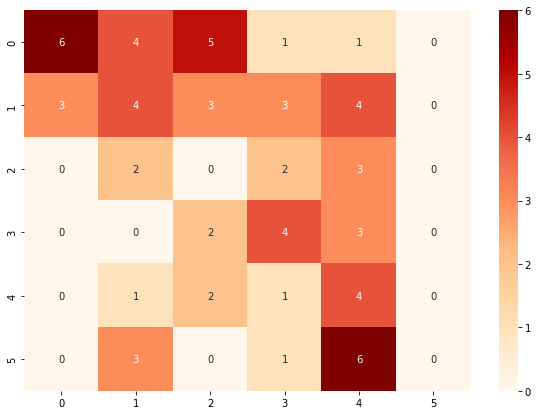

In [ ]:
import seaborn as sns
cmat_df = pd.DataFrame(conf_matrix)
plt.figure(figsize = (10,7))
sns.heatmap(cmat_df, annot=True,cmap="OrRd")

## Submitting

For the submission, we decided to take into consideration all the trained folds so that we have a better generalization. We consider that if we take only the best fold, we would have end up with a bad public score since it doesn't generalize well the test data. Adopting this strategy yielded to the least difference between the mean CV and the public score.

In [ ]:
# Creating a dataset for glued images.
# Loading statistics
mean = np.array([1.0-0.69026962 , 1.0-0.51690255 , 1.0-0.79142021])
std = np.array([0.33372767 , 0.40041865 , 0.3762294])

path_load = '/content/drive/MyDrive/DLMI/purple_36_128/test'
class GluedImagesDataset_test(Dataset):
    def __init__(self,df,path_load,standard=True,transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.path_load = path_load
        self.standard = standard

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.image_id
        
        images = cv2.cvtColor(cv2.imread(os.path.join(self.path_load,str(img_id)+'.png')), cv2.COLOR_BGR2RGB)
        images = 255-images

        if self.transform is not None:
            images = self.transform(image=images)['image']

        images = images.astype(np.float32)
        if self.standard ==True :
          images = (images/255.0 - mean)/std
        else:
          images/= 255
        images = images.transpose(2, 0, 1) # Transposing so it matches the tensor type
        return torch.tensor(images)



In [ ]:
path_load = "/content/drive/MyDrive/DLMI/test_128_36"
def inference_folds(model, test_loader, device):
    
    model.to(device) 
    
    LOGITS = []
    with torch.no_grad():
      for i, images in enumerate(test_loader):   
          images = images.to(device,dtype=torch.float)
          logits = model(images)
          pred = logits.sigmoid().sum(1).detach().round()
          LOGITS.append(logits.sigmoid().detach().to('cpu').numpy())
    LOGITS = np.concatenate(LOGITS)
    
    return LOGITS

def submit_folds(sample,):

    test_dataset = GluedImagesDataset_test(df_test, path_load, transform=None)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    probs = []
    for fold in range(5):
        state_dict = torch.load(f"/content/drive/MyDrive/DLMI/models/Accuracy_lfoss_resnet18_128_36_with_std_all_data{fold}.pth")
        
        #model = create_model("resnet18")
        model = create_model("efficientnet_b0")
        model.load_state_dict(state_dict)
        model = model.to(device)
        model.eval()
        _probs = inference_folds(model, test_loader, device)
        
        probs.append(_probs)
    probs_1 = np.mean(probs, axis=0)
    
    preds = np.sum(probs_1,axis=1).round()
    sample['isup_grade'] = preds
    print("Create the file to submit correctly")
    return sample

In [ ]:
To_submit_allFolds = submit_folds(df_test)
To_submit_allFolds['isup_grade'] = To_submit_allFolds['isup_grade'].astype('int')

ToSubmit = pd.DataFrame()
ToSubmit['Id'] = To_submit_allFolds['image_id']
ToSubmit['Predicted'] = To_submit_allFolds['isup_grade']

ToSubmit.to_csv('/content/drive/MyDrive/DLMI/submission.csv', index=False)

run inference
Create the file to submit correctly


In [ ]:
ToSubmit.head()

,Id,Predicted
0,254fbd7f21925ba7732800213af7ed47,2
1,8a76998072bccebf4c6f78ff7cc7b94e,0
2,7e81ad62302e6eabe1230d2d9d604881,1
3,3b343b8c4e2a854735a82bcebe482a14,1
4,1115d114a4339de8dd9f36d6465c6d57,2


Ensembling on all the trained models.

In [ ]:
path_load = "/content/drive/MyDrive/DLMI/test_128_36"

In [ ]:
def inference_folds(model, test_loader, device):
    
    model.to(device) 
    
    LOGITS = []
    with torch.no_grad():
      for i, images in enumerate(test_loader):   
          images = images.to(device,dtype=torch.float)
          logits = model(images)
          pred = logits.sigmoid().sum(1).detach().round()
          LOGITS.append(logits.sigmoid().detach().to('cpu').numpy())
    LOGITS = np.concatenate(LOGITS)
    
    return LOGITS

def submit_folds_ensembling(sample,):
    
    print('run inference')
    test_dataset = GluedImagesDataset_test(df_test, path_load, transform=None)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    probs = []
    models_names =["efficientnet_b0","resnet18","seresnet18","mobilenet_w1"]
    models_paths = ["/content/drive/MyDrive/DLMI/models/AUC_lfoss_Efficientnetb0_128_36_with_std_all_data","/content/drive/MyDrive/DLMI/models/AUC_lfoss_resnet18_128_36_with_std_all_data"]

    models_paths = ["/content/drive/MyDrive/DLMI/models/AUC_lfoss_Efficientnetb0_128_36_with_std_all_data","/content/drive/MyDrive/DLMI/models/AUC_lfoss_resnet18_128_36_with_std_all_data","/content/drive/MyDrive/DLMI/models/AUC_lfoss_seresnet18_128_36_with_std_all_data","/content/drive/MyDrive/DLMI/models/AUC_lfoss_squeezenet_v1_0_128_36_with_std_all_data" ]
    models_paths = ["/content/drive/MyDrive/DLMI/models/AUC_lfoss_Efficientnetb0_128_36_with_std_all_data","/content/drive/MyDrive/DLMI/models/AUC_lfoss_resnet18_128_36_with_std_all_data"]

    for i in range(len(models_paths)):
      for fold in range(5):
          state_dict = torch.load(f"{models_paths[i]}{fold}.pth")
          #model = create_model("resnet18")
          model = create_model(models_names[i])
          model.load_state_dict(state_dict)
          model = model.to(device)
          model.eval()
          _probs = inference_folds(model, test_loader, device)
          
          probs.append(_probs)
    probs_1 = np.mean(probs, axis=0)
    
    preds = np.sum(probs_1,axis=1).round()
    sample['isup_grade'] = preds
    print("Create the file to submit correctly")
    return sample

In [ ]:
To_submit_allFolds = submit_folds_ensembling(df_test)


To_submit_allFolds['isup_grade'] = To_submit_allFolds['isup_grade'].astype('int')

ToSubmit = pd.DataFrame()
ToSubmit['Id'] = To_submit_allFolds['image_id']
ToSubmit['Predicted'] = To_submit_allFolds['isup_grade']

ToSubmit.to_csv('/content/drive/MyDrive/DLMI/submission_ensemble.csv', index=False)

run inference
Create the file to submit correctly


In [ ]:
ToSubmit

,Id,Predicted
0,254fbd7f21925ba7732800213af7ed47,3
1,8a76998072bccebf4c6f78ff7cc7b94e,1
2,7e81ad62302e6eabe1230d2d9d604881,2
3,3b343b8c4e2a854735a82bcebe482a14,1
4,1115d114a4339de8dd9f36d6465c6d57,2
...,...,...
81,fa7ece1587e37e28416110063cc5266a,1
82,fda9a587d6bbfa5ceabe1840b2ae6337,2
83,7f1d716f6d571e3a9aece85c67774b33,1
84,0ab626bb7e1eb8c7b1eb6ac3fb129349,1
